## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [20]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown experimental "flakes" feature.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://openlane2.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [21]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9491k    0 9491k    0     0  14.8M      0 --:--:-- --:--:-- --:--:-- 14.8M


Version bdc9412b3e468c102d01b7cf6337be06ec6e9c9a enabled for the sky130 PDK.

In [22]:
import openlane

print(openlane.__version__)

2.1.11


### Creating the design

Now that OpenLane is set up, we can write a Verilog file as follows:

In [23]:
%%writefile neuron.v
module neuron #(
    parameter Q          = 24,
    parameter N_INPUTS   = 4,
    parameter DATA_WIDTH = 32
) (
    input  wire                         clk,
    input  wire                         rst_n,
    input  wire                         af_sel,     // 0: tanh, 1: sigmoid
    input  wire signed [N_INPUTS*DATA_WIDTH-1:0] x_packed,
    input  wire signed [N_INPUTS*DATA_WIDTH-1:0] w_packed,
    input  wire signed [DATA_WIDTH-1:0] bias,
    output reg  signed [DATA_WIDTH-1:0] out
);

// Unpack Inputs/Weights
wire signed [DATA_WIDTH-1:0] x [N_INPUTS-1:0];
wire signed [DATA_WIDTH-1:0] w [N_INPUTS-1:0];

genvar p;
generate
    for (p=0; p<N_INPUTS; p=p+1) begin : UNPACK
        assign x[p] = x_packed[p*DATA_WIDTH +: DATA_WIDTH];
        assign w[p] = w_packed[p*DATA_WIDTH +: DATA_WIDTH];
    end
endgenerate

// Pipeline Stage 1: Input Buffering
reg signed [DATA_WIDTH-1:0] x_buf [N_INPUTS-1:0];
reg signed [DATA_WIDTH-1:0] w_buf [N_INPUTS-1:0];
reg signed [DATA_WIDTH-1:0] bias_buf;

integer j;

always @(posedge clk or negedge rst_n) begin
    if (!rst_n) begin
        for (j=0; j<N_INPUTS; j=j+1) begin
            x_buf[j] <= 0;
            w_buf[j] <= 0;
        end
        bias_buf <= 0;
    end else begin
        for (j=0; j<N_INPUTS; j=j+1) begin
            x_buf[j] <= x[j];
            w_buf[j] <= w[j];
        end
        bias_buf <= bias;
    end
end

// Pipeline Stage 2: Parallel Multiplication
wire [2*DATA_WIDTH-1:0] mult_results [N_INPUTS-1:0];
reg [2*DATA_WIDTH-1:0] mult_results_reg [N_INPUTS-1:0];

genvar i;

generate
    for (i=0; i<N_INPUTS; i=i+1) begin : MULT
        qmult #(.Q(Q), .N(DATA_WIDTH)) mult (
            .i_multiplicand(x_buf[i]),
            .i_multiplier(w_buf[i]),
            .o_result(mult_results[i]),
            .ovr()  // Overflow monitoring optional
        );

        always @(posedge clk or negedge rst_n) begin
            if (!rst_n) mult_results_reg[i] <= 0;
            else mult_results_reg[i] <= mult_results[i];
        end
    end
endgenerate

// Stage 3: Accumulation Tree
wire [2*DATA_WIDTH-1:0] sum_stage1 [N_INPUTS/2-1:0];
wire [2*DATA_WIDTH-1:0] sum_stage2;

generate
    // First level of addition (pairwise)
    for (i=0; i<N_INPUTS/2; i=i+1) begin : ADD_STAGE1
        qadd #(.Q(2*Q), .N(2*DATA_WIDTH)) adder (
            .a(mult_results_reg[2*i]),
            .b(mult_results_reg[2*i+1]),
            .c(sum_stage1[i]),
            .ovr()
        );
    end

    // Second level of addition (final sum)
    if (N_INPUTS > 2) begin : ADD_STAGE2
        qadd #(.Q(2*Q), .N(2*DATA_WIDTH)) final_adder (
            .a(sum_stage1[0]),
            .b(sum_stage1[1]),
            .c(sum_stage2),
            .ovr()
        );
    end else begin
        assign sum_stage2 = sum_stage1[0];
    end
endgenerate

// Stage 4: Bias Addition
wire [2*DATA_WIDTH-1:0] bias_ext = {bias_buf, {Q{1'b0}}}; // Q24 -> Q48
wire [2*DATA_WIDTH-1:0] sum_with_bias_wire;

qadd #(.Q(2*Q), .N(2*DATA_WIDTH)) bias_adder (
    .a(sum_stage2),
    .b(bias_ext),
    .c(sum_with_bias_wire),
    .ovr()
);

reg [DATA_WIDTH-1:0] sum_with_bias;
always @(posedge clk or negedge rst_n) begin
    if (!rst_n) sum_with_bias <= 0;
    else begin
        // Truncate from Q48 to Q24 with rounding
        sum_with_bias <= sum_with_bias_wire[Q +: DATA_WIDTH];
    end
end

// Pipeline Stage 4: Activation Function
wire signed [DATA_WIDTH-1:0] tanh_out, sigmoid_out;

tanh #(.Q(Q), .N(DATA_WIDTH)) tanh_inst (
    .x(sum_with_bias),
    .y(tanh_out)
);

sigmoid #(.Q(Q), .N(DATA_WIDTH)) sigmoid_inst (
    .x(sum_with_bias),
    .y(sigmoid_out)
);

// Activation function selection
reg signed [DATA_WIDTH-1:0] af_result;
always @(posedge clk or negedge rst_n) begin
    if (!rst_n) af_result <= 0;
    else af_result <= af_sel ? sigmoid_out : tanh_out;
end

// Pipeline Stage 5: Output Buffering
always @(posedge clk or negedge rst_n) begin
    if (!rst_n) out <= 0;
    else out <= af_result;
end

endmodule


module qadd #(
	//Parameterized values
	parameter Q = 15,
	parameter N = 32
	)
	(
    input [N-1:0] a,
    input [N-1:0] b,
    output [N-1:0] c,
    output ovr
    );
        reg [N-1:0] res;
        reg ovr_reg;
        reg [N-1:0] sum_mag;

        assign ovr = ovr_reg;
        assign c = res;

        always @(a,b) begin
        sum_mag = 0;
        ovr_reg = 0;
        res = 0;
        // both negative or both positive
        if(a[N-1] == b[N-1]) begin
            sum_mag = a[N-2:0] + b[N-2:0];
            res[N-2:0] = a[N-2:0] + b[N-2:0];
            res[N-1] = a[N-1];
            ovr_reg = sum_mag[N-1];
            end
        //	one of them is negative...
        else if(a[N-1] == 0 && b[N-1] == 1) begin
            if( a[N-2:0] > b[N-2:0] ) begin
                res[N-2:0] = a[N-2:0] - b[N-2:0];
                res[N-1] = 0;
                end
            else begin
                res[N-2:0] = b[N-2:0] - a[N-2:0];
                if (res[N-2:0] == 0)
                    res[N-1] = 0;
                else
                    res[N-1] = 1;
                end
            ovr_reg = 0;
            end
        else begin
            if( a[N-2:0] > b[N-2:0] ) begin
                res[N-2:0] = a[N-2:0] - b[N-2:0];
                if (res[N-2:0] == 0)
                    res[N-1] = 0;
                else
                    res[N-1] = 1;
                end
            else begin
                res[N-2:0] = b[N-2:0] - a[N-2:0];
                res[N-1] = 0;
                end
            ovr_reg = 0;
            end
        end
    endmodule


module qmult #(
    parameter Q = 24,
    parameter N = 32
    ) (
        input [N-1:0] i_multiplicand,
        input [N-1:0] i_multiplier,
        output [2*N-1:0] o_result,
        output reg ovr
    );

        reg [2*N-2:0] magnitude_product;
        reg sign_bit;
        // Threshold for overflow: (2^(N-1) - 1) << Q
        localparam THRESHOLD = ( (1 << (N-1)) - 1 ) << Q;

        always @(*) begin
            magnitude_product = i_multiplicand[N-2:0] * i_multiplier[N-2:0];
            sign_bit = i_multiplicand[N-1] ^ i_multiplier[N-1];
            // Overflow occurs if the product exceeds the maximum N-1 bit magnitude
            ovr = (magnitude_product > THRESHOLD);
        end

        assign o_result = {sign_bit, magnitude_product};

    endmodule


module qmac #(
    parameter Q = 5,
    parameter N = 8
    ) (
        input clk,
        input reset,
        input [N-1:0] a,
        input [N-1:0] b,
        output [2*N-1:0] result,
        output overflow
    );

        reg [2*N-1:0] accumulator;

        wire [2*N-1:0] product;
        wire mult_overflow;

        wire [2*N-1:0] sum;
        wire add_overflow;

        qmult #(.Q(Q), .N(N)) multiplier (
            .i_multiplicand(a),
            .i_multiplier(b),
            .o_result(product),
            .ovr(mult_overflow)
        );

        qadd #(.Q(2*Q), .N(2*N)) adder (
            .a(accumulator),
            .b(product),
            .c(sum),
            .ovr(add_overflow)
        );

        always @(posedge clk or posedge reset) begin
            if (reset)
                accumulator <= 0;
            else
                accumulator <= sum;
        end

        assign result = accumulator;
        assign overflow = add_overflow;

    endmodule


module sigmoid #(
    parameter Q = 24,
    parameter N = 32
    ) (
    input [N-1:0] x,
    output [N-1:0] y
    );
    // Thresholds
    localparam [N-1:0] T_1       = 32'b00000001000000000000000000000000; // 1.0
    localparam [N-1:0] T_2       = 32'b00000010000000000000000000000000; // 2.0
    localparam [N-1:0] T_3       = 32'b00000011000000000000000000000000; // 3.0
    localparam [N-1:0] T_4_5     = 32'b00000100100000000000000000000000; // 4.5
    localparam [N-1:0] T_8       = 32'b00001000000000000000000000000000; // 8.0

    // Coefficients for the piecewise linear approximation
    localparam signed [N-1:0] SLOPE1    = 32'b00000000000000001010010100100111; // 0.00252
    localparam signed [N-1:0] INTERCEPT1= 32'b00000000000001001100110011001101; // 0.01875
    localparam signed [N-1:0] SLOPE2    = 32'b00000000000001100000111100111101; // 0.02367
    localparam signed [N-1:0] INTERCEPT2= 32'b00000000000111010010110100100011; // 0.11397
    localparam signed [N-1:0] SLOPE3    = 32'b00000000000100011101101100100011; // 0.06975
    localparam signed [N-1:0] INTERCEPT3= 32'b00000000010000001000111110000110; // 0.25219
    localparam signed [N-1:0] SLOPE4    = 32'b00000000001001011111111000110011; // 0.14841
    localparam signed [N-1:0] INTERCEPT4= 32'b00000000011010001101010110100110; // 0.40951
    localparam signed [N-1:0] SLOPE5    = 32'b00000000001111010010100010001101; // 0.2389
    localparam signed [N-1:0] INTERCEPT5= 32'b00000000100000000000000000000000; // 0.5
    localparam signed [N-1:0] SLOPE6    = 32'b00000000001001011111111000110011; // 0.14841
    localparam signed [N-1:0] INTERCEPT6= 32'b00000000100101110010101001011010; // 0.59049
    localparam signed [N-1:0] SLOPE7    = 32'b00000000000100011101101100100011; // 0.06975
    localparam signed [N-1:0] INTERCEPT7= 32'b00000000101111110111000001111010; // 0.74781
    localparam signed [N-1:0] SLOPE8    = 32'b00000000000001100000111100111101; // 0.02367
    localparam signed [N-1:0] INTERCEPT8= 32'b00000000111000101101001011011101; // 0.88603
    localparam signed [N-1:0] SLOPE9    = 32'b00000000000000001010010100100111; // 0.00252
    localparam signed [N-1:0] INTERCEPT9= 32'b00000000111110110011001100110011; // 0.98125

    reg [N-1:0] slope;
    reg [N-1:0] intercept;
    wire [2*N-1:0] product;
    wire [N-1:0] product_trunc;
    wire [N-1:0] sum;
    wire ovr_mult, ovr_add;

    // magnitude and the sign bit of x
    wire [N-2:0] x_mag = x[N-2:0];
    wire x_sign = x[N-1];

    // coefficient selection logic
    always @(*) begin
        if (x_sign == 1'b1) begin  // Negative x
            if (x_mag >= T_8[N-2:0]) begin  // |x| >= 8.0
                slope = 32'b00000000000000000000000000000000;  // 0
                intercept = 32'b00000000000000000000000000000000;  // 0
            end else if (x_mag >= T_4_5[N-2:0] && x_mag < T_8[N-2:0]) begin  // 4.5 <= |x| < 8.0
                slope = SLOPE1;
                intercept = INTERCEPT1;
            end else if (x_mag >= T_3[N-2:0] && x_mag < T_4_5[N-2:0]) begin  // 3.0 <= |x| < 4.5
                slope = SLOPE2;
                intercept = INTERCEPT2;
            end else if (x_mag >= T_2[N-2:0] && x_mag < T_3[N-2:0]) begin  // 2.0 <= |x| < 3.0
                slope = SLOPE3;
                intercept = INTERCEPT3;
            end else if (x_mag >= T_1[N-2:0] && x_mag < T_2[N-2:0]) begin  // 1.0 <= |x| < 2.0
                slope = SLOPE4;
                intercept = INTERCEPT4;
            end else begin  // 0 < |x| < 1.0
                slope = SLOPE5;
                intercept = INTERCEPT5;
            end
        end else begin  // Positive x
            if (x_mag >= T_8[N-2:0]) begin  // x >= 8.0
                slope = 32'b00000000000000000000000000000000;  // 0
                intercept = 32'b00000001000000000000000000000000;  // 1.0
            end else if (x_mag >= T_4_5[N-2:0] && x_mag < T_8[N-2:0]) begin  // 4.5 <= x < 8.0
                slope = SLOPE9;
                intercept = INTERCEPT9;
            end else if (x_mag >= T_3[N-2:0] && x_mag < T_4_5[N-2:0]) begin  // 3.0 <= x < 4.5
                slope = SLOPE8;
                intercept = INTERCEPT8;
            end else if (x_mag >= T_2[N-2:0] && x_mag < T_3[N-2:0]) begin  // 2.0 <= x < 3.0
                slope = SLOPE7;
                intercept = INTERCEPT7;
            end else if (x_mag >= T_1[N-2:0] && x_mag < T_2[N-2:0]) begin  // 1.0 <= x < 2.0
                slope = SLOPE6;
                intercept = INTERCEPT6;
            end else begin  // 0 <= x < 1.0
                slope = SLOPE5;
                intercept = INTERCEPT5;
            end
        end
    end

    // Fixed-point multiplication
    qmult #(.Q(Q), .N(N)) mult (
        .i_multiplicand(x),
        .i_multiplier(slope),
        .o_result(product),
        .ovr(ovr_mult)
    );

    // Extract the proper bits from the product
    // For Q24, we need bits [55:24] of the 64-bit product
    assign product_trunc = {product[2*N-1], product[Q+N-2:Q]};

    // Fixed-point addition
    qadd #(.Q(Q), .N(N)) add (
        .a(product_trunc),
        .b(intercept),
        .c(sum),
        .ovr(ovr_add)
    );

    // Final output selection with proper sign handling
    assign y = (x_sign == 1'b1 && x_mag >= T_8[N-2:0]) ? 32'b00000000000000000000000000000000 :  // 0.0 for x <= -8.0
               (x_sign == 1'b0 && x_mag >= T_8[N-2:0]) ? 32'b00000001000000000000000000000000 :  // 1.0 for x >= 8.0
               sum;
endmodule


module tanh #(
    parameter Q = 24,
    parameter N = 32
    ) (
    input [N-1:0] x,
    output [N-1:0] y
    );
    localparam [N-1:0] TWO       = 32'b00000010000000000000000000000000; // +2.0
    localparam [N-1:0] ONE       = 32'b00000001000000000000000000000000; // +1.0
    localparam [N-1:0] NEG_ONE   = 32'b10000001000000000000000000000000; // -1.0

    wire [2*N-1:0] doubled_x;
    wire [N-1:0] sigmoid_result;
    wire [2*N-1:0] scaled_sigmoid;
    wire [N-1:0] final_result;

    qmult #(.Q(Q), .N(N)) double_mult (
        .i_multiplicand(x),
        .i_multiplier(TWO),
        .o_result(doubled_x),
        .ovr()
    );

    sigmoid #(.Q(Q), .N(N)) sigmoid_inst (
        .x(doubled_x[N-1:0]),
        .y(sigmoid_result)
    );

    qmult #(.Q(Q), .N(N)) scale_mult (
        .i_multiplicand(sigmoid_result),
        .i_multiplier(TWO),
        .o_result(scaled_sigmoid),
        .ovr()
    );

    qadd #(.Q(Q), .N(N)) subtr (
        .a(scaled_sigmoid[N-1:0]),
        .b(ONE),
        .c(final_result),
        .ovr()
    );

    assign y = final_result[N-1] ?
        {1'b1, final_result[N-2:0]} :  // Maintain sign-magnitude
        final_result;

endmodule

Overwriting neuron.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [24]:
from openlane.config import Config

Config.interactive(
    "neuron",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 10
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: neuron
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/openlane_ipynb/openlane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.volare
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  openlane_version: 2.1.11
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain OpenLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from openlane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from openlane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://openlane2.readthedocs.io/en/latest/reference/step_config_vars.html

In [25]:
from openlane.steps import Step

* First, get the step (and display its help)...

In [26]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()


(step-yosys-synthesis)=
### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

```

#### Importing
```python
from openlane.steps.yosys import Synthesis

# or

from openlane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |

(yosys.synthesis-configuration-variables)=
#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP`{#var-yosys-synthesis-synth_latch_map}<sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP`{#var-yosys-synthesis-synth_tristate_map}<sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP`{#var-yosys-synthesis-synth_csa_map}<sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP`{#var-yosys-synthesis-synth_rca_map}<sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP`{#var-yosys-synthesis-synth_fa_map}<sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP`{#var-yosys-synthesis-synth_mux_map}<sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP`{#var-yosys-synthesis-synth_mux4_map}<sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`{#var-yosys-synthesis-use_lighter} | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`{#var-yosys-synthesis-lighter_dff_map} | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`{#var-yosys-synthesis-yosys_log_level} | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`{#var-yosys-synthesis-synth_checks_allow_tristate} | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`{#var-yosys-synthesis-synth_autoname} | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`{#var-yosys-synthesis-synth_strategy} | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`{#var-yosys-synthesis-synth_abc_buffering} | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`{#var-yosys-synthesis-synth_abc_legacy_refactor} | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`{#var-yosys-synthesis-synth_abc_legacy_rewrite} | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`{#var-yosys-synthesis-synth_direct_wire_buffering} | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`{#var-yosys-synthesis-synth_splitnets} | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`{#var-yosys-synthesis-synth_sizing} | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_NO_FLAT`{#var-yosys-synthesis-synth_no_flat} | bool | A flag that disables flattening the hierarchy during synthesis, only flattening it after synthesis, mapping and optimizations. | `False` |  |
| `SYNTH_SHARE_RESOURCES`{#var-yosys-synthesis-synth_share_resources} | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`{#var-yosys-synthesis-synth_adder_type} | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`{#var-yosys-synthesis-synth_extra_mapping_file} | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_PARAMETERS`{#var-yosys-synthesis-synth_parameters} | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `SYNTH_ELABORATE_ONLY`{#var-yosys-synthesis-synth_elaborate_only} | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`{#var-yosys-synthesis-synth_elaborate_flatten} | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `VERILOG_FILES`{#var-yosys-synthesis-verilog_files} | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`{#var-yosys-synthesis-verilog_defines} | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`{#var-yosys-synthesis-verilog_power_define} | str | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`{#var-yosys-synthesis-verilog_include_dirs} | List[str]? | Specifies the Verilog `include` directories. | `None` |  |
| `USE_SYNLIG`{#var-yosys-synthesis-use_synlig} | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`{#var-yosys-synthesis-synlig_defer} | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [27]:
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./neuron.v"],
    state_in=State(),
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[17:51:32] VERBOSE  Running 'Yosys.Synthesis'…                                                         ]8;id=108276;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=530210;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:51:32] VERBOSE  Logging subprocess to ]8;id=877450;file:///content/openlane_run/3-yosys-synthesis/yosys-synthesis.log\openlane_run/]8;;\]8;id=912668;file:///content/openlane_run/3-yosys-synthesis/yosys-synthesis.log\3]8;;\]8;id=877450;file:///content/openlane_run/3-yosys-synthesis/yosys-synthesis.log\-yosys-synthesis/yosys-synthesis.log]8;;\…          ]8;id=448616;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=145778;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Loaded SDC plugin

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

1. Executing Liberty frontend: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

2. Executing Verilog-2005 frontend: ./neuron.v

Parsing SystemVerilog input from `./neuron.v' to AST representation.

Generating RTLIL representation for module `\neuron'.

Warning: Replacing memory \mult_results_reg with list of registers. See ./neuron.v:66

Warning: Replacing memory \w_buf with list of registers. See ./neuron.v:38

Warning: Replacing memory \x_buf with list of registers. See ./neuron.v:37

Generating RTLIL representation for module `\qadd'.

Note: Assuming pure combinatorial block at ./neuron.v:167.9-207.12 in

compliance with IEC 62142(E):2005 / IEEE Std. 1364.1(E):2002. Recommending

use of @* instead of @(...) for better match of synthesis and simulation.

Generating RTLIL representation for module `\qmult'.

Generating RTLIL representation for module `\qmac'.

Generating RTLIL representation for module `\sigmoid'.

Generating RTLIL representation for module `\tanh'.

Successfully finished Verilog frontend.

3. Executing HIERARCHY pass (managing design hierarchy).

3.1. Analyzing design hierarchy..

Top module:  \neuron

Used module:     \qadd

Used module:     \qmult

Used module:     \sigmoid

Used module:     \tanh

Parameter \Q = 48

Parameter \N = 64

3.2. Executing AST frontend in derive mode using pre-parsed AST for module `\qadd'.

Parameter \Q = 48

Parameter \N = 64

Generating RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Note: Assuming pure combinatorial block at ./neuron.v:167.9-207.12 in

compliance with IEC 62142(E):2005 / IEEE Std. 1364.1(E):2002. Recommending

use of @* instead of @(...) for better match of synthesis and simulation.

Parameter \Q = 48

Parameter \N = 64

Found cached RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Parameter \Q = 48

Parameter \N = 64

Found cached RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Parameter \Q = 24

Parameter \N = 32

3.3. Executing AST frontend in derive mode using pre-parsed AST for module `\qmult'.

Parameter \Q = 24

Parameter \N = 32

Generating RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

3.4. Executing AST frontend in derive mode using pre-parsed AST for module `\sigmoid'.

Parameter \Q = 24

Parameter \N = 32

Generating RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid'.

Parameter \Q = 24

Parameter \N = 32

3.5. Executing AST frontend in derive mode using pre-parsed AST for module `\tanh'.

Parameter \Q = 24

Parameter \N = 32

Generating RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\tanh'.

Parameter \Q = 48

Parameter \N = 64

Found cached RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Reprocessing module neuron because instantiated module qadd has become available.

Generating RTLIL representation for module `\neuron'.

Warning: Replacing memory \mult_results_reg with list of registers. See ./neuron.v:66

Warning: Replacing memory \w_buf with list of registers. See ./neuron.v:38

Warning: Replacing memory \x_buf with list of registers. See ./neuron.v:37

Parameter \Q = 24

Parameter \N = 32

3.6. Executing AST frontend in derive mode using pre-parsed AST for module `\qadd'.

Parameter \Q = 24

Parameter \N = 32

Generating RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd'.

Note: Assuming pure combinatorial block at ./neuron.v:167.9-207.12 in

compliance with IEC 62142(E):2005 / IEEE Std. 1364.1(E):2002. Recommending

use of @* instead of @(...) for better match of synthesis and simulation.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

3.7. Analyzing design hierarchy..

Top module:  \neuron

Used module:     \qadd

Used module:     \qmult

Used module:     \sigmoid

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult

Used module:     \tanh

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid

Parameter \Q = 48

Parameter \N = 64

Found cached RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Parameter \Q = 48

Parameter \N = 64

Found cached RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Parameter \Q = 48

Parameter \N = 64

Found cached RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\tanh'.

Parameter \Q = 48

Parameter \N = 64

Found cached RTLIL representation for module `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

3.8. Analyzing design hierarchy..

Top module:  \neuron

Used module:     $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh

Used module:         \qadd

Used module:         \qmult

Used module:         \sigmoid

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid'.

Parameter \Q = 24

Parameter \N = 32

Found cached RTLIL representation for module `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult'.

3.9. Analyzing design hierarchy..

Top module:  \neuron

Used module:     $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh

3.10. Analyzing design hierarchy..

Top module:  \neuron

Used module:     $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh

Removing unused module `\tanh'.

Removing unused module `\sigmoid'.

Removing unused module `\qmac'.

Removing unused module `\qmult'.

Removing unused module `\qadd'.

Removed 5 unused modules.

Renaming module neuron to neuron.

4. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/3-yosys-synthesis/hierarchy.dot'.

Dumping module neuron to page 1.

5. Executing TRIBUF pass.

6. Executing HIERARCHY pass (managing design hierarchy).

6.1. Analyzing design hierarchy..

Top module:  \neuron

Used module:     $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh

6.2. Analyzing design hierarchy..

Top module:  \neuron

Used module:     $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid

Used module:         $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd

Used module:     $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh

Removed 0 unused modules.

7. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

8. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$./neuron.v:65$169 in module neuron.

Marked 1 switch rules as full_case in process $proc$./neuron.v:65$167 in module neuron.

Marked 1 switch rules as full_case in process $proc$./neuron.v:65$165 in module neuron.

Marked 1 switch rules as full_case in process $proc$./neuron.v:65$163 in module neuron.

Marked 1 switch rules as full_case in process $proc$./neuron.v:141$161 in module neuron.

Marked 1 switch rules as full_case in process $proc$./neuron.v:135$158 in module neuron.

Marked 1 switch rules as full_case in process $proc$./neuron.v:112$156 in module neuron.

Marked 1 switch rules as full_case in process $proc$./neuron.v:34$154 in module neuron.

Marked 6 switch rules as full_case in process $proc$./neuron.v:167$172 in module                                   
$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.

Marked 11 switch rules as full_case in process $proc$./neuron.v:331$97 in module                                   
$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.

Marked 6 switch rules as full_case in process $proc$./neuron.v:167$78 in module                                    
$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.

Removed a total of 0 dead cases.

9. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 16 redundant assignments.

Promoted 26 assignments to connections.

10. Executing PROC_INIT pass (extract init attributes).

11. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst_n in `\neuron.$proc$./neuron.v:65$169'.

Found async reset \rst_n in `\neuron.$proc$./neuron.v:65$167'.

Found async reset \rst_n in `\neuron.$proc$./neuron.v:65$165'.

Found async reset \rst_n in `\neuron.$proc$./neuron.v:65$163'.

Found async reset \rst_n in `\neuron.$proc$./neuron.v:141$161'.

Found async reset \rst_n in `\neuron.$proc$./neuron.v:135$158'.

Found async reset \rst_n in `\neuron.$proc$./neuron.v:112$156'.

Found async reset \rst_n in `\neuron.$proc$./neuron.v:34$154'.

12. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

<suppressed ~23 debug messages>

13. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\neuron.$proc$./neuron.v:0$171'.

Creating decoders for process `\neuron.$proc$./neuron.v:65$169'.

1/1: $0\mult_results_reg[3][63:0]

Creating decoders for process `\neuron.$proc$./neuron.v:65$167'.

1/1: $0\mult_results_reg[2][63:0]

Creating decoders for process `\neuron.$proc$./neuron.v:65$165'.

1/1: $0\mult_results_reg[1][63:0]

Creating decoders for process `\neuron.$proc$./neuron.v:65$163'.

1/1: $0\mult_results_reg[0][63:0]

Creating decoders for process `\neuron.$proc$./neuron.v:141$161'.

1/1: $0\out[31:0]

Creating decoders for process `\neuron.$proc$./neuron.v:135$158'.

1/1: $0\af_result[31:0]

Creating decoders for process `\neuron.$proc$./neuron.v:112$156'.

1/1: $0\sum_with_bias[31:0]

Creating decoders for process `\neuron.$proc$./neuron.v:34$154'.

1/10: $0\bias_buf[31:0]

2/10: $1\j[31:0]

3/10: $0\w_buf[3][31:0]

4/10: $0\x_buf[3][31:0]

5/10: $0\w_buf[2][31:0]

6/10: $0\x_buf[2][31:0]

7/10: $0\w_buf[1][31:0]

8/10: $0\x_buf[1][31:0]

9/10: $0\w_buf[0][31:0]

10/10: $0\x_buf[0][31:0]

Creating decoders for process `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.$proc$./neuron.v:167$172'.

1/12: $6\res[31:31]

2/12: $5\res[31:0] [31]

3/12: $5\res[31:0] [30:0]

4/12: $4\res[31:31]

5/12: $3\res[31:0] [31]

6/12: $3\res[31:0] [30:0]

7/12: $2\ovr_reg[0:0]

8/12: $2\res[31:0]

9/12: $1\res[31:0] [31]

10/12: $1\res[31:0] [30:0]

11/12: $1\ovr_reg[0:0]

12/12: $1\sum_mag[31:0]

Creating decoders for process `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.$proc$./neuron.v:331$97'.

1/22: $11\intercept[31:0]

2/22: $11\slope[31:0]

3/22: $10\intercept[31:0]

4/22: $10\slope[31:0]

5/22: $9\intercept[31:0]

6/22: $9\slope[31:0]

7/22: $8\intercept[31:0]

8/22: $8\slope[31:0]

9/22: $7\intercept[31:0]

10/22: $7\slope[31:0]

11/22: $6\intercept[31:0]

12/22: $6\slope[31:0]

13/22: $5\intercept[31:0]

14/22: $5\slope[31:0]

15/22: $4\intercept[31:0]

16/22: $4\slope[31:0]

17/22: $3\intercept[31:0]

18/22: $3\slope[31:0]

19/22: $2\intercept[31:0]

20/22: $2\slope[31:0]

21/22: $1\intercept[31:0]

22/22: $1\slope[31:0]

Creating decoders for process `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.$proc$./neuron.v:226$93'.

Creating decoders for process `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.$proc$./neuron.v:167$78'.

1/12: $6\res[63:63]

2/12: $5\res[63:0] [63]

3/12: $5\res[63:0] [62:0]

4/12: $4\res[63:63]

5/12: $3\res[63:0] [63]

6/12: $3\res[63:0] [62:0]

7/12: $2\ovr_reg[0:0]

8/12: $2\res[63:0]

9/12: $1\res[63:0] [63]

10/12: $1\res[63:0] [62:0]

11/12: $1\ovr_reg[0:0]

12/12: $1\sum_mag[63:0]

14. Executing PROC_DLATCH pass (convert process syncs to latches).

No latch inferred for signal `\neuron.\x[0]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\x[1]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\x[2]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\x[3]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\w[0]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\w[1]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\w[2]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\w[3]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\mult_results[0]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\mult_results[1]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\mult_results[2]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\mult_results[3]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\sum_stage1[0]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `\neuron.\sum_stage1[1]' from process `\neuron.$proc$./neuron.v:0$171'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.\res' from process            
`$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.$proc$./neuron.v:167$172'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.\ovr_reg' from process        
`$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.$proc$./neuron.v:167$172'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.\sum_mag' from process        
`$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.$proc$./neuron.v:167$172'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.\slope' from process       
`$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.$proc$./neuron.v:331$97'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.\intercept' from process   
`$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.$proc$./neuron.v:331$97'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.\ovr' from process           
`$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.$proc$./neuron.v:226$93'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.\magnitude_product' from     
process `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.$proc$./neuron.v:226$93'.

No latch inferred for signal `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.\sign_bit' from process      
`$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.$proc$./neuron.v:226$93'.

No latch inferred for signal `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.\res' from process            
`$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.$proc$./neuron.v:167$78'.

No latch inferred for signal `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.\ovr_reg' from process        
`$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.$proc$./neuron.v:167$78'.

No latch inferred for signal `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.\sum_mag' from process        
`$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.$proc$./neuron.v:167$78'.

15. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\neuron.\mult_results_reg[3]' using process `\neuron.$proc$./neuron.v:65$169'.

created $adff cell `$procdff$599' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\mult_results_reg[2]' using process `\neuron.$proc$./neuron.v:65$167'.

created $adff cell `$procdff$600' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\mult_results_reg[1]' using process `\neuron.$proc$./neuron.v:65$165'.

created $adff cell `$procdff$601' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\mult_results_reg[0]' using process `\neuron.$proc$./neuron.v:65$163'.

created $adff cell `$procdff$602' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\out' using process `\neuron.$proc$./neuron.v:141$161'.

created $adff cell `$procdff$603' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\af_result' using process `\neuron.$proc$./neuron.v:135$158'.

created $adff cell `$procdff$604' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\sum_with_bias' using process `\neuron.$proc$./neuron.v:112$156'.

created $adff cell `$procdff$605' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\bias_buf' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$606' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\j' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$607' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\x_buf[0]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$608' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\x_buf[1]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$609' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\x_buf[2]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$610' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\x_buf[3]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$611' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\w_buf[0]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$612' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\w_buf[1]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$613' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\w_buf[2]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$614' with positive edge clock and negative level reset.

Creating register for signal `\neuron.\w_buf[3]' using process `\neuron.$proc$./neuron.v:34$154'.

created $adff cell `$procdff$615' with positive edge clock and negative level reset.

16. Executing PROC_MEMWR pass (convert process memory writes to cells).

17. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Removing empty process `neuron.$proc$./neuron.v:0$171'.

Removing empty process `neuron.$proc$./neuron.v:65$169'.

Removing empty process `neuron.$proc$./neuron.v:65$167'.

Removing empty process `neuron.$proc$./neuron.v:65$165'.

Removing empty process `neuron.$proc$./neuron.v:65$163'.

Removing empty process `neuron.$proc$./neuron.v:141$161'.

Removing empty process `neuron.$proc$./neuron.v:135$158'.

Removing empty process `neuron.$proc$./neuron.v:112$156'.

Removing empty process `neuron.$proc$./neuron.v:34$154'.

Found and cleaned up 6 empty switches in                                                                           
`$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.$proc$./neuron.v:167$172'.

Removing empty process `$paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.$proc$./neuron.v:167$172'.

Found and cleaned up 11 empty switches in                                                                          
`$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.$proc$./neuron.v:331$97'.

Removing empty process `$paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.$proc$./neuron.v:331$97'.

Removing empty process `$paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.$proc$./neuron.v:226$93'.

Found and cleaned up 6 empty switches in                                                                           
`$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.$proc$./neuron.v:167$78'.

Removing empty process `$paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.$proc$./neuron.v:167$78'.

Cleaned up 23 empty switches.

18. Executing CHECK pass (checking for obvious problems).

Checking module neuron...

Checking module $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd...

Checking module $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid...

Checking module $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult...

Checking module $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd...

Checking module $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh...

Found and reported 0 problems.

19. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

Optimizing module $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.

<suppressed ~4 debug messages>

Optimizing module $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.

<suppressed ~3 debug messages>

Optimizing module $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.

Optimizing module $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.

<suppressed ~4 debug messages>

Optimizing module $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh.

20. Executing FLATTEN pass (flatten design).

Deleting now unused module $paramod$df1804173035f59e6c52050461b74a97876481e4\qadd.

Deleting now unused module $paramod$df1804173035f59e6c52050461b74a97876481e4\sigmoid.

Deleting now unused module $paramod$df1804173035f59e6c52050461b74a97876481e4\qmult.

Deleting now unused module $paramod$18d45c800f8bba9079ff30513d39c3a7b63f9488\qadd.

Deleting now unused module $paramod$df1804173035f59e6c52050461b74a97876481e4\tanh.

<suppressed ~16 debug messages>

21. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~49 debug messages>

22. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 66 unused cells and 734 unused wires.

<suppressed ~94 debug messages>

23. Executing OPT pass (performing simple optimizations).

23.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

23.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~135 debug messages>

Removed a total of 45 cells.

23.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Replacing known input bits on port A of cell $flatten\tanh_inst.\subtr.$procmux$259:                               
\tanh_inst.scale_mult.i_multiplicand [6] -> 1'0

Replacing known input bits on port A of cell $flatten\tanh_inst.$ternary$./neuron.v:444$133:                       
\tanh_inst.final_result -> { 1'0 \tanh_inst.final_result [30:0] }

Analyzing evaluation results.

dead port 2/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$520.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$523.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$526.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$532.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$535.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$541.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$544.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$551.

dead port 2/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$553.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$556.

dead port 2/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$562.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$565.

dead port 2/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$571.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$574.

dead port 1/2 on $mux $flatten\ADD_STAGE1[1].adder.$procmux$585.

dead port 2/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$520.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$523.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$526.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$532.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$535.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$541.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$544.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$551.

dead port 2/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$553.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$556.

dead port 2/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$562.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$565.

dead port 2/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$571.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$574.

dead port 1/2 on $mux $flatten\ADD_STAGE2.final_adder.$procmux$585.

dead port 2/2 on $mux $flatten\bias_adder.$procmux$520.

dead port 2/2 on $mux $flatten\bias_adder.$procmux$526.

dead port 2/2 on $mux $flatten\bias_adder.$procmux$535.

dead port 2/2 on $mux $flatten\bias_adder.$procmux$544.

dead port 2/2 on $mux $flatten\bias_adder.$procmux$585.

dead port 2/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$520.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$523.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$526.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$532.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$535.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$541.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$544.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$551.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$274.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$277.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$280.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$283.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$286.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$292.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$295.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$298.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$301.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$304.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$310.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$313.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$316.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$319.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$325.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$328.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$331.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$334.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$340.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$343.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$346.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$352.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$355.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$358.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$364.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$367.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$373.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$376.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$382.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$388.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$395.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$398.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$401.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$404.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$406.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$413.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$416.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$419.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$422.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$424.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$431.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$434.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$437.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$439.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$446.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$449.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$452.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$454.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$461.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$464.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$466.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$473.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$476.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$478.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$485.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$487.

dead port 1/2 on $mux $flatten\sigmoid_inst.$procmux$494.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$496.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$502.

dead port 2/2 on $mux $flatten\sigmoid_inst.$procmux$508.

dead port 2/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$553.

dead port 2/2 on $mux $flatten\sigmoid_inst.\add.$procmux$191.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$194.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$197.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$203.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$206.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$212.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$215.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$222.

dead port 2/2 on $mux $flatten\sigmoid_inst.\add.$procmux$224.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$227.

dead port 2/2 on $mux $flatten\sigmoid_inst.\add.$procmux$233.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$236.

dead port 2/2 on $mux $flatten\sigmoid_inst.\add.$procmux$242.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$245.

dead port 1/2 on $mux $flatten\sigmoid_inst.\add.$procmux$256.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$556.

dead port 2/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$562.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$565.

dead port 2/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$571.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$574.

dead port 1/2 on $mux $flatten\ADD_STAGE1[0].adder.$procmux$585.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$274.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$277.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$280.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$283.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$286.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$292.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$295.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$298.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$301.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$304.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$310.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$313.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$316.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$319.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$325.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$328.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$331.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$334.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$340.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$343.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$346.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$352.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$355.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$358.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$364.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$367.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$373.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$376.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$382.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$388.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$395.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$398.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$401.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$404.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$406.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$413.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$416.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$419.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$422.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$424.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$431.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$434.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$437.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$439.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$446.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$449.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$452.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$454.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$461.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$464.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$466.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$473.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$476.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$478.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$485.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$487.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$494.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$496.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$502.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.$procmux$508.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$191.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$194.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$197.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$203.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$206.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$212.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$215.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$222.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$224.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$227.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$233.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$236.

dead port 2/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$242.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$245.

dead port 1/2 on $mux $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$256.

dead port 2/2 on $mux $flatten\tanh_inst.\subtr.$procmux$191.

dead port 2/2 on $mux $flatten\tanh_inst.\subtr.$procmux$197.

dead port 2/2 on $mux $flatten\tanh_inst.\subtr.$procmux$206.

dead port 2/2 on $mux $flatten\tanh_inst.\subtr.$procmux$215.

dead port 2/2 on $mux $flatten\tanh_inst.\subtr.$procmux$256.

Removed 205 multiplexer ports.

<suppressed ~20 debug messages>

23.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

23.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~45 debug messages>

Removed a total of 15 cells.

23.6. Executing OPT_DFF pass (perform DFF optimizations).

23.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 3 unused cells and 269 unused wires.

<suppressed ~11 debug messages>

23.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~2 debug messages>

23.9. Rerunning OPT passes. (Maybe there is more to do..)

23.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~19 debug messages>

23.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

23.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

23.13. Executing OPT_DFF pass (perform DFF optimizations).

23.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 0 unused cells and 2 unused wires.

<suppressed ~1 debug messages>

23.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

23.16. Rerunning OPT passes. (Maybe there is more to do..)

23.17. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~19 debug messages>

23.18. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

23.19. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

23.20. Executing OPT_DFF pass (perform DFF optimizations).

23.21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

23.22. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

23.23. Finished OPT passes. (There is nothing left to do.)

24. Executing FSM pass (extract and optimize FSM).

24.1. Executing FSM_DETECT pass (finding FSMs in design).

24.2. Executing FSM_EXTRACT pass (extracting FSM from design).

24.3. Executing FSM_OPT pass (simple optimizations of FSMs).

24.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

24.5. Executing FSM_OPT pass (simple optimizations of FSMs).

24.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

24.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

24.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

25. Executing OPT pass (performing simple optimizations).

25.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

25.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

25.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~19 debug messages>

25.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

25.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

25.6. Executing OPT_DFF pass (perform DFF optimizations).

25.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

25.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

25.9. Finished OPT passes. (There is nothing left to do.)

26. Executing WREDUCE pass (reducing word size of cells).

Removed top 8 bits (of 32) from mux cell neuron.$flatten\sigmoid_inst.$procmux$392 ($mux).

Removed top 11 bits (of 32) from mux cell neuron.$flatten\sigmoid_inst.$procmux$289 ($mux).

Removed top 11 bits (of 32) from mux cell neuron.$flatten\sigmoid_inst.$procmux$271 ($mux).

Removed top 8 bits (of 63) from port Y of cell neuron.$flatten\sigmoid_inst.\mult.$mul$./neuron.v:227$94 ($mul).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$lt$./neuron.v:345$110 ($lt).

Removed top 6 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$ge$./neuron.v:345$109 ($ge).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$lt$./neuron.v:342$107 ($lt).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$ge$./neuron.v:342$106 ($ge).

Removed top 4 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$lt$./neuron.v:339$104 ($lt).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$ge$./neuron.v:339$103 ($ge).

Removed top 3 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$lt$./neuron.v:336$101 ($lt).

Removed top 4 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$ge$./neuron.v:336$100 ($ge).

Removed top 3 bits (of 31) from port B of cell neuron.$flatten\sigmoid_inst.$ge$./neuron.v:333$99 ($ge).

Removed top 7 bits (of 63) from mux cell neuron.$flatten\bias_adder.$procmux$591 ($mux).

Removed top 7 bits (of 63) from mux cell neuron.$flatten\bias_adder.$procmux$538 ($mux).

Removed top 7 bits (of 63) from port A of cell neuron.$flatten\bias_adder.$sub$./neuron.v:202$92 ($sub).

Removed top 7 bits (of 63) from port Y of cell neuron.$flatten\bias_adder.$sub$./neuron.v:202$92 ($sub).

Removed top 7 bits (of 63) from port B of cell neuron.$flatten\bias_adder.$sub$./neuron.v:202$92 ($sub).

Removed top 7 bits (of 63) from port B of cell neuron.$flatten\bias_adder.$sub$./neuron.v:195$90 ($sub).

Removed top 7 bits (of 63) from port Y of cell neuron.$flatten\bias_adder.$sub$./neuron.v:195$90 ($sub).

Removed top 7 bits (of 63) from port A of cell neuron.$flatten\bias_adder.$sub$./neuron.v:195$90 ($sub).

Removed top 7 bits (of 63) from port B of cell neuron.$flatten\bias_adder.$gt$./neuron.v:194$89 ($gt).

Removed top 7 bits (of 63) from port B of cell neuron.$flatten\bias_adder.$add$./neuron.v:174$81 ($add).

Removed top 7 bits (of 63) from port Y of cell neuron.$flatten\bias_adder.$add$./neuron.v:174$81 ($add).

Removed top 7 bits (of 63) from port A of cell neuron.$flatten\bias_adder.$add$./neuron.v:174$81 ($add).

Removed top 6 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\subtr.$add$./neuron.v:174$175 ($add).

Removed top 6 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\subtr.$gt$./neuron.v:194$183 ($gt).

Removed top 6 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\subtr.$sub$./neuron.v:195$184 ($sub).

Removed top 6 bits (of 31) from port A of cell neuron.$flatten\tanh_inst.\subtr.$sub$./neuron.v:202$186 ($sub).

Removed top 3 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:333$99 ($ge).

Removed top 4 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:336$100      
($ge).

Removed top 3 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:336$101      
($lt).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:339$103      
($ge).

Removed top 4 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:339$104      
($lt).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:342$106      
($ge).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:342$107      
($lt).

Removed top 6 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:345$109      
($ge).

Removed top 5 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:345$110      
($lt).

Removed top 8 bits (of 38) from port Y of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\mult.$mul$./neuron.v:227$94
($mul).

Removed top 25 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$ternary$./neuron.v:396$132      
($mux).

Removed top 11 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$271 ($mux).

Removed top 11 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$289 ($mux).

Removed top 10 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$307 ($mux).

Removed top 10 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$322 ($mux).

Removed top 9 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$337 ($mux).

Removed top 10 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$349 ($mux).

Removed top 9 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$361 ($mux).

Removed top 10 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$370 ($mux).

Removed top 7 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$379 ($mux).

Removed top 10 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$385 ($mux).

Removed top 8 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$392 ($mux).

Removed top 8 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$428 ($mux).

Removed top 8 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$458 ($mux).

Removed top 8 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$482 ($mux).

Removed top 8 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$500 ($mux).

Removed top 1 bits (of 63) from port Y of cell neuron.$flatten\MULT[0].mult.$mul$./neuron.v:227$94 ($mul).

Removed top 1 bits (of 63) from port Y of cell neuron.$flatten\MULT[1].mult.$mul$./neuron.v:227$94 ($mul).

Removed top 1 bits (of 63) from port Y of cell neuron.$flatten\MULT[2].mult.$mul$./neuron.v:227$94 ($mul).

Removed top 1 bits (of 63) from port Y of cell neuron.$flatten\MULT[3].mult.$mul$./neuron.v:227$94 ($mul).

Removed top 25 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$ternary$./neuron.v:397$131      
($mux).

Removed top 24 bits (of 31) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$procmux$262 ($mux).

Removed cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$procmux$259 ($mux).

Removed cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$procmux$253 ($mux).

Removed top 24 bits (of 31) from port Y of cell                                                                    
neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$add$./neuron.v:174$175 ($add).

Removed top 24 bits (of 31) from port A of cell                                                                    
neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$add$./neuron.v:174$175 ($add).

Removed top 24 bits (of 31) from port B of cell                                                                    
neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$add$./neuron.v:174$175 ($add).

Removed top 9 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\mult.$mul$./neuron.v:227$94
($mul).

Removed top 2 bits (of 30) from port Y of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\mult.$mul$./neuron.v:227$94
($mul).

Removed top 7 bits (of 32) from mux cell neuron.$flatten\tanh_inst.\sigmoid_inst.$procmux$511 ($mux).

Removed top 6 bits (of 31) from port A of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181
($sub).

Removed top 2 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181
($sub).

Removed top 1 bits (of 31) from port Y of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181
($sub).

Removed top 2 bits (of 31) from port A of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180
($sub).

Removed top 6 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180
($sub).

Removed top 1 bits (of 31) from port Y of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180
($sub).

Removed top 2 bits (of 31) from port A of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$gt$./neuron.v:180$179 
($gt).

Removed top 6 bits (of 31) from port B of cell neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$gt$./neuron.v:180$179 
($gt).

Removed top 8 bits (of 64) from wire neuron.$flatten\bias_adder.$2\res[63:0].

Removed top 7 bits (of 63) from wire neuron.$flatten\bias_adder.$add$./neuron.v:174$81_Y.

Removed top 7 bits (of 63) from wire neuron.$flatten\bias_adder.$sub$./neuron.v:195$90_Y.

Removed top 14 bits (of 63) from wire neuron.$flatten\bias_adder.$sub$./neuron.v:202$92_Y.

Removed top 11 bits (of 32) from wire neuron.$flatten\sigmoid_inst.$11\intercept[31:0].

Removed top 11 bits (of 32) from wire neuron.$flatten\sigmoid_inst.$11\slope[31:0].

Removed top 10 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$10\intercept[31:0].

Removed top 25 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$10\slope[31:0].

Removed top 11 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$11\intercept[31:0].

Removed top 13 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$11\slope[31:0].

Removed top 8 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$2\intercept[31:0].

Removed top 8 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$3\intercept[31:0].

Removed top 10 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$3\slope[31:0].

Removed top 25 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.$ternary$./neuron.v:397$131_Y.

Removed top 25 bits (of 32) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$2\res[31:0].

Removed top 24 bits (of 31) from wire neuron.$flatten\tanh_inst.\sigmoid_inst.\add.$add$./neuron.v:174$175_Y.

Removed top 8 bits (of 64) from wire neuron.bias_ext.

Removed top 8 bits (of 64) from wire neuron.sum_with_bias_wire.

27. Executing PEEPOPT pass (run peephole optimizers).

28. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 8 unused cells and 25 unused wires.

<suppressed ~9 debug messages>

29. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module neuron:

creating $macc model for $flatten\ADD_STAGE1[0].adder.$add$./neuron.v:174$81 ($add).

creating $macc model for $flatten\ADD_STAGE1[0].adder.$sub$./neuron.v:181$86 ($sub).

creating $macc model for $flatten\ADD_STAGE1[0].adder.$sub$./neuron.v:185$87 ($sub).

creating $macc model for $flatten\ADD_STAGE1[1].adder.$add$./neuron.v:174$81 ($add).

creating $macc model for $flatten\ADD_STAGE1[1].adder.$sub$./neuron.v:181$86 ($sub).

creating $macc model for $flatten\ADD_STAGE1[1].adder.$sub$./neuron.v:185$87 ($sub).

creating $macc model for $flatten\ADD_STAGE2.final_adder.$add$./neuron.v:174$81 ($add).

creating $macc model for $flatten\ADD_STAGE2.final_adder.$sub$./neuron.v:181$86 ($sub).

creating $macc model for $flatten\ADD_STAGE2.final_adder.$sub$./neuron.v:185$87 ($sub).

creating $macc model for $flatten\MULT[0].mult.$mul$./neuron.v:227$94 ($mul).

creating $macc model for $flatten\MULT[1].mult.$mul$./neuron.v:227$94 ($mul).

creating $macc model for $flatten\MULT[2].mult.$mul$./neuron.v:227$94 ($mul).

creating $macc model for $flatten\MULT[3].mult.$mul$./neuron.v:227$94 ($mul).

creating $macc model for $flatten\bias_adder.$add$./neuron.v:174$81 ($add).

creating $macc model for $flatten\bias_adder.$sub$./neuron.v:195$90 ($sub).

creating $macc model for $flatten\bias_adder.$sub$./neuron.v:202$92 ($sub).

creating $macc model for $flatten\sigmoid_inst.\add.$add$./neuron.v:174$175 ($add).

creating $macc model for $flatten\sigmoid_inst.\add.$sub$./neuron.v:181$180 ($sub).

creating $macc model for $flatten\sigmoid_inst.\add.$sub$./neuron.v:185$181 ($sub).

creating $macc model for $flatten\sigmoid_inst.\mult.$mul$./neuron.v:227$94 ($mul).

creating $macc model for $flatten\tanh_inst.\sigmoid_inst.\add.$add$./neuron.v:174$175 ($add).

creating $macc model for $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180 ($sub).

creating $macc model for $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181 ($sub).

creating $macc model for $flatten\tanh_inst.\sigmoid_inst.\mult.$mul$./neuron.v:227$94 ($mul).

creating $macc model for $flatten\tanh_inst.\subtr.$add$./neuron.v:174$175 ($add).

creating $macc model for $flatten\tanh_inst.\subtr.$sub$./neuron.v:195$184 ($sub).

creating $macc model for $flatten\tanh_inst.\subtr.$sub$./neuron.v:202$186 ($sub).

creating $alu model for $macc $flatten\tanh_inst.\subtr.$sub$./neuron.v:202$186.

creating $alu model for $macc $flatten\tanh_inst.\subtr.$sub$./neuron.v:195$184.

creating $alu model for $macc $flatten\tanh_inst.\subtr.$add$./neuron.v:174$175.

creating $alu model for $macc $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181.

creating $alu model for $macc $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180.

creating $alu model for $macc $flatten\tanh_inst.\sigmoid_inst.\add.$add$./neuron.v:174$175.

creating $alu model for $macc $flatten\sigmoid_inst.\add.$sub$./neuron.v:185$181.

creating $alu model for $macc $flatten\sigmoid_inst.\add.$sub$./neuron.v:181$180.

creating $alu model for $macc $flatten\sigmoid_inst.\add.$add$./neuron.v:174$175.

creating $alu model for $macc $flatten\bias_adder.$sub$./neuron.v:202$92.

creating $alu model for $macc $flatten\bias_adder.$sub$./neuron.v:195$90.

creating $alu model for $macc $flatten\bias_adder.$add$./neuron.v:174$81.

creating $alu model for $macc $flatten\ADD_STAGE2.final_adder.$sub$./neuron.v:185$87.

creating $alu model for $macc $flatten\ADD_STAGE2.final_adder.$sub$./neuron.v:181$86.

creating $alu model for $macc $flatten\ADD_STAGE2.final_adder.$add$./neuron.v:174$81.

creating $alu model for $macc $flatten\ADD_STAGE1[1].adder.$sub$./neuron.v:185$87.

creating $alu model for $macc $flatten\ADD_STAGE1[1].adder.$sub$./neuron.v:181$86.

creating $alu model for $macc $flatten\ADD_STAGE1[1].adder.$add$./neuron.v:174$81.

creating $alu model for $macc $flatten\ADD_STAGE1[0].adder.$sub$./neuron.v:185$87.

creating $alu model for $macc $flatten\ADD_STAGE1[0].adder.$sub$./neuron.v:181$86.

creating $alu model for $macc $flatten\ADD_STAGE1[0].adder.$add$./neuron.v:174$81.

creating $macc cell for $flatten\MULT[1].mult.$mul$./neuron.v:227$94: $auto$alumacc.cc:365:replace_macc$634

creating $macc cell for $flatten\MULT[0].mult.$mul$./neuron.v:227$94: $auto$alumacc.cc:365:replace_macc$635

creating $macc cell for $flatten\tanh_inst.\sigmoid_inst.\mult.$mul$./neuron.v:227$94:                             
$auto$alumacc.cc:365:replace_macc$636

creating $macc cell for $flatten\MULT[3].mult.$mul$./neuron.v:227$94: $auto$alumacc.cc:365:replace_macc$637

creating $macc cell for $flatten\sigmoid_inst.\mult.$mul$./neuron.v:227$94: $auto$alumacc.cc:365:replace_macc$638

creating $macc cell for $flatten\MULT[2].mult.$mul$./neuron.v:227$94: $auto$alumacc.cc:365:replace_macc$639

creating $alu model for $flatten\ADD_STAGE1[0].adder.$gt$./neuron.v:180$85 ($gt): merged with                      
$flatten\ADD_STAGE1[0].adder.$sub$./neuron.v:185$87.

creating $alu model for $flatten\ADD_STAGE1[1].adder.$gt$./neuron.v:180$85 ($gt): merged with                      
$flatten\ADD_STAGE1[1].adder.$sub$./neuron.v:185$87.

creating $alu model for $flatten\ADD_STAGE2.final_adder.$gt$./neuron.v:180$85 ($gt): merged with                   
$flatten\ADD_STAGE2.final_adder.$sub$./neuron.v:185$87.

creating $alu model for $flatten\bias_adder.$gt$./neuron.v:194$89 ($gt): new $alu

creating $alu model for $flatten\sigmoid_inst.$ge$./neuron.v:333$99 ($ge): new $alu

creating $alu model for $flatten\sigmoid_inst.$ge$./neuron.v:336$100 ($ge): new $alu

creating $alu model for $flatten\sigmoid_inst.$ge$./neuron.v:339$103 ($ge): new $alu

creating $alu model for $flatten\sigmoid_inst.$ge$./neuron.v:342$106 ($ge): new $alu

creating $alu model for $flatten\sigmoid_inst.$ge$./neuron.v:345$109 ($ge): new $alu

creating $alu model for $flatten\sigmoid_inst.$lt$./neuron.v:336$101 ($lt): merged with                            
$flatten\sigmoid_inst.$ge$./neuron.v:333$99.

creating $alu model for $flatten\sigmoid_inst.$lt$./neuron.v:339$104 ($lt): merged with                            
$flatten\sigmoid_inst.$ge$./neuron.v:336$100.

creating $alu model for $flatten\sigmoid_inst.$lt$./neuron.v:342$107 ($lt): merged with                            
$flatten\sigmoid_inst.$ge$./neuron.v:339$103.

creating $alu model for $flatten\sigmoid_inst.$lt$./neuron.v:345$110 ($lt): merged with                            
$flatten\sigmoid_inst.$ge$./neuron.v:342$106.

creating $alu model for $flatten\sigmoid_inst.\add.$gt$./neuron.v:180$179 ($gt): merged with                       
$flatten\sigmoid_inst.\add.$sub$./neuron.v:181$180.

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:333$99 ($ge): new $alu

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:336$100 ($ge): new $alu

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:339$103 ($ge): new $alu

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:342$106 ($ge): new $alu

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:345$109 ($ge): new $alu

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:336$101 ($lt): merged with                 
$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:333$99.

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:339$104 ($lt): merged with                 
$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:336$100.

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:342$107 ($lt): merged with                 
$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:339$103.

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:345$110 ($lt): merged with                 
$flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:342$106.

creating $alu model for $flatten\tanh_inst.\sigmoid_inst.\add.$gt$./neuron.v:180$179 ($gt): merged with            
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181.

creating $alu model for $flatten\tanh_inst.\subtr.$gt$./neuron.v:194$183 ($gt): merged with                        
$flatten\tanh_inst.\subtr.$sub$./neuron.v:202$186.

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:345$109:                                    
$auto$alumacc.cc:485:replace_alu$651

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:342$106,                                    
$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:345$110: $auto$alumacc.cc:485:replace_alu$660

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:339$103,                                    
$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:342$107: $auto$alumacc.cc:485:replace_alu$673

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:336$100,                                    
$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:339$104: $auto$alumacc.cc:485:replace_alu$686

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.$ge$./neuron.v:333$99,                                     
$flatten\tanh_inst.\sigmoid_inst.$lt$./neuron.v:336$101: $auto$alumacc.cc:485:replace_alu$699

creating $alu cell for $flatten\sigmoid_inst.$ge$./neuron.v:345$109: $auto$alumacc.cc:485:replace_alu$712

creating $alu cell for $flatten\sigmoid_inst.$ge$./neuron.v:342$106, $flatten\sigmoid_inst.$lt$./neuron.v:345$110: 
$auto$alumacc.cc:485:replace_alu$721

creating $alu cell for $flatten\sigmoid_inst.$ge$./neuron.v:339$103, $flatten\sigmoid_inst.$lt$./neuron.v:342$107: 
$auto$alumacc.cc:485:replace_alu$734

creating $alu cell for $flatten\sigmoid_inst.$ge$./neuron.v:336$100, $flatten\sigmoid_inst.$lt$./neuron.v:339$104: 
$auto$alumacc.cc:485:replace_alu$747

creating $alu cell for $flatten\sigmoid_inst.$ge$./neuron.v:333$99, $flatten\sigmoid_inst.$lt$./neuron.v:336$101:  
$auto$alumacc.cc:485:replace_alu$760

creating $alu cell for $flatten\bias_adder.$gt$./neuron.v:194$89: $auto$alumacc.cc:485:replace_alu$773

creating $alu cell for $flatten\ADD_STAGE1[0].adder.$sub$./neuron.v:181$86: $auto$alumacc.cc:485:replace_alu$778

creating $alu cell for $flatten\ADD_STAGE1[0].adder.$add$./neuron.v:174$81: $auto$alumacc.cc:485:replace_alu$781

creating $alu cell for $flatten\ADD_STAGE1[0].adder.$sub$./neuron.v:185$87,                                        
$flatten\ADD_STAGE1[0].adder.$gt$./neuron.v:180$85: $auto$alumacc.cc:485:replace_alu$784

creating $alu cell for $flatten\ADD_STAGE1[1].adder.$sub$./neuron.v:181$86: $auto$alumacc.cc:485:replace_alu$789

creating $alu cell for $flatten\ADD_STAGE1[1].adder.$add$./neuron.v:174$81: $auto$alumacc.cc:485:replace_alu$792

creating $alu cell for $flatten\ADD_STAGE1[1].adder.$sub$./neuron.v:185$87,                                        
$flatten\ADD_STAGE1[1].adder.$gt$./neuron.v:180$85: $auto$alumacc.cc:485:replace_alu$795

creating $alu cell for $flatten\ADD_STAGE2.final_adder.$sub$./neuron.v:181$86: $auto$alumacc.cc:485:replace_alu$800

creating $alu cell for $flatten\ADD_STAGE2.final_adder.$add$./neuron.v:174$81: $auto$alumacc.cc:485:replace_alu$803

creating $alu cell for $flatten\ADD_STAGE2.final_adder.$sub$./neuron.v:185$87,                                     
$flatten\ADD_STAGE2.final_adder.$gt$./neuron.v:180$85: $auto$alumacc.cc:485:replace_alu$806

creating $alu cell for $flatten\bias_adder.$add$./neuron.v:174$81: $auto$alumacc.cc:485:replace_alu$811

creating $alu cell for $flatten\bias_adder.$sub$./neuron.v:195$90: $auto$alumacc.cc:485:replace_alu$814

creating $alu cell for $flatten\bias_adder.$sub$./neuron.v:202$92: $auto$alumacc.cc:485:replace_alu$817

creating $alu cell for $flatten\sigmoid_inst.\add.$add$./neuron.v:174$175: $auto$alumacc.cc:485:replace_alu$820

creating $alu cell for $flatten\sigmoid_inst.\add.$sub$./neuron.v:181$180,                                         
$flatten\sigmoid_inst.\add.$gt$./neuron.v:180$179: $auto$alumacc.cc:485:replace_alu$823

creating $alu cell for $flatten\sigmoid_inst.\add.$sub$./neuron.v:185$181: $auto$alumacc.cc:485:replace_alu$834

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.\add.$add$./neuron.v:174$175:                              
$auto$alumacc.cc:485:replace_alu$837

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180:                              
$auto$alumacc.cc:485:replace_alu$840

creating $alu cell for $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181,                              
$flatten\tanh_inst.\sigmoid_inst.\add.$gt$./neuron.v:180$179: $auto$alumacc.cc:485:replace_alu$843

creating $alu cell for $flatten\tanh_inst.\subtr.$sub$./neuron.v:195$184: $auto$alumacc.cc:485:replace_alu$848

creating $alu cell for $flatten\tanh_inst.\subtr.$add$./neuron.v:174$175: $auto$alumacc.cc:485:replace_alu$851

creating $alu cell for $flatten\tanh_inst.\subtr.$sub$./neuron.v:202$186,                                          
$flatten\tanh_inst.\subtr.$gt$./neuron.v:194$183: $auto$alumacc.cc:485:replace_alu$854

created 32 $alu and 6 $macc cells.

30. Executing SHARE pass (SAT-based resource sharing).

31. Executing OPT pass (performing simple optimizations).

31.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~19 debug messages>

31.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~3 debug messages>

Removed a total of 1 cells.

31.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~18 debug messages>

31.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

31.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

31.6. Executing OPT_DFF pass (perform DFF optimizations).

Setting constant 0-bit at position 62 on $procdff$599 ($adff) from module neuron.

Setting constant 0-bit at position 62 on $procdff$600 ($adff) from module neuron.

Setting constant 0-bit at position 62 on $procdff$601 ($adff) from module neuron.

Setting constant 0-bit at position 62 on $procdff$602 ($adff) from module neuron.

31.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 7 unused cells and 33 unused wires.

<suppressed ~8 debug messages>

31.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

31.9. Rerunning OPT passes. (Maybe there is more to do..)

31.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~18 debug messages>

31.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

31.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

31.13. Executing OPT_DFF pass (perform DFF optimizations).

31.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

31.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

31.16. Finished OPT passes. (There is nothing left to do.)

32. Executing MEMORY pass.

32.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

32.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

32.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

32.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

32.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

32.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

32.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

32.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

32.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

32.10. Executing MEMORY_COLLECT pass (generating $mem cells).

33. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

34. Executing OPT pass (performing simple optimizations).

34.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~227 debug messages>

34.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~11 debug messages>

Removed a total of 3 cells.

34.3. Executing OPT_DFF pass (perform DFF optimizations).

34.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 26 unused cells and 218 unused wires.

<suppressed ~28 debug messages>

34.5. Finished fast OPT passes.

35. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

36. Executing OPT pass (performing simple optimizations).

36.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

36.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

36.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~18 debug messages>

36.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Consolidated identical input bits for $mux cell $flatten\ADD_STAGE1[0].adder.$procmux$582:

Old ports: A={ $flatten\ADD_STAGE1[0].adder.$5\res[63:0] [63] $flatten\ADD_STAGE1[0].adder.$3\res[63:0] [62:0] },  
B=$flatten\ADD_STAGE1[0].adder.$3\res[63:0], Y=$flatten\ADD_STAGE1[0].adder.$2\res[63:0]

New ports: A=$flatten\ADD_STAGE1[0].adder.$5\res[63:0] [63], B=$flatten\ADD_STAGE1[0].adder.$3\res[63:0] [63],     
Y=$flatten\ADD_STAGE1[0].adder.$2\res[63:0] [63]

New connections: $flatten\ADD_STAGE1[0].adder.$2\res[63:0] [62:0] = $flatten\ADD_STAGE1[0].adder.$3\res[63:0]      
[62:0]

Consolidated identical input bits for $mux cell $flatten\ADD_STAGE1[1].adder.$procmux$582:

Old ports: A={ $flatten\ADD_STAGE1[1].adder.$5\res[63:0] [63] $flatten\ADD_STAGE1[1].adder.$3\res[63:0] [62:0] },  
B=$flatten\ADD_STAGE1[1].adder.$3\res[63:0], Y=$flatten\ADD_STAGE1[1].adder.$2\res[63:0]

New ports: A=$flatten\ADD_STAGE1[1].adder.$5\res[63:0] [63], B=$flatten\ADD_STAGE1[1].adder.$3\res[63:0] [63],     
Y=$flatten\ADD_STAGE1[1].adder.$2\res[63:0] [63]

New connections: $flatten\ADD_STAGE1[1].adder.$2\res[63:0] [62:0] = $flatten\ADD_STAGE1[1].adder.$3\res[63:0]      
[62:0]

Consolidated identical input bits for $mux cell $flatten\ADD_STAGE2.final_adder.$procmux$582:

Old ports: A={ $flatten\ADD_STAGE2.final_adder.$5\res[63:0] [63] $flatten\ADD_STAGE2.final_adder.$3\res[63:0]      
[62:0] }, B=$flatten\ADD_STAGE2.final_adder.$3\res[63:0], Y=$flatten\ADD_STAGE2.final_adder.$2\res[63:0]

New ports: A=$flatten\ADD_STAGE2.final_adder.$5\res[63:0] [63], B=$flatten\ADD_STAGE2.final_adder.$3\res[63:0]     
[63], Y=$flatten\ADD_STAGE2.final_adder.$2\res[63:0] [63]

New connections: $flatten\ADD_STAGE2.final_adder.$2\res[63:0] [62:0] = $flatten\ADD_STAGE2.final_adder.$3\res[63:0]
[62:0]

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$271:

Old ports: A=21'000000000000000000000, B=21'101110010101001011010, Y=$auto$wreduce.cc:461:run$620 [20:0]

New ports: A=1'0, B=1'1, Y=$auto$wreduce.cc:461:run$620 [1]

New connections: { $auto$wreduce.cc:461:run$620 [20:2] $auto$wreduce.cc:461:run$620 [0] } = {                      
$auto$wreduce.cc:461:run$620 [1] 1'0 $auto$wreduce.cc:461:run$620 [1] $auto$wreduce.cc:461:run$620 [1]             
$auto$wreduce.cc:461:run$620 [1] 2'00 $auto$wreduce.cc:461:run$620 [1] 1'0 $auto$wreduce.cc:461:run$620 [1] 1'0    
$auto$wreduce.cc:461:run$620 [1] 2'00 $auto$wreduce.cc:461:run$620 [1] 1'0 $auto$wreduce.cc:461:run$620 [1]        
$auto$wreduce.cc:461:run$620 [1] 2'00 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$289:

Old ports: A=21'111010010100010001101, B=21'001011111111000110011, Y=$auto$wreduce.cc:461:run$621 [20:0]

New ports: A=2'10, B=2'01, Y=$auto$wreduce.cc:461:run$621 [2:1]

New connections: { $auto$wreduce.cc:461:run$621 [20:3] $auto$wreduce.cc:461:run$621 [0] } = {                      
$auto$wreduce.cc:461:run$621 [2] $auto$wreduce.cc:461:run$621 [2] 3'101 $auto$wreduce.cc:461:run$621 [1]           
$auto$wreduce.cc:461:run$621 [1] 1'1 $auto$wreduce.cc:461:run$621 [1] 1'1 $auto$wreduce.cc:461:run$621 [1]         
$auto$wreduce.cc:461:run$621 [1] 1'0 $auto$wreduce.cc:461:run$621 [2] 1'0 $auto$wreduce.cc:461:run$621 [1]         
$auto$wreduce.cc:461:run$621 [1] $auto$wreduce.cc:461:run$621 [2] 1'1 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$307:

Old ports: A={ 11'00000000100 $auto$wreduce.cc:461:run$620 [20:0] }, B=12546170,                                   
Y=$flatten\sigmoid_inst.$10\intercept[31:0]

New ports: A={ 1'0 $auto$wreduce.cc:461:run$620 [20:0] }, B=22'1111110111000001111010,                             
Y=$flatten\sigmoid_inst.$10\intercept[31:0] [21:0]

New connections: $flatten\sigmoid_inst.$10\intercept[31:0] [31:22] = 10'0000000010

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$322:

Old ports: A={ 11'00000000001 $auto$wreduce.cc:461:run$621 [20:0] }, B=1170211,                                    
Y=$flatten\sigmoid_inst.$10\slope[31:0]

New ports: A={ 1'1 $auto$wreduce.cc:461:run$621 [20:0] }, B=22'0100011101101100100011,                             
Y=$flatten\sigmoid_inst.$10\slope[31:0] [21:0]

New connections: $flatten\sigmoid_inst.$10\slope[31:0] [31:22] = 10'0000000000

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$392:

Old ports: A=24'100000000000000000000000, B=24'011010001101010110100110, Y=$flatten\sigmoid_inst.$6\intercept[31:0]
[23:0]

New ports: A=2'10, B=2'01, Y={ $flatten\sigmoid_inst.$6\intercept[31:0] [23]                                       
$flatten\sigmoid_inst.$6\intercept[31:0] [1] }

New connections: { $flatten\sigmoid_inst.$6\intercept[31:0] [22:2] $flatten\sigmoid_inst.$6\intercept[31:0] [0] } =
{ $flatten\sigmoid_inst.$6\intercept[31:0] [1] $flatten\sigmoid_inst.$6\intercept[31:0] [1] 1'0                    
$flatten\sigmoid_inst.$6\intercept[31:0] [1] 3'000 $flatten\sigmoid_inst.$6\intercept[31:0] [1]                    
$flatten\sigmoid_inst.$6\intercept[31:0] [1] 1'0 $flatten\sigmoid_inst.$6\intercept[31:0] [1] 1'0                  
$flatten\sigmoid_inst.$6\intercept[31:0] [1] 1'0 $flatten\sigmoid_inst.$6\intercept[31:0] [1]                      
$flatten\sigmoid_inst.$6\intercept[31:0] [1] 1'0 $flatten\sigmoid_inst.$6\intercept[31:0] [1] 2'00                 
$flatten\sigmoid_inst.$6\intercept[31:0] [1] 1'0 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$428:

Old ports: A={ 8'00000000 $flatten\sigmoid_inst.$6\intercept[31:0] [23:0] }, B=4231046,                            
Y=$flatten\sigmoid_inst.$5\intercept[31:0]

New ports: A=$flatten\sigmoid_inst.$6\intercept[31:0] [23:0], B=24'010000001000111110000110,                       
Y=$flatten\sigmoid_inst.$5\intercept[31:0] [23:0]

New connections: $flatten\sigmoid_inst.$5\intercept[31:0] [31:24] = 8'00000000

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.\add.$procmux$253:

Old ports: A={ $flatten\sigmoid_inst.\add.$5\res[31:0] [31] $flatten\sigmoid_inst.\add.$3\res[31:0] [30:0] },      
B=$flatten\sigmoid_inst.\add.$3\res[31:0], Y=$flatten\sigmoid_inst.\add.$2\res[31:0]

New ports: A=$flatten\sigmoid_inst.\add.$5\res[31:0] [31], B=$flatten\sigmoid_inst.\add.$3\res[31:0] [31],         
Y=$flatten\sigmoid_inst.\add.$2\res[31:0] [31]

New connections: $flatten\sigmoid_inst.\add.$2\res[31:0] [30:0] = $flatten\sigmoid_inst.\add.$3\res[31:0] [30:0]

Consolidated identical input bits for $mux cell $flatten\tanh_inst.$ternary$./neuron.v:444$133:

Old ports: A={ 1'0 \tanh_inst.final_result [30:0] }, B={ 1'1 \tanh_inst.final_result [30:0] }, Y=\tanh_out

New ports: A=1'0, B=1'1, Y=\tanh_out [31]

New connections: \tanh_out [30:0] = \tanh_inst.final_result [30:0]

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$271:

Old ports: A=21'000000000000000000000, B=21'101110010101001011010, Y=$auto$wreduce.cc:461:run$624 [20:0]

New ports: A=1'0, B=1'1, Y=$auto$wreduce.cc:461:run$624 [1]

New connections: { $auto$wreduce.cc:461:run$624 [20:2] $auto$wreduce.cc:461:run$624 [0] } = {                      
$auto$wreduce.cc:461:run$624 [1] 1'0 $auto$wreduce.cc:461:run$624 [1] $auto$wreduce.cc:461:run$624 [1]             
$auto$wreduce.cc:461:run$624 [1] 2'00 $auto$wreduce.cc:461:run$624 [1] 1'0 $auto$wreduce.cc:461:run$624 [1] 1'0    
$auto$wreduce.cc:461:run$624 [1] 2'00 $auto$wreduce.cc:461:run$624 [1] 1'0 $auto$wreduce.cc:461:run$624 [1]        
$auto$wreduce.cc:461:run$624 [1] 2'00 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$289:

Old ports: A=21'111010010100010001101, B=21'001011111111000110011, Y=$auto$wreduce.cc:461:run$625 [20:0]

New ports: A=2'10, B=2'01, Y=$auto$wreduce.cc:461:run$625 [2:1]

New connections: { $auto$wreduce.cc:461:run$625 [20:3] $auto$wreduce.cc:461:run$625 [0] } = {                      
$auto$wreduce.cc:461:run$625 [2] $auto$wreduce.cc:461:run$625 [2] 3'101 $auto$wreduce.cc:461:run$625 [1]           
$auto$wreduce.cc:461:run$625 [1] 1'1 $auto$wreduce.cc:461:run$625 [1] 1'1 $auto$wreduce.cc:461:run$625 [1]         
$auto$wreduce.cc:461:run$625 [1] 1'0 $auto$wreduce.cc:461:run$625 [2] 1'0 $auto$wreduce.cc:461:run$625 [1]         
$auto$wreduce.cc:461:run$625 [1] $auto$wreduce.cc:461:run$625 [2] 1'1 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$392:

Old ports: A=24'100000000000000000000000, B=24'011010001101010110100110,                                           
Y=$flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [23:0]

New ports: A=2'10, B=2'01, Y={ $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [23]                            
$flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] }

New connections: { $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [22:2]                                      
$flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [0] } = { $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0]  
[1] $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] 1'0 $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0]
[1] 3'000 $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1]                                                  
$flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] 1'0 $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1]
1'0 $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] 1'0 $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0]
[1] $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] 1'0 $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0]
[1] 2'00 $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] 1'0 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.\add.$procmux$209:

Old ports: A={ $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180_Y [30]                                
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180_Y [30]                                               
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180_Y [28:0] }, B={                                      
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181_Y [30]                                               
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181_Y [30]                                               
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181_Y [28:1] \tanh_inst.sigmoid_inst.add.b [0] }, Y={    
$flatten\tanh_inst.\sigmoid_inst.\add.$3\res[31:0] [30:7] $auto$wreduce.cc:461:run$630 [6:0] }

New ports: A={ $flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180_Y [30]                                
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:181$180_Y [28:0] }, B={                                      
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181_Y [30]                                               
$flatten\tanh_inst.\sigmoid_inst.\add.$sub$./neuron.v:185$181_Y [28:1] \tanh_inst.sigmoid_inst.add.b [0] }, Y={    
$flatten\tanh_inst.\sigmoid_inst.\add.$3\res[31:0] [29:7] $auto$wreduce.cc:461:run$630 [6:0] }

New connections: $flatten\tanh_inst.\sigmoid_inst.\add.$3\res[31:0] [30] =                                         
$flatten\tanh_inst.\sigmoid_inst.\add.$3\res[31:0] [29]

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\subtr.$procmux$209:

Old ports: A={ $flatten\tanh_inst.\subtr.$sub$./neuron.v:195$184_Y [30:24] 24'000000000000000000000000 }, B={      
$flatten\tanh_inst.\subtr.$sub$./neuron.v:202$186_Y [30:25] 25'1000000000000000000000000 },                        
Y=$flatten\tanh_inst.\subtr.$2\res[31:0] [30:0]

New ports: A=$flatten\tanh_inst.\subtr.$sub$./neuron.v:195$184_Y [30:24], B={                                      
$flatten\tanh_inst.\subtr.$sub$./neuron.v:202$186_Y [30:25] 1'1 }, Y=$flatten\tanh_inst.\subtr.$2\res[31:0] [30:24]

New connections: $flatten\tanh_inst.\subtr.$2\res[31:0] [23:0] = 24'000000000000000000000000

Optimizing cells in module \neuron.

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$307:

Old ports: A={ 1'0 $auto$wreduce.cc:461:run$620 [20:0] }, B=22'1111110111000001111010,                             
Y=$flatten\sigmoid_inst.$10\intercept[31:0] [21:0]

New ports: A={ $auto$wreduce.cc:461:run$620 [1] 1'0 $auto$wreduce.cc:461:run$620 [1] }, B=3'011, Y={               
$flatten\sigmoid_inst.$10\intercept[31:0] [9] $flatten\sigmoid_inst.$10\intercept[31:0] [5]                        
$flatten\sigmoid_inst.$10\intercept[31:0] [1] }

New connections: { $flatten\sigmoid_inst.$10\intercept[31:0] [21:10] $flatten\sigmoid_inst.$10\intercept[31:0]     
[8:6] $flatten\sigmoid_inst.$10\intercept[31:0] [4:2] $flatten\sigmoid_inst.$10\intercept[31:0] [0] } = {          
$flatten\sigmoid_inst.$10\intercept[31:0] [5] $flatten\sigmoid_inst.$10\intercept[31:0] [1]                        
$flatten\sigmoid_inst.$10\intercept[31:0] [5] $flatten\sigmoid_inst.$10\intercept[31:0] [1]                        
$flatten\sigmoid_inst.$10\intercept[31:0] [1] $flatten\sigmoid_inst.$10\intercept[31:0] [1] 1'0                    
$flatten\sigmoid_inst.$10\intercept[31:0] [5] $flatten\sigmoid_inst.$10\intercept[31:0] [1]                        
$flatten\sigmoid_inst.$10\intercept[31:0] [5] $flatten\sigmoid_inst.$10\intercept[31:0] [9] 3'000                  
$flatten\sigmoid_inst.$10\intercept[31:0] [1] $flatten\sigmoid_inst.$10\intercept[31:0] [1]                        
$flatten\sigmoid_inst.$10\intercept[31:0] [1] 2'00 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$322:

Old ports: A={ 1'1 $auto$wreduce.cc:461:run$621 [20:0] }, B=22'0100011101101100100011,                             
Y=$flatten\sigmoid_inst.$10\slope[31:0] [21:0]

New ports: A={ $auto$wreduce.cc:461:run$621 [2] 2'10 $auto$wreduce.cc:461:run$621 [1] $auto$wreduce.cc:461:run$621 
[2:1] }, B=6'101001, Y={ $flatten\sigmoid_inst.$10\slope[31:0] [20] $flatten\sigmoid_inst.$10\slope[31:0] [13]     
$flatten\sigmoid_inst.$10\slope[31:0] [8] $flatten\sigmoid_inst.$10\slope[31:0] [4]                                
$flatten\sigmoid_inst.$10\slope[31:0] [2:1] }

New connections: { $flatten\sigmoid_inst.$10\slope[31:0] [21] $flatten\sigmoid_inst.$10\slope[31:0] [19:14]        
$flatten\sigmoid_inst.$10\slope[31:0] [12:9] $flatten\sigmoid_inst.$10\slope[31:0] [7:5]                           
$flatten\sigmoid_inst.$10\slope[31:0] [3] $flatten\sigmoid_inst.$10\slope[31:0] [0] } = {                          
$flatten\sigmoid_inst.$10\slope[31:0] [13] $flatten\sigmoid_inst.$10\slope[31:0] [2]                               
$flatten\sigmoid_inst.$10\slope[31:0] [13] 2'01 $flatten\sigmoid_inst.$10\slope[31:0] [1]                          
$flatten\sigmoid_inst.$10\slope[31:0] [1] $flatten\sigmoid_inst.$10\slope[31:0] [1] 1'1                            
$flatten\sigmoid_inst.$10\slope[31:0] [4] $flatten\sigmoid_inst.$10\slope[31:0] [1]                                
$flatten\sigmoid_inst.$10\slope[31:0] [2] 1'0 $flatten\sigmoid_inst.$10\slope[31:0] [1]                            
$flatten\sigmoid_inst.$10\slope[31:0] [2] 1'1 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$337:

Old ports: A=$flatten\sigmoid_inst.$10\intercept[31:0], B=14865117, Y=$flatten\sigmoid_inst.$9\intercept[31:0]

New ports: A={ 1'0 $flatten\sigmoid_inst.$10\intercept[31:0] [21:0] }, B=23'11000101101001011011101,               
Y=$flatten\sigmoid_inst.$9\intercept[31:0] [22:0]

New connections: $flatten\sigmoid_inst.$9\intercept[31:0] [31:23] = 9'000000001

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$349:

Old ports: A=$flatten\sigmoid_inst.$10\slope[31:0], B=397117, Y=$flatten\sigmoid_inst.$4\slope[31:0]

New ports: A=$flatten\sigmoid_inst.$10\slope[31:0] [21:0], B=22'0001100000111100111101,                            
Y=$flatten\sigmoid_inst.$4\slope[31:0] [21:0]

New connections: $flatten\sigmoid_inst.$4\slope[31:0] [31:22] = 10'0000000000

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$428:

Old ports: A=$flatten\sigmoid_inst.$6\intercept[31:0] [23:0], B=24'010000001000111110000110,                       
Y=$flatten\sigmoid_inst.$5\intercept[31:0] [23:0]

New ports: A={ $flatten\sigmoid_inst.$6\intercept[31:0] [23] 1'0 $flatten\sigmoid_inst.$6\intercept[31:0] [1]      
$flatten\sigmoid_inst.$6\intercept[31:0] [1] }, B=4'0101, Y={ $flatten\sigmoid_inst.$5\intercept[31:0] [23]        
$flatten\sigmoid_inst.$5\intercept[31:0] [9] $flatten\sigmoid_inst.$5\intercept[31:0] [5]                          
$flatten\sigmoid_inst.$5\intercept[31:0] [1] }

New connections: { $flatten\sigmoid_inst.$5\intercept[31:0] [22:10] $flatten\sigmoid_inst.$5\intercept[31:0] [8:6] 
$flatten\sigmoid_inst.$5\intercept[31:0] [4:2] $flatten\sigmoid_inst.$5\intercept[31:0] [0] } = {                  
$flatten\sigmoid_inst.$5\intercept[31:0] [1] $flatten\sigmoid_inst.$5\intercept[31:0] [5] 1'0                      
$flatten\sigmoid_inst.$5\intercept[31:0] [5] 3'000 $flatten\sigmoid_inst.$5\intercept[31:0] [1]                    
$flatten\sigmoid_inst.$5\intercept[31:0] [5] 1'0 $flatten\sigmoid_inst.$5\intercept[31:0] [5]                      
$flatten\sigmoid_inst.$5\intercept[31:0] [9] $flatten\sigmoid_inst.$5\intercept[31:0] [1]                          
$flatten\sigmoid_inst.$5\intercept[31:0] [1] $flatten\sigmoid_inst.$5\intercept[31:0] [1] 3'000                    
$flatten\sigmoid_inst.$5\intercept[31:0] [1] 1'0 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$458:

Old ports: A=$flatten\sigmoid_inst.$5\intercept[31:0], B=1912099, Y=$flatten\sigmoid_inst.$4\intercept[31:0]

New ports: A=$flatten\sigmoid_inst.$5\intercept[31:0] [23:0], B=24'000111010010110100100011,                       
Y=$flatten\sigmoid_inst.$4\intercept[31:0] [23:0]

New connections: $flatten\sigmoid_inst.$4\intercept[31:0] [31:24] = 8'00000000

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$307:

Old ports: A={ 1'0 $auto$wreduce.cc:461:run$624 [20:0] }, B=22'1111110111000001111010,                             
Y=$auto$wreduce.cc:461:run$622 [21:0]

New ports: A={ $auto$wreduce.cc:461:run$624 [1] 1'0 $auto$wreduce.cc:461:run$624 [1] }, B=3'011, Y={               
$auto$wreduce.cc:461:run$622 [9] $auto$wreduce.cc:461:run$622 [5] $auto$wreduce.cc:461:run$622 [1] }

New connections: { $auto$wreduce.cc:461:run$622 [21:10] $auto$wreduce.cc:461:run$622 [8:6]                         
$auto$wreduce.cc:461:run$622 [4:2] $auto$wreduce.cc:461:run$622 [0] } = { $auto$wreduce.cc:461:run$622 [5]         
$auto$wreduce.cc:461:run$622 [1] $auto$wreduce.cc:461:run$622 [5] $auto$wreduce.cc:461:run$622 [1]                 
$auto$wreduce.cc:461:run$622 [1] $auto$wreduce.cc:461:run$622 [1] 1'0 $auto$wreduce.cc:461:run$622 [5]             
$auto$wreduce.cc:461:run$622 [1] $auto$wreduce.cc:461:run$622 [5] $auto$wreduce.cc:461:run$622 [9] 3'000           
$auto$wreduce.cc:461:run$622 [1] $auto$wreduce.cc:461:run$622 [1] $auto$wreduce.cc:461:run$622 [1] 2'00 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$322:

Old ports: A={ 1'1 $auto$wreduce.cc:461:run$625 [20:0] }, B=22'0100011101101100100011,                             
Y=$auto$wreduce.cc:461:run$623 [21:0]

New ports: A={ $auto$wreduce.cc:461:run$625 [2] 2'10 $auto$wreduce.cc:461:run$625 [1] $auto$wreduce.cc:461:run$625 
[2:1] }, B=6'101001, Y={ $auto$wreduce.cc:461:run$623 [20] $auto$wreduce.cc:461:run$623 [13]                       
$auto$wreduce.cc:461:run$623 [8] $auto$wreduce.cc:461:run$623 [4] $auto$wreduce.cc:461:run$623 [2:1] }

New connections: { $auto$wreduce.cc:461:run$623 [21] $auto$wreduce.cc:461:run$623 [19:14]                          
$auto$wreduce.cc:461:run$623 [12:9] $auto$wreduce.cc:461:run$623 [7:5] $auto$wreduce.cc:461:run$623 [3]            
$auto$wreduce.cc:461:run$623 [0] } = { $auto$wreduce.cc:461:run$623 [13] $auto$wreduce.cc:461:run$623 [2]          
$auto$wreduce.cc:461:run$623 [13] 2'01 $auto$wreduce.cc:461:run$623 [1] $auto$wreduce.cc:461:run$623 [1]           
$auto$wreduce.cc:461:run$623 [1] 1'1 $auto$wreduce.cc:461:run$623 [4] $auto$wreduce.cc:461:run$623 [1]             
$auto$wreduce.cc:461:run$623 [2] 1'0 $auto$wreduce.cc:461:run$623 [1] $auto$wreduce.cc:461:run$623 [2] 1'1 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$428:

Old ports: A=$flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [23:0], B=24'010000001000111110000110,            
Y=$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [23:0]

New ports: A={ $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [23] 1'0                                        
$flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$6\intercept[31:0] [1] }, 
B=4'0101, Y={ $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [23]                                             
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [9] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [5]    
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1] }

New connections: { $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [22:10]                                     
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [8:6] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [4:2]
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [0] } = { $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0]  
[1] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [5] 1'0 $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0]
[5] 3'000 $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1]                                                  
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [5] 1'0 $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [5]
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [9] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1]    
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1]    
3'000 $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1] 1'0 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\subtr.$procmux$262:

Old ports: A={ \tanh_inst.scale_mult.i_multiplicand [5:0] 25'1000000000000000000000000 },                          
B=$flatten\tanh_inst.\subtr.$2\res[31:0] [30:0], Y=\tanh_inst.final_result [30:0]

New ports: A={ \tanh_inst.scale_mult.i_multiplicand [5:0] 1'1 }, B=$flatten\tanh_inst.\subtr.$2\res[31:0] [30:24], 
Y=\tanh_inst.final_result [30:24]

New connections: \tanh_inst.final_result [23:0] = 24'000000000000000000000000

Optimizing cells in module \neuron.

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$337:

Old ports: A={ 1'0 $flatten\sigmoid_inst.$10\intercept[31:0] [21:0] }, B=23'11000101101001011011101,               
Y=$flatten\sigmoid_inst.$9\intercept[31:0] [22:0]

New ports: A={ $flatten\sigmoid_inst.$10\intercept[31:0] [5] $flatten\sigmoid_inst.$10\intercept[31:0] [9]         
$flatten\sigmoid_inst.$10\intercept[31:0] [9] $flatten\sigmoid_inst.$10\intercept[31:0] [5]                        
$flatten\sigmoid_inst.$10\intercept[31:0] [1] $flatten\sigmoid_inst.$10\intercept[31:0] [1] 1'0 }, B=7'1010101, Y={
$flatten\sigmoid_inst.$9\intercept[31:0] [12:11] $flatten\sigmoid_inst.$9\intercept[31:0] [9]                      
$flatten\sigmoid_inst.$9\intercept[31:0] [5] $flatten\sigmoid_inst.$9\intercept[31:0] [3]                          
$flatten\sigmoid_inst.$9\intercept[31:0] [1:0] }

New connections: { $flatten\sigmoid_inst.$9\intercept[31:0] [22:13] $flatten\sigmoid_inst.$9\intercept[31:0] [10]  
$flatten\sigmoid_inst.$9\intercept[31:0] [8:6] $flatten\sigmoid_inst.$9\intercept[31:0] [4]                        
$flatten\sigmoid_inst.$9\intercept[31:0] [2] } = { $flatten\sigmoid_inst.$9\intercept[31:0] [0]                    
$flatten\sigmoid_inst.$9\intercept[31:0] [12] $flatten\sigmoid_inst.$9\intercept[31:0] [1]                         
$flatten\sigmoid_inst.$9\intercept[31:0] [5] $flatten\sigmoid_inst.$9\intercept[31:0] [1]                          
$flatten\sigmoid_inst.$9\intercept[31:0] [3] $flatten\sigmoid_inst.$9\intercept[31:0] [1:0]                        
$flatten\sigmoid_inst.$9\intercept[31:0] [12] $flatten\sigmoid_inst.$9\intercept[31:0] [1] 2'00                    
$flatten\sigmoid_inst.$9\intercept[31:0] [0] $flatten\sigmoid_inst.$9\intercept[31:0] [3]                          
$flatten\sigmoid_inst.$9\intercept[31:0] [3] $flatten\sigmoid_inst.$9\intercept[31:0] [0] }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$349:

Old ports: A=$flatten\sigmoid_inst.$10\slope[31:0] [21:0], B=22'0001100000111100111101,                            
Y=$flatten\sigmoid_inst.$4\slope[31:0] [21:0]

New ports: A={ $flatten\sigmoid_inst.$10\slope[31:0] [20] $flatten\sigmoid_inst.$10\slope[31:0] [13] 2'01          
$flatten\sigmoid_inst.$10\slope[31:0] [13] $flatten\sigmoid_inst.$10\slope[31:0] [8]                               
$flatten\sigmoid_inst.$10\slope[31:0] [2:1] $flatten\sigmoid_inst.$10\slope[31:0] [4]                              
$flatten\sigmoid_inst.$10\slope[31:0] [2:1] }, B=11'01100101110, Y={ $flatten\sigmoid_inst.$4\slope[31:0] [20]     
$flatten\sigmoid_inst.$4\slope[31:0] [18:16] $flatten\sigmoid_inst.$4\slope[31:0] [13]                             
$flatten\sigmoid_inst.$4\slope[31:0] [8:7] $flatten\sigmoid_inst.$4\slope[31:0] [5:4]                              
$flatten\sigmoid_inst.$4\slope[31:0] [2:1] }

New connections: { $flatten\sigmoid_inst.$4\slope[31:0] [21] $flatten\sigmoid_inst.$4\slope[31:0] [19]             
$flatten\sigmoid_inst.$4\slope[31:0] [15:14] $flatten\sigmoid_inst.$4\slope[31:0] [12:9]                           
$flatten\sigmoid_inst.$4\slope[31:0] [6] $flatten\sigmoid_inst.$4\slope[31:0] [3]                                  
$flatten\sigmoid_inst.$4\slope[31:0] [0] } = { $flatten\sigmoid_inst.$4\slope[31:0] [13]                           
$flatten\sigmoid_inst.$4\slope[31:0] [7] $flatten\sigmoid_inst.$4\slope[31:0] [1]                                  
$flatten\sigmoid_inst.$4\slope[31:0] [1] $flatten\sigmoid_inst.$4\slope[31:0] [1] 1'1                              
$flatten\sigmoid_inst.$4\slope[31:0] [4] $flatten\sigmoid_inst.$4\slope[31:0] [5] 1'0                              
$flatten\sigmoid_inst.$4\slope[31:0] [2] 1'1 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$361:

Old ports: A=$flatten\sigmoid_inst.$9\intercept[31:0], B=16462643, Y=$flatten\sigmoid_inst.$8\intercept[31:0]

New ports: A=$flatten\sigmoid_inst.$9\intercept[31:0] [22:0], B=23'11110110011001100110011,                        
Y=$flatten\sigmoid_inst.$8\intercept[31:0] [22:0]

New connections: $flatten\sigmoid_inst.$8\intercept[31:0] [31:23] = 9'000000001

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$370:

Old ports: A=$flatten\sigmoid_inst.$4\slope[31:0], B=42279, Y=$flatten\sigmoid_inst.$3\slope[31:0]

New ports: A=$flatten\sigmoid_inst.$4\slope[31:0] [21:0], B=22'0000001010010100100111,                             
Y=$flatten\sigmoid_inst.$3\slope[31:0] [21:0]

New connections: $flatten\sigmoid_inst.$3\slope[31:0] [31:22] = 10'0000000000

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$458:

Old ports: A=$flatten\sigmoid_inst.$5\intercept[31:0] [23:0], B=24'000111010010110100100011,                       
Y=$flatten\sigmoid_inst.$4\intercept[31:0] [23:0]

New ports: A={ $flatten\sigmoid_inst.$5\intercept[31:0] [23] $flatten\sigmoid_inst.$5\intercept[31:0] [5]          
$flatten\sigmoid_inst.$5\intercept[31:0] [9] $flatten\sigmoid_inst.$5\intercept[31:0] [9]                          
$flatten\sigmoid_inst.$5\intercept[31:0] [5] $flatten\sigmoid_inst.$5\intercept[31:0] [1]                          
$flatten\sigmoid_inst.$5\intercept[31:0] [1] 1'0 }, B=8'00101011, Y={ $flatten\sigmoid_inst.$4\intercept[31:0] [23]
$flatten\sigmoid_inst.$4\intercept[31:0] [12:11] $flatten\sigmoid_inst.$4\intercept[31:0] [9]                      
$flatten\sigmoid_inst.$4\intercept[31:0] [5] $flatten\sigmoid_inst.$4\intercept[31:0] [2:0] }

New connections: { $flatten\sigmoid_inst.$4\intercept[31:0] [22:13] $flatten\sigmoid_inst.$4\intercept[31:0] [10]  
$flatten\sigmoid_inst.$4\intercept[31:0] [8:6] $flatten\sigmoid_inst.$4\intercept[31:0] [4:3] } = {                
$flatten\sigmoid_inst.$4\intercept[31:0] [2] $flatten\sigmoid_inst.$4\intercept[31:0] [12]                         
$flatten\sigmoid_inst.$4\intercept[31:0] [0] $flatten\sigmoid_inst.$4\intercept[31:0] [5]                          
$flatten\sigmoid_inst.$4\intercept[31:0] [0] 1'0 $flatten\sigmoid_inst.$4\intercept[31:0] [0]                      
$flatten\sigmoid_inst.$4\intercept[31:0] [2] $flatten\sigmoid_inst.$4\intercept[31:0] [12]                         
$flatten\sigmoid_inst.$4\intercept[31:0] [0] $flatten\sigmoid_inst.$4\intercept[31:0] [1]                          
$flatten\sigmoid_inst.$4\intercept[31:0] [1] $flatten\sigmoid_inst.$4\intercept[31:0] [2] 3'000 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$482:

Old ports: A=$flatten\sigmoid_inst.$4\intercept[31:0], B=314573, Y=$flatten\sigmoid_inst.$3\intercept[31:0]

New ports: A=$flatten\sigmoid_inst.$4\intercept[31:0] [23:0], B=24'000001001100110011001101,                       
Y=$flatten\sigmoid_inst.$3\intercept[31:0] [23:0]

New connections: $flatten\sigmoid_inst.$3\intercept[31:0] [31:24] = 8'00000000

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$337:

Old ports: A={ 1'0 $auto$wreduce.cc:461:run$622 [21:0] }, B=23'11000101101001011011101,                            
Y=$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [22:0]

New ports: A={ $auto$wreduce.cc:461:run$622 [5] $auto$wreduce.cc:461:run$622 [9] $auto$wreduce.cc:461:run$622 [9]  
$auto$wreduce.cc:461:run$622 [5] $auto$wreduce.cc:461:run$622 [1] $auto$wreduce.cc:461:run$622 [1] 1'0 },          
B=7'1010101, Y={ $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [12:11]                                       
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [9] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [5]    
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [3] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [1:0] }

New connections: { $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [22:13]                                     
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [10] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [8:6] 
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [4] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [2] } =
{ $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [0] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [12] 
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [5]    
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [3]    
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [1:0] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [12] 
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [1] 2'00 $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0]   
[0] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [3] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [3]
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [0] }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$349:

Old ports: A=$auto$wreduce.cc:461:run$623 [21:0], B=22'0001100000111100111101,                                     
Y=$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [21:0]

New ports: A={ $auto$wreduce.cc:461:run$623 [20] $auto$wreduce.cc:461:run$623 [13] 2'01                            
$auto$wreduce.cc:461:run$623 [13] $auto$wreduce.cc:461:run$623 [8] $auto$wreduce.cc:461:run$623 [2:1]              
$auto$wreduce.cc:461:run$623 [4] $auto$wreduce.cc:461:run$623 [2:1] }, B=11'01100101110, Y={                       
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [20] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [18:16]       
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [13] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [8:7]         
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [5:4] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [2:1] }

New connections: { $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [21]                                            
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [19] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [15:14]       
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [12:9] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [6]         
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [3] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [0] } = {      
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [13] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [7]           
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [1]            
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [1] 1'1 $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [4]        
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [5] 1'0 $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [2] 1'1 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$458:

Old ports: A=$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [23:0], B=24'000111010010110100100011,            
Y=$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [23:0]

New ports: A={ $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [23]                                            
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [5] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [9]    
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [9] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [5]    
$flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$5\intercept[31:0] [1] 1'0
}, B=8'00101011, Y={ $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [23]                                      
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [12:11] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [9]
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [5] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [2:0] }

New connections: { $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [22:13]                                     
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [10] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [8:6] 
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [4:3] } = { $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0]
[2] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [12] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0]   
[0] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [5] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [0]
1'0 $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [0] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [2]
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [12] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [0]   
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [1]    
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [2] 3'000 }

Optimizing cells in module \neuron.

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$361:

Old ports: A=$flatten\sigmoid_inst.$9\intercept[31:0] [22:0], B=23'11110110011001100110011,                        
Y=$flatten\sigmoid_inst.$8\intercept[31:0] [22:0]

New ports: A={ $flatten\sigmoid_inst.$9\intercept[31:0] [1] $flatten\sigmoid_inst.$9\intercept[31:0] [12]          
$flatten\sigmoid_inst.$9\intercept[31:0] [12:11] $flatten\sigmoid_inst.$9\intercept[31:0] [9] 1'0                  
$flatten\sigmoid_inst.$9\intercept[31:0] [5] $flatten\sigmoid_inst.$9\intercept[31:0] [3]                          
$flatten\sigmoid_inst.$9\intercept[31:0] [3] $flatten\sigmoid_inst.$9\intercept[31:0] [0]                          
$flatten\sigmoid_inst.$9\intercept[31:0] [1:0] }, B=12'001011110011, Y={ $flatten\sigmoid_inst.$8\intercept[31:0]  
[18] $flatten\sigmoid_inst.$8\intercept[31:0] [14] $flatten\sigmoid_inst.$8\intercept[31:0] [12:11]                
$flatten\sigmoid_inst.$8\intercept[31:0] [9:8] $flatten\sigmoid_inst.$8\intercept[31:0] [5:0] }

New connections: { $flatten\sigmoid_inst.$8\intercept[31:0] [22:19] $flatten\sigmoid_inst.$8\intercept[31:0]       
[17:15] $flatten\sigmoid_inst.$8\intercept[31:0] [13] $flatten\sigmoid_inst.$8\intercept[31:0] [10]                
$flatten\sigmoid_inst.$8\intercept[31:0] [7:6] } = { $flatten\sigmoid_inst.$8\intercept[31:0] [0]                  
$flatten\sigmoid_inst.$8\intercept[31:0] [12] $flatten\sigmoid_inst.$8\intercept[31:0] [1]                         
$flatten\sigmoid_inst.$8\intercept[31:0] [5:4] $flatten\sigmoid_inst.$8\intercept[31:0] [1]                        
$flatten\sigmoid_inst.$8\intercept[31:0] [2:1] 1'0 $flatten\sigmoid_inst.$8\intercept[31:0] [2]                    
$flatten\sigmoid_inst.$8\intercept[31:0] [3] }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$370:

Old ports: A=$flatten\sigmoid_inst.$4\slope[31:0] [21:0], B=22'0000001010010100100111,                             
Y=$flatten\sigmoid_inst.$3\slope[31:0] [21:0]

New ports: A={ $flatten\sigmoid_inst.$4\slope[31:0] [13] $flatten\sigmoid_inst.$4\slope[31:0] [20]                 
$flatten\sigmoid_inst.$4\slope[31:0] [18:16] $flatten\sigmoid_inst.$4\slope[31:0] [13]                             
$flatten\sigmoid_inst.$4\slope[31:0] [1] 1'1 $flatten\sigmoid_inst.$4\slope[31:0] [4]                              
$flatten\sigmoid_inst.$4\slope[31:0] [5] $flatten\sigmoid_inst.$4\slope[31:0] [8:7]                                
$flatten\sigmoid_inst.$4\slope[31:0] [5:4] $flatten\sigmoid_inst.$4\slope[31:0] [2]                                
$flatten\sigmoid_inst.$4\slope[31:0] [2:1] }, B=17'00000100101010011, Y={ $flatten\sigmoid_inst.$3\slope[31:0]     
[21:20] $flatten\sigmoid_inst.$3\slope[31:0] [18:16] $flatten\sigmoid_inst.$3\slope[31:0] [13:7]                   
$flatten\sigmoid_inst.$3\slope[31:0] [5:1] }

New connections: { $flatten\sigmoid_inst.$3\slope[31:0] [19] $flatten\sigmoid_inst.$3\slope[31:0] [15:14]          
$flatten\sigmoid_inst.$3\slope[31:0] [6] $flatten\sigmoid_inst.$3\slope[31:0] [0] } = {                            
$flatten\sigmoid_inst.$3\slope[31:0] [7] $flatten\sigmoid_inst.$3\slope[31:0] [1]                                  
$flatten\sigmoid_inst.$3\slope[31:0] [12] 2'01 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$379:

Old ports: A=$flatten\sigmoid_inst.$8\intercept[31:0], B=16777216, Y=$flatten\sigmoid_inst.$7\intercept[31:0]

New ports: A={ 2'01 $flatten\sigmoid_inst.$8\intercept[31:0] [22:0] }, B=25'1000000000000000000000000,             
Y=$flatten\sigmoid_inst.$7\intercept[31:0] [24:0]

New connections: $flatten\sigmoid_inst.$7\intercept[31:0] [31:25] = 7'0000000

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$385:

Old ports: A=$flatten\sigmoid_inst.$3\slope[31:0], B=0, Y=\sigmoid_inst.mult.i_multiplier

New ports: A=$flatten\sigmoid_inst.$3\slope[31:0] [21:0], B=22'0000000000000000000000,                             
Y=\sigmoid_inst.mult.i_multiplier [21:0]

New connections: \sigmoid_inst.mult.i_multiplier [31:22] = 10'0000000000

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$482:

Old ports: A=$flatten\sigmoid_inst.$4\intercept[31:0] [23:0], B=24'000001001100110011001101,                       
Y=$flatten\sigmoid_inst.$3\intercept[31:0] [23:0]

New ports: A={ $flatten\sigmoid_inst.$4\intercept[31:0] [23] $flatten\sigmoid_inst.$4\intercept[31:0] [2]          
$flatten\sigmoid_inst.$4\intercept[31:0] [12] $flatten\sigmoid_inst.$4\intercept[31:0] [0]                         
$flatten\sigmoid_inst.$4\intercept[31:0] [12:11] $flatten\sigmoid_inst.$4\intercept[31:0] [1]                      
$flatten\sigmoid_inst.$4\intercept[31:0] [9] $flatten\sigmoid_inst.$4\intercept[31:0] [5] 1'0                      
$flatten\sigmoid_inst.$4\intercept[31:0] [2:0] }, B=13'0010011001101, Y={ $flatten\sigmoid_inst.$3\intercept[31:0] 
[23:22] $flatten\sigmoid_inst.$3\intercept[31:0] [14:9] $flatten\sigmoid_inst.$3\intercept[31:0] [5]               
$flatten\sigmoid_inst.$3\intercept[31:0] [3:0] }

New connections: { $flatten\sigmoid_inst.$3\intercept[31:0] [21:15] $flatten\sigmoid_inst.$3\intercept[31:0] [8:6] 
$flatten\sigmoid_inst.$3\intercept[31:0] [4] } = { $flatten\sigmoid_inst.$3\intercept[31:0] [12]                   
$flatten\sigmoid_inst.$3\intercept[31:0] [13] $flatten\sigmoid_inst.$3\intercept[31:0] [5]                         
$flatten\sigmoid_inst.$3\intercept[31:0] [0] 1'0 $flatten\sigmoid_inst.$3\intercept[31:0] [13]                     
$flatten\sigmoid_inst.$3\intercept[31:0] [2:1] $flatten\sigmoid_inst.$3\intercept[31:0] [2]                        
$flatten\sigmoid_inst.$3\intercept[31:0] [3] 1'0 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$500:

Old ports: A=$flatten\sigmoid_inst.$3\intercept[31:0], B=0, Y=$flatten\sigmoid_inst.$2\intercept[31:0]

New ports: A=$flatten\sigmoid_inst.$3\intercept[31:0] [23:0], B=24'000000000000000000000000,                       
Y=$flatten\sigmoid_inst.$2\intercept[31:0] [23:0]

New connections: $flatten\sigmoid_inst.$2\intercept[31:0] [31:24] = 8'00000000

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$361:

Old ports: A=$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [22:0], B=23'11110110011001100110011,             
Y=$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [22:0]

New ports: A={ $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [1]                                             
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [12] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0]       
[12:11] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [9] 1'0                                                
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [5] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [3]    
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [3] $flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [0]    
$flatten\tanh_inst.\sigmoid_inst.$9\intercept[31:0] [1:0] }, B=12'001011110011, Y={                                
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [18] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [14]  
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [12:11] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0]    
[9:8] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [5:0] }

New connections: { $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [22:19]                                     
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [17:15] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0]    
[13] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [10] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0]  
[7:6] } = { $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [0]                                                
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [12] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [1]   
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [5:4] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [1]  
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [2:1] 1'0 $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0]  
[2] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [3] }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$370:

Old ports: A=$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [21:0], B=22'0000001010010100100111,                  
Y=$auto$wreduce.cc:461:run$628 [21:0]

New ports: A={ $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [13] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0]
[20] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [18:16] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [13]  
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [1] 1'1 $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [4]        
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [5] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [8:7]          
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [5:4] $flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [2]          
$flatten\tanh_inst.\sigmoid_inst.$4\slope[31:0] [2:1] }, B=17'00000100101010011, Y={ $auto$wreduce.cc:461:run$628  
[21:20] $auto$wreduce.cc:461:run$628 [18:16] $auto$wreduce.cc:461:run$628 [13:7] $auto$wreduce.cc:461:run$628 [5:1]
}

New connections: { $auto$wreduce.cc:461:run$628 [19] $auto$wreduce.cc:461:run$628 [15:14]                          
$auto$wreduce.cc:461:run$628 [6] $auto$wreduce.cc:461:run$628 [0] } = { $auto$wreduce.cc:461:run$628 [7]           
$auto$wreduce.cc:461:run$628 [1] $auto$wreduce.cc:461:run$628 [12] 2'01 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$482:

Old ports: A=$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [23:0], B=24'000001001100110011001101,            
Y=$auto$wreduce.cc:461:run$627 [23:0]

New ports: A={ $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [23]                                            
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [2] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [12]   
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [0] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [12:11]
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [1] $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [9]    
$flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0] [5] 1'0 $flatten\tanh_inst.\sigmoid_inst.$4\intercept[31:0]    
[2:0] }, B=13'0010011001101, Y={ $auto$wreduce.cc:461:run$627 [23:22] $auto$wreduce.cc:461:run$627 [14:9]          
$auto$wreduce.cc:461:run$627 [5] $auto$wreduce.cc:461:run$627 [3:0] }

New connections: { $auto$wreduce.cc:461:run$627 [21:15] $auto$wreduce.cc:461:run$627 [8:6]                         
$auto$wreduce.cc:461:run$627 [4] } = { $auto$wreduce.cc:461:run$627 [12] $auto$wreduce.cc:461:run$627 [13]         
$auto$wreduce.cc:461:run$627 [5] $auto$wreduce.cc:461:run$627 [0] 1'0 $auto$wreduce.cc:461:run$627 [13]            
$auto$wreduce.cc:461:run$627 [2:1] $auto$wreduce.cc:461:run$627 [2] $auto$wreduce.cc:461:run$627 [3] 1'0 }

Optimizing cells in module \neuron.

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$379:

Old ports: A={ 2'01 $flatten\sigmoid_inst.$8\intercept[31:0] [22:0] }, B=25'1000000000000000000000000,             
Y=$flatten\sigmoid_inst.$7\intercept[31:0] [24:0]

New ports: A={ 2'01 $flatten\sigmoid_inst.$8\intercept[31:0] [18] $flatten\sigmoid_inst.$8\intercept[31:0] [14]    
$flatten\sigmoid_inst.$8\intercept[31:0] [12:11] $flatten\sigmoid_inst.$8\intercept[31:0] [9:8]                    
$flatten\sigmoid_inst.$8\intercept[31:0] [5:0] }, B=14'10000000000000, Y={ $flatten\sigmoid_inst.$7\intercept[31:0]
[24:23] $flatten\sigmoid_inst.$7\intercept[31:0] [18] $flatten\sigmoid_inst.$7\intercept[31:0] [14]                
$flatten\sigmoid_inst.$7\intercept[31:0] [12:11] $flatten\sigmoid_inst.$7\intercept[31:0] [9:8]                    
$flatten\sigmoid_inst.$7\intercept[31:0] [5:0] }

New connections: { $flatten\sigmoid_inst.$7\intercept[31:0] [22:19] $flatten\sigmoid_inst.$7\intercept[31:0]       
[17:15] $flatten\sigmoid_inst.$7\intercept[31:0] [13] $flatten\sigmoid_inst.$7\intercept[31:0] [10]                
$flatten\sigmoid_inst.$7\intercept[31:0] [7:6] } = { $flatten\sigmoid_inst.$7\intercept[31:0] [0]                  
$flatten\sigmoid_inst.$7\intercept[31:0] [12] $flatten\sigmoid_inst.$7\intercept[31:0] [1]                         
$flatten\sigmoid_inst.$7\intercept[31:0] [5:4] $flatten\sigmoid_inst.$7\intercept[31:0] [1]                        
$flatten\sigmoid_inst.$7\intercept[31:0] [2:1] 1'0 $flatten\sigmoid_inst.$7\intercept[31:0] [2]                    
$flatten\sigmoid_inst.$7\intercept[31:0] [3] }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$385:

Old ports: A=$flatten\sigmoid_inst.$3\slope[31:0] [21:0], B=22'0000000000000000000000,                             
Y=\sigmoid_inst.mult.i_multiplier [21:0]

New ports: A={ $flatten\sigmoid_inst.$3\slope[31:0] [21:20] $flatten\sigmoid_inst.$3\slope[31:0] [18:16]           
$flatten\sigmoid_inst.$3\slope[31:0] [13:7] $flatten\sigmoid_inst.$3\slope[31:0] [5:1] 1'1 },                      
B=18'000000000000000000, Y={ \sigmoid_inst.mult.i_multiplier [21:20] \sigmoid_inst.mult.i_multiplier [18:16]       
\sigmoid_inst.mult.i_multiplier [13:7] \sigmoid_inst.mult.i_multiplier [5:0] }

New connections: { \sigmoid_inst.mult.i_multiplier [19] \sigmoid_inst.mult.i_multiplier [15:14]                    
\sigmoid_inst.mult.i_multiplier [6] } = { \sigmoid_inst.mult.i_multiplier [7] \sigmoid_inst.mult.i_multiplier [1]  
\sigmoid_inst.mult.i_multiplier [12] 1'0 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$500:

Old ports: A=$flatten\sigmoid_inst.$3\intercept[31:0] [23:0], B=24'000000000000000000000000,                       
Y=$flatten\sigmoid_inst.$2\intercept[31:0] [23:0]

New ports: A={ $flatten\sigmoid_inst.$3\intercept[31:0] [23:22] $flatten\sigmoid_inst.$3\intercept[31:0] [14:9]    
$flatten\sigmoid_inst.$3\intercept[31:0] [5] $flatten\sigmoid_inst.$3\intercept[31:0] [3:0] }, B=13'0000000000000, 
Y={ $flatten\sigmoid_inst.$2\intercept[31:0] [23:22] $flatten\sigmoid_inst.$2\intercept[31:0] [14:9]               
$flatten\sigmoid_inst.$2\intercept[31:0] [5] $flatten\sigmoid_inst.$2\intercept[31:0] [3:0] }

New connections: { $flatten\sigmoid_inst.$2\intercept[31:0] [21:15] $flatten\sigmoid_inst.$2\intercept[31:0] [8:6] 
$flatten\sigmoid_inst.$2\intercept[31:0] [4] } = { $flatten\sigmoid_inst.$2\intercept[31:0] [12]                   
$flatten\sigmoid_inst.$2\intercept[31:0] [13] $flatten\sigmoid_inst.$2\intercept[31:0] [5]                         
$flatten\sigmoid_inst.$2\intercept[31:0] [0] 1'0 $flatten\sigmoid_inst.$2\intercept[31:0] [13]                     
$flatten\sigmoid_inst.$2\intercept[31:0] [2:1] $flatten\sigmoid_inst.$2\intercept[31:0] [2]                        
$flatten\sigmoid_inst.$2\intercept[31:0] [3] 1'0 }

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$511:

Old ports: A=$flatten\sigmoid_inst.$7\intercept[31:0], B=$flatten\sigmoid_inst.$2\intercept[31:0],                 
Y=\sigmoid_inst.add.b

New ports: A=$flatten\sigmoid_inst.$7\intercept[31:0] [24:0], B={ 1'0 $flatten\sigmoid_inst.$2\intercept[31:0]     
[23:0] }, Y=\sigmoid_inst.add.b [24:0]

New connections: \sigmoid_inst.add.b [31:25] = 7'0000000

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$379:

Old ports: A={ 2'01 $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [22:0] }, B=25'1000000000000000000000000,  
Y=$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [24:0]

New ports: A={ 2'01 $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [18]                                       
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [14] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0]       
[12:11] $flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [9:8]                                                  
$flatten\tanh_inst.\sigmoid_inst.$8\intercept[31:0] [5:0] }, B=14'10000000000000, Y={                              
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [24:23] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0]    
[18] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [14] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0]  
[12:11] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [9:8]                                                  
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [5:0] }

New connections: { $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [22:19]                                     
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [17:15] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0]    
[13] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [10] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0]  
[7:6] } = { $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [0]                                                
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [12] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [1]   
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [5:4] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [1]  
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [2:1] 1'0 $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0]  
[2] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [3] }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$385:

Old ports: A=$auto$wreduce.cc:461:run$628 [21:0], B=22'0000000000000000000000,                                     
Y=\tanh_inst.sigmoid_inst.mult.i_multiplier [21:0]

New ports: A={ $auto$wreduce.cc:461:run$628 [21:20] $auto$wreduce.cc:461:run$628 [18:16]                           
$auto$wreduce.cc:461:run$628 [13:7] $auto$wreduce.cc:461:run$628 [5:1] 1'1 }, B=18'000000000000000000, Y={         
\tanh_inst.sigmoid_inst.mult.i_multiplier [21:20] \tanh_inst.sigmoid_inst.mult.i_multiplier [18:16]                
\tanh_inst.sigmoid_inst.mult.i_multiplier [13:7] \tanh_inst.sigmoid_inst.mult.i_multiplier [5:0] }

New connections: { \tanh_inst.sigmoid_inst.mult.i_multiplier [19] \tanh_inst.sigmoid_inst.mult.i_multiplier [15:14]
\tanh_inst.sigmoid_inst.mult.i_multiplier [6] } = { \tanh_inst.sigmoid_inst.mult.i_multiplier [7]                  
\tanh_inst.sigmoid_inst.mult.i_multiplier [1] \tanh_inst.sigmoid_inst.mult.i_multiplier [12] 1'0 }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$500:

Old ports: A=$auto$wreduce.cc:461:run$627 [23:0], B=24'000000000000000000000000, Y=$auto$wreduce.cc:461:run$626    
[23:0]

New ports: A={ $auto$wreduce.cc:461:run$627 [23:22] $auto$wreduce.cc:461:run$627 [14:9]                            
$auto$wreduce.cc:461:run$627 [5] $auto$wreduce.cc:461:run$627 [3:0] }, B=13'0000000000000, Y={                     
$auto$wreduce.cc:461:run$626 [23:22] $auto$wreduce.cc:461:run$626 [14:9] $auto$wreduce.cc:461:run$626 [5]          
$auto$wreduce.cc:461:run$626 [3:0] }

New connections: { $auto$wreduce.cc:461:run$626 [21:15] $auto$wreduce.cc:461:run$626 [8:6]                         
$auto$wreduce.cc:461:run$626 [4] } = { $auto$wreduce.cc:461:run$626 [12] $auto$wreduce.cc:461:run$626 [13]         
$auto$wreduce.cc:461:run$626 [5] $auto$wreduce.cc:461:run$626 [0] 1'0 $auto$wreduce.cc:461:run$626 [13]            
$auto$wreduce.cc:461:run$626 [2:1] $auto$wreduce.cc:461:run$626 [2] $auto$wreduce.cc:461:run$626 [3] 1'0 }

Optimizing cells in module \neuron.

Consolidated identical input bits for $mux cell $flatten\sigmoid_inst.$procmux$511:

Old ports: A=$flatten\sigmoid_inst.$7\intercept[31:0] [24:0], B={ 1'0 $flatten\sigmoid_inst.$2\intercept[31:0]     
[23:0] }, Y=\sigmoid_inst.add.b [24:0]

New ports: A={ $flatten\sigmoid_inst.$7\intercept[31:0] [24:23] $flatten\sigmoid_inst.$7\intercept[31:0] [0]       
$flatten\sigmoid_inst.$7\intercept[31:0] [18] $flatten\sigmoid_inst.$7\intercept[31:0] [14]                        
$flatten\sigmoid_inst.$7\intercept[31:0] [1] $flatten\sigmoid_inst.$7\intercept[31:0] [12:11] 1'0                  
$flatten\sigmoid_inst.$7\intercept[31:0] [9:8] $flatten\sigmoid_inst.$7\intercept[31:0] [5:0] }, B={ 1'0           
$flatten\sigmoid_inst.$2\intercept[31:0] [23:22] $flatten\sigmoid_inst.$2\intercept[31:0] [0]                      
$flatten\sigmoid_inst.$2\intercept[31:0] [14:9] $flatten\sigmoid_inst.$2\intercept[31:0] [1]                       
$flatten\sigmoid_inst.$2\intercept[31:0] [5] 1'0 $flatten\sigmoid_inst.$2\intercept[31:0] [3:0] }, Y={             
\sigmoid_inst.add.b [24:22] \sigmoid_inst.add.b [18] \sigmoid_inst.add.b [14:8] \sigmoid_inst.add.b [5:0] }

New connections: { \sigmoid_inst.add.b [21:19] \sigmoid_inst.add.b [17:15] \sigmoid_inst.add.b [7:6] } = {         
\sigmoid_inst.add.b [12] \sigmoid_inst.add.b [13] \sigmoid_inst.add.b [5:4] \sigmoid_inst.add.b [13]               
\sigmoid_inst.add.b [2] \sigmoid_inst.add.b [2] \sigmoid_inst.add.b [3] }

Consolidated identical input bits for $mux cell $flatten\tanh_inst.\sigmoid_inst.$procmux$511:

Old ports: A=$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [24:0], B={ 1'0 $auto$wreduce.cc:461:run$626      
[23:0] }, Y=\tanh_inst.sigmoid_inst.add.b [24:0]

New ports: A={ $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [24:23]                                         
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [0] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [18]   
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [14] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [1]   
$flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [12:11] 1'0 $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0]
[9:8] $flatten\tanh_inst.\sigmoid_inst.$7\intercept[31:0] [5:0] }, B={ 1'0 $auto$wreduce.cc:461:run$626 [23:22]    
$auto$wreduce.cc:461:run$626 [0] $auto$wreduce.cc:461:run$626 [14:9] $auto$wreduce.cc:461:run$626 [1]              
$auto$wreduce.cc:461:run$626 [5] 1'0 $auto$wreduce.cc:461:run$626 [3:0] }, Y={ \tanh_inst.sigmoid_inst.add.b       
[24:22] \tanh_inst.sigmoid_inst.add.b [18] \tanh_inst.sigmoid_inst.add.b [14:8] \tanh_inst.sigmoid_inst.add.b [5:0]
}

New connections: { \tanh_inst.sigmoid_inst.add.b [21:19] \tanh_inst.sigmoid_inst.add.b [17:15]                     
\tanh_inst.sigmoid_inst.add.b [7:6] } = { \tanh_inst.sigmoid_inst.add.b [12] \tanh_inst.sigmoid_inst.add.b [13]    
\tanh_inst.sigmoid_inst.add.b [5:4] \tanh_inst.sigmoid_inst.add.b [13] \tanh_inst.sigmoid_inst.add.b [2]           
\tanh_inst.sigmoid_inst.add.b [2] \tanh_inst.sigmoid_inst.add.b [3] }

Optimizing cells in module \neuron.

Performed a total of 53 changes.

36.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~6 debug messages>

Removed a total of 2 cells.

36.6. Executing OPT_SHARE pass.

36.7. Executing OPT_DFF pass (perform DFF optimizations).

36.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 0 unused cells and 2 unused wires.

<suppressed ~1 debug messages>

36.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~9 debug messages>

36.10. Rerunning OPT passes. (Maybe there is more to do..)

36.11. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Replacing known input bits on port A of cell $flatten\sigmoid_inst.\add.$procmux$259: \sigmoid_inst.mult.sign_bit  
-> 1'0

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~16 debug messages>

36.12. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

36.13. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~6 debug messages>

Removed a total of 2 cells.

36.14. Executing OPT_SHARE pass.

36.15. Executing OPT_DFF pass (perform DFF optimizations).

36.16. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 3 unused cells and 9 unused wires.

<suppressed ~4 debug messages>

36.17. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~1 debug messages>

36.18. Rerunning OPT passes. (Maybe there is more to do..)

36.19. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~17 debug messages>

36.20. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

36.21. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

36.22. Executing OPT_SHARE pass.

36.23. Executing OPT_DFF pass (perform DFF optimizations).

36.24. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

36.25. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

36.26. Finished OPT passes. (There is nothing left to do.)

37. Executing TECHMAP pass (map to technology primitives).

37.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

37.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $mux.

Using extmapper simplemap for cells of type $adff.

Using extmapper simplemap for cells of type $or.

Using extmapper simplemap for cells of type $reduce_and.

Using extmapper simplemap for cells of type $not.

Using extmapper simplemap for cells of type $reduce_or.

Using template $paramod$ebf89ea36a793f0f77858f212141d47c833068ad\_90_alu for cells of type $alu.

Using template $paramod$00298f3f8094950cb9a5ff2fda48d0d8bde8806c\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $logic_not.

Using extmapper simplemap for cells of type $and.

Using extmapper simplemap for cells of type $logic_and.

Using extmapper maccmap for cells of type $macc.

add \x_buf[2] [30:0] * \w_buf[2] [30:0] (31x31 bits, unsigned)

Using template $paramod$5cd326a0cb403705395828c63e1fe82ae0f1da5f\_90_alu for cells of type $alu.

Using template $paramod$b7939d7ffed9f6a510e65eff8c11f56fe74d24eb\_90_alu for cells of type $alu.

Using template $paramod$6d74c961d696440f494338011fe61266f8f27a0c\_90_alu for cells of type $alu.

Using template $paramod$aeb93a363a77482454b210f098b56b240be56786\_90_alu for cells of type $alu.

Using template $paramod$7bd4281b5f3a80256512f7bfc730d1882f38423f\_90_alu for cells of type $alu.

Using template $paramod$d2455104d750d99d2c2ad573b55e75e857f021ee\_90_alu for cells of type $alu.

Using template $paramod$fbc7873bff55778c0b3173955b7e4bce1d9d6834\_90_alu for cells of type $alu.

Using template $paramod$821d2886e47353e724eaca46af4992e9c3e6ac1d\_90_alu for cells of type $alu.

Using template $paramod$2336c7261b9bc6e9d1bc66982fd293d066fefb9f\_90_alu for cells of type $alu.

Using template $paramod$4f7462fd7944a40ab328577064922bdf555975a5\_90_alu for cells of type $alu.

Using template $paramod$9970e6a829a899c1fae39c88305c3c80d98a6bfd\_90_alu for cells of type $alu.

Using template $paramod$3e96e356bb68fcbd4f9c12f6d97ec8513d1af8c6\_90_alu for cells of type $alu.

add \x_buf[3] [30:0] * \w_buf[3] [30:0] (31x31 bits, unsigned)

Using template $paramod$1c6643e21757b3533fa809d897e8e6528a8ea44c\_90_alu for cells of type $alu.

Using template $paramod$c0549c216a1fde61cb1c97935ad603b934143d5d\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $xor.

add { \tanh_inst.sigmoid_inst.mult.i_multiplier [21:13] \tanh_inst.sigmoid_inst.mult.i_multiplier [14]             
\tanh_inst.sigmoid_inst.mult.i_multiplier [11:8] \tanh_inst.sigmoid_inst.mult.i_multiplier [19] 1'0                
\tanh_inst.sigmoid_inst.mult.i_multiplier [5:2] \tanh_inst.sigmoid_inst.mult.i_multiplier [15]                     
\tanh_inst.sigmoid_inst.mult.i_multiplier [0] } * \sum_with_bias [5:0] (22x6 bits, unsigned)

add \x_buf[0] [30:0] * \w_buf[0] [30:0] (31x31 bits, unsigned)

add \sum_with_bias [30:0] * { 9'000000000 \sigmoid_inst.mult.i_multiplier [21:13] \sigmoid_inst.mult.i_multiplier  
[14] \sigmoid_inst.mult.i_multiplier [11:8] \sigmoid_inst.mult.i_multiplier [19] 1'0                               
\sigmoid_inst.mult.i_multiplier [5:2] \sigmoid_inst.mult.i_multiplier [15] \sigmoid_inst.mult.i_multiplier [0] }   
(31x31 bits, unsigned)

add \x_buf[1] [30:0] * \w_buf[1] [30:0] (31x31 bits, unsigned)

Using extmapper simplemap for cells of type $eq.

Using template $paramod$fc972a7a46956c1788f3cb5257b53c8f1df2d0cc\_90_alu for cells of type $alu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000110 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000111111 for cells of type $lcu.

Using extmapper simplemap for cells of type $pos.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000111110 for cells of type $fa.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000100000 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000011111 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000101 for cells of type $lcu.

Using template $paramod$65b8cef5784a1953105b5f17b6b6438f555d7835\_90_alu for cells of type $alu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000111000 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000011101 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000011110 for cells of type $lcu.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000011100 for cells of type $fa.

Using template $paramod$d7c91f8d4ce389beb1bd34b271e05fae2549a2a8\_90_alu for cells of type $alu.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000110111 for cells of type $fa.

Using template $paramod$eb9f70af72509895cd1a2b6e15159b78591ad185\_90_alu for cells of type $alu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000001 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000111110 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000011100 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000110111 for cells of type $lcu.

No more expansions possible.

<suppressed ~9936 debug messages>

38. Executing OPT pass (performing simple optimizations).

38.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~30814 debug messages>

38.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~4419 debug messages>

Removed a total of 1473 cells.

38.3. Executing OPT_DFF pass (perform DFF optimizations).

38.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 931 unused cells and 3754 unused wires.

<suppressed ~932 debug messages>

38.5. Finished fast OPT passes.

39. Executing ABC pass (technology mapping using ABC).

39.1. Extracting gate netlist of module `\neuron' to `<abc-temp-dir>/input.blif'..

Extracted 36202 gates and 36777 wires to a netlist network with 573 inputs and 316 outputs.

39.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

39.1.2. Re-integrating ABC results.

ABC RESULTS:               MUX cells:      562

ABC RESULTS:               NOT cells:      743

ABC RESULTS:             ORNOT cells:      922

ABC RESULTS:              XNOR cells:     4024

ABC RESULTS:              NAND cells:     1464

ABC RESULTS:                OR cells:     3834

ABC RESULTS:               NOR cells:     2382

ABC RESULTS:            ANDNOT cells:    10902

ABC RESULTS:               XOR cells:     6533

ABC RESULTS:               AND cells:     4473

ABC RESULTS:        internal signals:    35888

ABC RESULTS:           input signals:      573

ABC RESULTS:          output signals:      316

Removing temp directory.

40. Executing OPT pass (performing simple optimizations).

40.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~61 debug messages>

40.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

<suppressed ~54 debug messages>

Removed a total of 18 cells.

40.3. Executing OPT_DFF pass (perform DFF optimizations).

40.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 1 unused cells and 5672 unused wires.

<suppressed ~19 debug messages>

40.5. Finished fast OPT passes.

41. Executing HIERARCHY pass (managing design hierarchy).

41.1. Analyzing design hierarchy..

Top module:  \neuron

41.2. Analyzing design hierarchy..

Top module:  \neuron

Removed 0 unused modules.

42. Printing statistics.

=== neuron ===

Number of wires:              35621

Number of wire bits:          40195

Number of public wires:         116

Number of public wire bits:    4659

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:              36456

$_ANDNOT_                   10894

$_AND_                       4472

$_DFF_PN0_                    636

$_MUX_                        561

$_NAND_                      1464

$_NOR_                       2381

$_NOT_                        742

$_ORNOT_                      922

$_OR_                        3830

$_XNOR_                      4024

$_XOR_                       6530

43. Executing CHECK pass (checking for obvious problems).

Checking module neuron...

Found and reported 0 problems.

44. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/3-yosys-synthesis/primitive_techmap.dot'.

Dumping module neuron to page 1.

45. Executing OPT pass (performing simple optimizations).

45.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

<suppressed ~1 debug messages>

45.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

45.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

45.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

45.6. Executing OPT_DFF pass (perform DFF optimizations).

45.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 0 unused cells and 1 unused wires.

<suppressed ~1 debug messages>

45.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

45.9. Rerunning OPT passes. (Maybe there is more to do..)

45.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \neuron..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \neuron.

Performed a total of 0 changes.

45.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\neuron'.

Removed a total of 0 cells.

45.13. Executing OPT_DFF pass (perform DFF optimizations).

45.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

45.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module neuron.

45.16. Finished OPT passes. (There is nothing left to do.)

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 0 unused cells and 83 unused wires.

<suppressed ~83 debug messages>

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/9096ab124ad048b688feb836515f282a.lib ",

"modules": {

"\\neuron": {

"num_wires":         35537,

"num_wire_bits":     36820,

"num_pub_wires":     33,

"num_pub_wire_bits": 1285,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         36455,

"num_cells_by_type": {

"$_ANDNOT_": 10894,

"$_AND_": 4472,

"$_DFF_PN0_": 636,

"$_MUX_": 560,

"$_NAND_": 1464,

"$_NOR_": 2381,

"$_NOT_": 742,

"$_ORNOT_": 922,

"$_OR_": 3830,

"$_XNOR_": 4024,

"$_XOR_": 6530

}

}

},

"design": {

"num_wires":         35537,

"num_wire_bits":     36820,

"num_pub_wires":     33,

"num_pub_wire_bits": 1285,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         36455,

"num_cells_by_type": {

"$_ANDNOT_": 10894,

"$_AND_": 4472,

"$_DFF_PN0_": 636,

"$_MUX_": 560,

"$_NAND_": 1464,

"$_NOR_": 2381,

"$_NOT_": 742,

"$_ORNOT_": 922,

"$_OR_": 3830,

"$_XNOR_": 4024,

"$_XOR_": 6530

}

}

}

47. Printing statistics.

=== neuron ===

Number of wires:              35537

Number of wire bits:          36820

Number of public wires:          33

Number of public wire bits:    1285

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:              36455

$_ANDNOT_                   10894

$_AND_                       4472

$_DFF_PN0_                    636

$_MUX_                        560

$_NAND_                      1464

$_NOR_                       2381

$_NOT_                        742

$_ORNOT_                      922

$_OR_                        3830

$_XNOR_                      4024

$_XOR_                       6530

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Area for cell type $_DFF_PN0_ is unknown!

mapping tbuf

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'...

48. Executing TECHMAP pass (map to technology primitives).

48.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST         
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

48.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

49. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'...

50. Executing TECHMAP pass (map to technology primitives).

50.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

50.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

51. Executing SIMPLEMAP pass (map simple cells to gate primitives).

52. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

52.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\neuron':

mapped 636 $_DFF_PN0_ cells to \sky130_fd_sc_hd__dfrtp_2 cells.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/9096ab124ad048b688feb836515f282a.lib ",

"modules": {

"\\neuron": {

"num_wires":         35537,

"num_wire_bits":     36820,

"num_pub_wires":     33,

"num_pub_wire_bits": 1285,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         36455,

"area":              16711.027200,

"num_cells_by_type": {

"$_ANDNOT_": 10894,

"$_AND_": 4472,

"$_MUX_": 560,

"$_NAND_": 1464,

"$_NOR_": 2381,

"$_NOT_": 742,

"$_ORNOT_": 922,

"$_OR_": 3830,

"$_XNOR_": 4024,

"$_XOR_": 6530,

"sky130_fd_sc_hd__dfrtp_2": 636

}

}

},

"design": {

"num_wires":         35537,

"num_wire_bits":     36820,

"num_pub_wires":     33,

"num_pub_wire_bits": 1285,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         36455,

"area":              16711.027200,

"num_cells_by_type": {

"$_ANDNOT_": 10894,

"$_AND_": 4472,

"$_MUX_": 560,

"$_NAND_": 1464,

"$_NOR_": 2381,

"$_NOT_": 742,

"$_ORNOT_": 922,

"$_OR_": 3830,

"$_XNOR_": 4024,

"$_XOR_": 6530,

"sky130_fd_sc_hd__dfrtp_2": 636

}

}

}

53. Printing statistics.

=== neuron ===

Number of wires:              35537

Number of wire bits:          36820

Number of public wires:          33

Number of public wire bits:    1285

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:              36455

$_ANDNOT_                   10894

$_AND_                       4472

$_MUX_                        560

$_NAND_                      1464

$_NOR_                       2381

$_NOT_                        742

$_ORNOT_                      922

$_OR_                        3830

$_XNOR_                      4024

$_XOR_                       6530

sky130_fd_sc_hd__dfrtp_2      636

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Chip area for module '\neuron': 16711.027200

[INFO] Using strategy "AREA 0"...

54. Executing ABC pass (technology mapping using ABC).

54.1. Extracting gate netlist of module `\neuron' to `/tmp/yosys-abc-oDn0RH/input.blif'..

Extracted 35819 gates and 36392 wires to a netlist network with 573 inputs and 316 outputs.

54.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-oDn0RH/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-oDn0RH/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-oDn0RH/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/9096ab124ad048b688feb836515f282a.lib

ABC: Parsing finished successfully.  Parsing time =     0.14 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/openlane_run/tmp/9096ab124ad048b688feb836515f282a.lib" 
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.21 sec

ABC: Memory =    9.54 MB. Time =     0.21 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/openlane_run/3-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + read_constr /content/openlane_run/3-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + retime -D -D 10000 -M 5

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + amap -m -Q 0.1 -F 20 -A 20 -C 5000

ABC: + retime -D -D 10000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: +

ABC: + stime -p

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =  27692 (  2.4 %)   Cap =  9.8 ff (  1.9 %)   Area =   263405.12 ( 94.2 %)   Delay =
14461.85 ps  (  0.8 %)

ABC: Path  0 --     155 : 0    4 pi                        A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =   
0.0 ff  Cout =  12.7 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --   11310 : 4   43 sky130_fd_sc_hd__nor4_2   A =  12.51  Df =2681.6-2410.8 ps  S =3499.5 ps  Cin =   
4.3 ff  Cout = 159.2 ff  Cmax =  64.1 ff  G = 3536

ABC: Path  2 --   11365 : 2    9 sky130_fd_sc_hd__nand2_2  A =   6.26  Df =3194.4-2626.1 ps  S = 688.4 ps  Cin =   
4.4 ff  Cout =  35.0 ff  Cmax = 295.7 ff  G =  740

ABC: Path  3 --   11445 : 4   34 sky130_fd_sc_hd__o211a_2  A =  10.01  Df =3832.3-1491.6 ps  S = 399.6 ps  Cin =   
2.4 ff  Cout =  68.3 ff  Cmax = 268.3 ff  G = 2740

ABC: Path  4 --   12376 : 4    3 sky130_fd_sc_hd__or4_2    A =   8.76  Df =4502.1-1946.7 ps  S = 119.6 ps  Cin =   
1.5 ff  Cout =   7.8 ff  Cmax = 310.4 ff  G =  499

ABC: Path  5 --   12378 : 3    2 sky130_fd_sc_hd__and3_2   A =   7.51  Df =4735.7 -766.2 ps  S =  62.1 ps  Cin =   
1.5 ff  Cout =   6.7 ff  Cmax = 309.5 ff  G =  430

ABC: Path  6 --   12590 : 3    3 sky130_fd_sc_hd__or3_2    A =   7.51  Df =5265.6 -427.6 ps  S = 117.6 ps  Cin =   
1.5 ff  Cout =  15.9 ff  Cmax = 310.4 ff  G = 1005

ABC: Path  7 --   12592 : 2    2 sky130_fd_sc_hd__and2_2   A =   7.51  Df =5470.3 -473.6 ps  S =  53.9 ps  Cin =   
1.5 ff  Cout =   6.3 ff  Cmax = 303.0 ff  G =  404

ABC: Path  8 --   12593 : 2    3 sky130_fd_sc_hd__and2_2   A =   7.51  Df =5688.1 -510.5 ps  S =  95.0 ps  Cin =   
1.5 ff  Cout =  15.2 ff  Cmax = 303.0 ff  G = 1000

ABC: Path  9 --   12595 : 2    2 sky130_fd_sc_hd__or2_2    A =   6.26  Df =6026.1 -360.4 ps  S =  84.5 ps  Cin =   
1.5 ff  Cout =  13.7 ff  Cmax = 299.4 ff  G =  905

ABC: Path 10 --   12608 : 2    2 sky130_fd_sc_hd__xnor2_2  A =  16.27  Df =6242.3 -361.9 ps  S = 191.8 ps  Cin =   
8.5 ff  Cout =  10.7 ff  Cmax = 121.8 ff  G =  121

ABC: Path 11 --   12610 : 2    1 sky130_fd_sc_hd__and2b_2  A =   8.76  Df =6418.7 -239.2 ps  S =  45.7 ps  Cin =   
1.6 ff  Cout =   4.7 ff  Cmax = 310.4 ff  G =  278

ABC: Path 12 --   12628 : 3    2 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =6613.5 -163.5 ps  S =  97.1 ps  Cin =   
4.6 ff  Cout =   4.3 ff  Cmax = 128.2 ff  G =   90

ABC: Path 13 --   12637 : 4    1 sky130_fd_sc_hd__o22a_2   A =  10.01  Df =6744.1  -87.4 ps  S =  31.3 ps  Cin =   
2.4 ff  Cout =   1.4 ff  Cmax = 304.9 ff  G =   56

ABC: Path 14 --   12638 : 3    1 sky130_fd_sc_hd__a21bo_2  A =  10.01  Df =7062.9 -225.0 ps  S =  41.9 ps  Cin =   
2.0 ff  Cout =   4.6 ff  Cmax = 288.4 ff  G =  209

ABC: Path 15 --   12642 : 4    1 sky130_fd_sc_hd__a22oi_2  A =  12.51  Df =7190.6 -307.9 ps  S = 116.6 ps  Cin =   
4.3 ff  Cout =   2.5 ff  Cmax = 170.3 ff  G =   54

ABC: Path 16 --   12650 : 5    1 sky130_fd_sc_hd__a221o_2  A =  11.26  Df =7345.6  -91.0 ps  S =  50.4 ps  Cin =   
2.3 ff  Cout =   2.5 ff  Cmax = 299.4 ff  G =  100

ABC: Path 17 --   12653 : 5    1 sky130_fd_sc_hd__a311o_2  A =  11.26  Df =7626.5 -127.0 ps  S =  51.2 ps  Cin =   
2.3 ff  Cout =   2.5 ff  Cmax = 298.5 ff  G =  104

ABC: Path 18 --   12654 : 5    2 sky130_fd_sc_hd__a2111o_2 A =  12.51  Df =8104.0 -466.1 ps  S =  75.8 ps  Cin =   
2.4 ff  Cout =   7.6 ff  Cmax = 324.1 ff  G =  298

ABC: Path 19 --   12656 : 4    3 sky130_fd_sc_hd__a211o_2  A =  10.01  Df =8461.7 -681.7 ps  S =  64.3 ps  Cin =   
2.4 ff  Cout =   9.0 ff  Cmax = 325.0 ff  G =  369

ABC: Path 20 --   13904 : 4    3 sky130_fd_sc_hd__a31o_2   A =   8.76  Df =8739.1 -681.5 ps  S = 120.7 ps  Cin =   
2.4 ff  Cout =  18.6 ff  Cmax = 271.9 ff  G =  761

ABC: Path 21 --   13918 : 5    4 sky130_fd_sc_hd__a311oi_2 A =  15.01  Df =9091.9 -881.8 ps  S = 391.2 ps  Cin =   
4.3 ff  Cout =  15.8 ff  Cmax =  84.2 ff  G =  348

ABC: Path 22 --   13919 : 3    1 sky130_fd_sc_hd__a21o_2   A =   8.76  Df =9307.7 -838.5 ps  S =  62.5 ps  Cin =   
2.4 ff  Cout =   9.0 ff  Cmax = 309.5 ff  G =  369

ABC: Path 23 --   14032 : 2    3 sky130_fd_sc_hd__xnor2_2  A =  16.27  Df =9443.5 -824.5 ps  S = 120.4 ps  Cin =   
8.5 ff  Cout =   4.5 ff  Cmax = 121.8 ff  G =   50

ABC: Path 24 --   14033 : 2    4 sky130_fd_sc_hd__and2_2   A =   7.51  Df =9653.5 -848.6 ps  S =  76.6 ps  Cin =   
1.5 ff  Cout =  11.2 ff  Cmax = 303.0 ff  G =  728

ABC: Path 25 --   14060 : 5    3 sky130_fd_sc_hd__o311a_2  A =  11.26  Df =10228.4 -161.3 ps  S =  74.7 ps  Cin =  
2.4 ff  Cout =   9.6 ff  Cmax = 293.9 ff  G =  387

ABC: Path 26 --   14061 : 4    2 sky130_fd_sc_hd__a211o_2  A =  10.01  Df =10391.2  -48.4 ps  S =  59.2 ps  Cin =  
2.4 ff  Cout =   7.0 ff  Cmax = 325.0 ff  G =  287

ABC: Path 27 --   14071 : 5    3 sky130_fd_sc_hd__a41o_2   A =  11.26  Df =10662.5 -103.6 ps  S =  83.3 ps  Cin =  
2.3 ff  Cout =  12.4 ff  Cmax = 325.0 ff  G =  511

ABC: Path 28 --   14078 : 4    3 sky130_fd_sc_hd__or4b_2   A =  10.01  Df =11182.9 -295.2 ps  S = 125.4 ps  Cin =  
1.5 ff  Cout =   9.1 ff  Cmax = 265.5 ff  G =  590

ABC: Path 29 --   14080 : 3    2 sky130_fd_sc_hd__a21bo_2  A =  10.01  Df =11433.4 -405.3 ps  S =  54.4 ps  Cin =  
2.0 ff  Cout =   7.1 ff  Cmax = 288.4 ff  G =  333

ABC: Path 30 --   14083 : 4    2 sky130_fd_sc_hd__a211o_2  A =  10.01  Df =11735.1 -576.4 ps  S =  59.1 ps  Cin =  
2.4 ff  Cout =   7.1 ff  Cmax = 325.0 ff  G =  287

ABC: Path 31 --   14093 : 5    2 sky130_fd_sc_hd__a311o_2  A =  11.26  Df =12134.0 -795.2 ps  S =  65.9 ps  Cin =  
2.3 ff  Cout =   6.9 ff  Cmax = 298.5 ff  G =  295

ABC: Path 32 --   14094 : 3    3 sky130_fd_sc_hd__o21ai_2  A =   8.76  Df =12209.9 -810.5 ps  S = 136.7 ps  Cin =  
4.5 ff  Cout =   7.7 ff  Cmax = 139.2 ff  G =  162

ABC: Path 33 --   14097 : 3    2 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =12294.6 -726.2 ps  S = 150.3 ps  Cin =  
4.6 ff  Cout =   9.4 ff  Cmax = 128.2 ff  G =  194

ABC: Path 34 --   14098 : 2    2 sky130_fd_sc_hd__nor2_2   A =   6.26  Df =12384.1 -769.3 ps  S =  76.6 ps  Cin =  
4.4 ff  Cout =   4.1 ff  Cmax = 141.9 ff  G =   87

ABC: Path 35 --   14099 : 3    3 sky130_fd_sc_hd__a21o_2   A =   8.76  Df =12502.8 -681.9 ps  S =  68.0 ps  Cin =  
2.4 ff  Cout =  10.7 ff  Cmax = 309.5 ff  G =  439

ABC: Path 36 --   14100 : 2    2 sky130_fd_sc_hd__nand2_2  A =   6.26  Df =12561.5 -667.3 ps  S =  54.6 ps  Cin =  
4.4 ff  Cout =   6.6 ff  Cmax = 295.7 ff  G =  143

ABC: Path 37 --   14103 : 3    3 sky130_fd_sc_hd__a21oi_2  A =   8.76  Df =12724.6 -767.8 ps  S = 142.4 ps  Cin =  
4.6 ff  Cout =   8.6 ff  Cmax = 128.2 ff  G =  178

ABC: Path 38 --   14107 : 5    2 sky130_fd_sc_hd__o311a_2  A =  11.26  Df =12906.5 -602.2 ps  S =  64.1 ps  Cin =  
2.4 ff  Cout =   6.2 ff  Cmax = 293.9 ff  G =  249

ABC: Path 39 --   14108 : 2    8 sky130_fd_sc_hd__or2_2    A =   6.26  Df =13084.2 -437.1 ps  S = 134.2 ps  Cin =  
1.5 ff  Cout =  24.4 ff  Cmax = 299.4 ff  G = 1578

ABC: Path 40 --   14109 : 2   28 sky130_fd_sc_hd__nor2_2   A =   6.26  Df =13412.9 -130.7 ps  S = 981.9 ps  Cin =  
4.4 ff  Cout =  93.5 ff  Cmax = 141.9 ff  G = 2014

ABC: Path 41 --   14202 : 3    2 sky130_fd_sc_hd__mux2_1   A =  11.26  Df =13891.8 -239.1 ps  S =  67.3 ps  Cin =  
2.3 ff  Cout =   4.1 ff  Cmax = 173.0 ff  G =  172

ABC: Path 42 --   14203 : 2    1 sky130_fd_sc_hd__and2b_2  A =   8.76  Df =14097.9 -241.8 ps  S =  34.6 ps  Cin =  
1.6 ff  Cout =   2.5 ff  Cmax = 310.4 ff  G =  149

ABC: Path 43 --   14208 : 5    1 sky130_fd_sc_hd__o221a_2  A =  11.26  Df =14461.8 -122.1 ps  S = 195.6 ps  Cin =  
2.3 ff  Cout =  33.4 ff  Cmax = 281.1 ff  G = 1424

ABC: Start-point = pi154 (\sigmoid_inst.mult.i_multiplicand [29]).  End-point = po111 ($0\af_result[31:0] [11]).

ABC: + print_stats -m

ABC: netlist                       : i/o =  573/  316  lat =    0  nd = 27692  edge =  73891  area =263461.56      
delay =45.00  lev = 45

ABC: + write_blif /tmp/yosys-abc-oDn0RH/output.blif

54.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__o2bb2ai_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a41oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nor4b_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__nand4b_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__a221oi_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__o2111ai_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__o221ai_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__a311oi_2 cells:       11

ABC RESULTS:   sky130_fd_sc_hd__o2111a_2 cells:       10

ABC RESULTS:   sky130_fd_sc_hd__a41o_2 cells:       11

ABC RESULTS:   sky130_fd_sc_hd__o32ai_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__a2bb2oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or4b_2 cells:       17

ABC RESULTS:   sky130_fd_sc_hd__o22ai_2 cells:       29

ABC RESULTS:   sky130_fd_sc_hd__a221o_2 cells:       32

ABC RESULTS:   sky130_fd_sc_hd__mux2_1 cells:       75

ABC RESULTS:   sky130_fd_sc_hd__nand3b_2 cells:       18

ABC RESULTS:   sky130_fd_sc_hd__o311ai_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__or4_2 cells:       66

ABC RESULTS:   sky130_fd_sc_hd__a31oi_2 cells:       68

ABC RESULTS:   sky130_fd_sc_hd__a311o_2 cells:       39

ABC RESULTS:   sky130_fd_sc_hd__a2111o_2 cells:       10

ABC RESULTS:   sky130_fd_sc_hd__a32o_2 cells:       34

ABC RESULTS:   sky130_fd_sc_hd__or4bb_2 cells:       11

ABC RESULTS:   sky130_fd_sc_hd__a32oi_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__nor4_2 cells:       39

ABC RESULTS:   sky130_fd_sc_hd__and4bb_2 cells:      144

ABC RESULTS:   sky130_fd_sc_hd__o221a_2 cells:       25

ABC RESULTS:   sky130_fd_sc_hd__o31ai_2 cells:       32

ABC RESULTS:   sky130_fd_sc_hd__a21bo_2 cells:      145

ABC RESULTS:   sky130_fd_sc_hd__and4b_2 cells:       50

ABC RESULTS:   sky130_fd_sc_hd__a211o_2 cells:      364

ABC RESULTS:   sky130_fd_sc_hd__a211oi_2 cells:      420

ABC RESULTS:   sky130_fd_sc_hd__o211ai_2 cells:      244

ABC RESULTS:   sky130_fd_sc_hd__a2bb2o_2 cells:       57

ABC RESULTS:   sky130_fd_sc_hd__or3b_2 cells:       93

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:      674

ABC RESULTS:   sky130_fd_sc_hd__a21boi_2 cells:       68

ABC RESULTS:   sky130_fd_sc_hd__o22a_2 cells:      109

ABC RESULTS:   sky130_fd_sc_hd__nand2b_2 cells:      861

ABC RESULTS:   sky130_fd_sc_hd__o32a_2 cells:       20

ABC RESULTS:   sky130_fd_sc_hd__and3b_2 cells:       26

ABC RESULTS:   sky130_fd_sc_hd__or3_2 cells:      833

ABC RESULTS:   sky130_fd_sc_hd__o21ba_2 cells:      921

ABC RESULTS:   sky130_fd_sc_hd__o31a_2 cells:       75

ABC RESULTS:   sky130_fd_sc_hd__a22o_2 cells:      192

ABC RESULTS:   sky130_fd_sc_hd__nand4_2 cells:       62

ABC RESULTS:   sky130_fd_sc_hd__o211a_2 cells:      519

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:      504

ABC RESULTS:   sky130_fd_sc_hd__o21a_2 cells:      748

ABC RESULTS:   sky130_fd_sc_hd__nor3b_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__o311a_2 cells:       21

ABC RESULTS:   sky130_fd_sc_hd__o21bai_2 cells:       98

ABC RESULTS:   sky130_fd_sc_hd__o41a_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:      351

ABC RESULTS:   sky130_fd_sc_hd__and3_2 cells:      897

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:      959

ABC RESULTS:   sky130_fd_sc_hd__and4_2 cells:     1174

ABC RESULTS:   sky130_fd_sc_hd__a22oi_2 cells:     1112

ABC RESULTS:   sky130_fd_sc_hd__o21ai_2 cells:      738

ABC RESULTS:   sky130_fd_sc_hd__o2bb2a_2 cells:      222

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:      674

ABC RESULTS:   sky130_fd_sc_hd__and2b_2 cells:      881

ABC RESULTS:   sky130_fd_sc_hd__or2_2 cells:     1196

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:     3006

ABC RESULTS:   sky130_fd_sc_hd__nor3_2 cells:      499

ABC RESULTS:   sky130_fd_sc_hd__a21oi_2 cells:     1076

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:     3200

ABC RESULTS:   sky130_fd_sc_hd__nor2_2 cells:     2781

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:     1099

ABC RESULTS:        internal signals:    35503

ABC RESULTS:           input signals:      573

ABC RESULTS:          output signals:      316

Removing temp directory.

55. Executing SETUNDEF pass (replace undef values with defined constants).

56. Executing HILOMAP pass (mapping to constant drivers).

57. Executing SPLITNETS pass (splitting up multi-bit signals).

58. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \neuron..

Removed 48 unused cells and 36514 unused wires.

<suppressed ~123 debug messages>

59. Executing INSBUF pass (insert buffer cells for connected wires).

60. Executing CHECK pass (checking for obvious problems).

Checking module neuron...

Found and reported 0 problems.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/9096ab124ad048b688feb836515f282a.lib ",

"modules": {

"\\neuron": {

"num_wires":         28303,

"num_wire_bits":     28619,

"num_pub_wires":     895,

"num_pub_wire_bits": 1211,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         28328,

"area":              280116.153600,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 10,

"sky130_fd_sc_hd__a211o_2": 364,

"sky130_fd_sc_hd__a211oi_2": 420,

"sky130_fd_sc_hd__a21bo_2": 145,

"sky130_fd_sc_hd__a21boi_2": 68,

"sky130_fd_sc_hd__a21o_2": 959,

"sky130_fd_sc_hd__a21oi_2": 1076,

"sky130_fd_sc_hd__a221o_2": 32,

"sky130_fd_sc_hd__a221oi_2": 9,

"sky130_fd_sc_hd__a22o_2": 192,

"sky130_fd_sc_hd__a22oi_2": 1112,

"sky130_fd_sc_hd__a2bb2o_2": 57,

"sky130_fd_sc_hd__a2bb2oi_2": 1,

"sky130_fd_sc_hd__a311o_2": 39,

"sky130_fd_sc_hd__a311oi_2": 11,

"sky130_fd_sc_hd__a31o_2": 351,

"sky130_fd_sc_hd__a31oi_2": 68,

"sky130_fd_sc_hd__a32o_2": 34,

"sky130_fd_sc_hd__a32oi_2": 5,

"sky130_fd_sc_hd__a41o_2": 11,

"sky130_fd_sc_hd__a41oi_2": 1,

"sky130_fd_sc_hd__and2_2": 1099,

"sky130_fd_sc_hd__and2b_2": 881,

"sky130_fd_sc_hd__and3_2": 897,

"sky130_fd_sc_hd__and3b_2": 26,

"sky130_fd_sc_hd__and4_2": 1174,

"sky130_fd_sc_hd__and4b_2": 50,

"sky130_fd_sc_hd__and4bb_2": 144,

"sky130_fd_sc_hd__dfrtp_2": 636,

"sky130_fd_sc_hd__inv_2": 674,

"sky130_fd_sc_hd__mux2_1": 75,

"sky130_fd_sc_hd__nand2_2": 3006,

"sky130_fd_sc_hd__nand2b_2": 861,

"sky130_fd_sc_hd__nand3_2": 504,

"sky130_fd_sc_hd__nand3b_2": 18,

"sky130_fd_sc_hd__nand4_2": 62,

"sky130_fd_sc_hd__nand4b_2": 3,

"sky130_fd_sc_hd__nor2_2": 2781,

"sky130_fd_sc_hd__nor3_2": 499,

"sky130_fd_sc_hd__nor3b_2": 9,

"sky130_fd_sc_hd__nor4_2": 39,

"sky130_fd_sc_hd__nor4b_2": 2,

"sky130_fd_sc_hd__o2111a_2": 10,

"sky130_fd_sc_hd__o2111ai_2": 3,

"sky130_fd_sc_hd__o211a_2": 519,

"sky130_fd_sc_hd__o211ai_2": 244,

"sky130_fd_sc_hd__o21a_2": 748,

"sky130_fd_sc_hd__o21ai_2": 738,

"sky130_fd_sc_hd__o21ba_2": 921,

"sky130_fd_sc_hd__o21bai_2": 98,

"sky130_fd_sc_hd__o221a_2": 25,

"sky130_fd_sc_hd__o221ai_2": 2,

"sky130_fd_sc_hd__o22a_2": 109,

"sky130_fd_sc_hd__o22ai_2": 29,

"sky130_fd_sc_hd__o2bb2a_2": 222,

"sky130_fd_sc_hd__o2bb2ai_2": 2,

"sky130_fd_sc_hd__o311a_2": 21,

"sky130_fd_sc_hd__o311ai_2": 4,

"sky130_fd_sc_hd__o31a_2": 75,

"sky130_fd_sc_hd__o31ai_2": 32,

"sky130_fd_sc_hd__o32a_2": 20,

"sky130_fd_sc_hd__o32ai_2": 4,

"sky130_fd_sc_hd__o41a_2": 7,

"sky130_fd_sc_hd__or2_2": 1196,

"sky130_fd_sc_hd__or3_2": 833,

"sky130_fd_sc_hd__or3b_2": 93,

"sky130_fd_sc_hd__or4_2": 66,

"sky130_fd_sc_hd__or4b_2": 17,

"sky130_fd_sc_hd__or4bb_2": 11,

"sky130_fd_sc_hd__xnor2_2": 3200,

"sky130_fd_sc_hd__xor2_2": 674

}

}

},

"design": {

"num_wires":         28303,

"num_wire_bits":     28619,

"num_pub_wires":     895,

"num_pub_wire_bits": 1211,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         28328,

"area":              280116.153600,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 10,

"sky130_fd_sc_hd__a211o_2": 364,

"sky130_fd_sc_hd__a211oi_2": 420,

"sky130_fd_sc_hd__a21bo_2": 145,

"sky130_fd_sc_hd__a21boi_2": 68,

"sky130_fd_sc_hd__a21o_2": 959,

"sky130_fd_sc_hd__a21oi_2": 1076,

"sky130_fd_sc_hd__a221o_2": 32,

"sky130_fd_sc_hd__a221oi_2": 9,

"sky130_fd_sc_hd__a22o_2": 192,

"sky130_fd_sc_hd__a22oi_2": 1112,

"sky130_fd_sc_hd__a2bb2o_2": 57,

"sky130_fd_sc_hd__a2bb2oi_2": 1,

"sky130_fd_sc_hd__a311o_2": 39,

"sky130_fd_sc_hd__a311oi_2": 11,

"sky130_fd_sc_hd__a31o_2": 351,

"sky130_fd_sc_hd__a31oi_2": 68,

"sky130_fd_sc_hd__a32o_2": 34,

"sky130_fd_sc_hd__a32oi_2": 5,

"sky130_fd_sc_hd__a41o_2": 11,

"sky130_fd_sc_hd__a41oi_2": 1,

"sky130_fd_sc_hd__and2_2": 1099,

"sky130_fd_sc_hd__and2b_2": 881,

"sky130_fd_sc_hd__and3_2": 897,

"sky130_fd_sc_hd__and3b_2": 26,

"sky130_fd_sc_hd__and4_2": 1174,

"sky130_fd_sc_hd__and4b_2": 50,

"sky130_fd_sc_hd__and4bb_2": 144,

"sky130_fd_sc_hd__dfrtp_2": 636,

"sky130_fd_sc_hd__inv_2": 674,

"sky130_fd_sc_hd__mux2_1": 75,

"sky130_fd_sc_hd__nand2_2": 3006,

"sky130_fd_sc_hd__nand2b_2": 861,

"sky130_fd_sc_hd__nand3_2": 504,

"sky130_fd_sc_hd__nand3b_2": 18,

"sky130_fd_sc_hd__nand4_2": 62,

"sky130_fd_sc_hd__nand4b_2": 3,

"sky130_fd_sc_hd__nor2_2": 2781,

"sky130_fd_sc_hd__nor3_2": 499,

"sky130_fd_sc_hd__nor3b_2": 9,

"sky130_fd_sc_hd__nor4_2": 39,

"sky130_fd_sc_hd__nor4b_2": 2,

"sky130_fd_sc_hd__o2111a_2": 10,

"sky130_fd_sc_hd__o2111ai_2": 3,

"sky130_fd_sc_hd__o211a_2": 519,

"sky130_fd_sc_hd__o211ai_2": 244,

"sky130_fd_sc_hd__o21a_2": 748,

"sky130_fd_sc_hd__o21ai_2": 738,

"sky130_fd_sc_hd__o21ba_2": 921,

"sky130_fd_sc_hd__o21bai_2": 98,

"sky130_fd_sc_hd__o221a_2": 25,

"sky130_fd_sc_hd__o221ai_2": 2,

"sky130_fd_sc_hd__o22a_2": 109,

"sky130_fd_sc_hd__o22ai_2": 29,

"sky130_fd_sc_hd__o2bb2a_2": 222,

"sky130_fd_sc_hd__o2bb2ai_2": 2,

"sky130_fd_sc_hd__o311a_2": 21,

"sky130_fd_sc_hd__o311ai_2": 4,

"sky130_fd_sc_hd__o31a_2": 75,

"sky130_fd_sc_hd__o31ai_2": 32,

"sky130_fd_sc_hd__o32a_2": 20,

"sky130_fd_sc_hd__o32ai_2": 4,

"sky130_fd_sc_hd__o41a_2": 7,

"sky130_fd_sc_hd__or2_2": 1196,

"sky130_fd_sc_hd__or3_2": 833,

"sky130_fd_sc_hd__or3b_2": 93,

"sky130_fd_sc_hd__or4_2": 66,

"sky130_fd_sc_hd__or4b_2": 17,

"sky130_fd_sc_hd__or4bb_2": 11,

"sky130_fd_sc_hd__xnor2_2": 3200,

"sky130_fd_sc_hd__xor2_2": 674

}

}

}

61. Printing statistics.

=== neuron ===

Number of wires:              28303

Number of wire bits:          28619

Number of public wires:         895

Number of public wire bits:    1211

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:              28328

sky130_fd_sc_hd__a2111o_2      10

sky130_fd_sc_hd__a211o_2      364

sky130_fd_sc_hd__a211oi_2     420

sky130_fd_sc_hd__a21bo_2      145

sky130_fd_sc_hd__a21boi_2      68

sky130_fd_sc_hd__a21o_2       959

sky130_fd_sc_hd__a21oi_2     1076

sky130_fd_sc_hd__a221o_2       32

sky130_fd_sc_hd__a221oi_2       9

sky130_fd_sc_hd__a22o_2       192

sky130_fd_sc_hd__a22oi_2     1112

sky130_fd_sc_hd__a2bb2o_2      57

sky130_fd_sc_hd__a2bb2oi_2      1

sky130_fd_sc_hd__a311o_2       39

sky130_fd_sc_hd__a311oi_2      11

sky130_fd_sc_hd__a31o_2       351

sky130_fd_sc_hd__a31oi_2       68

sky130_fd_sc_hd__a32o_2        34

sky130_fd_sc_hd__a32oi_2        5

sky130_fd_sc_hd__a41o_2        11

sky130_fd_sc_hd__a41oi_2        1

sky130_fd_sc_hd__and2_2      1099

sky130_fd_sc_hd__and2b_2      881

sky130_fd_sc_hd__and3_2       897

sky130_fd_sc_hd__and3b_2       26

sky130_fd_sc_hd__and4_2      1174

sky130_fd_sc_hd__and4b_2       50

sky130_fd_sc_hd__and4bb_2     144

sky130_fd_sc_hd__dfrtp_2      636

sky130_fd_sc_hd__inv_2        674

sky130_fd_sc_hd__mux2_1        75

sky130_fd_sc_hd__nand2_2     3006

sky130_fd_sc_hd__nand2b_2     861

sky130_fd_sc_hd__nand3_2      504

sky130_fd_sc_hd__nand3b_2      18

sky130_fd_sc_hd__nand4_2       62

sky130_fd_sc_hd__nand4b_2       3

sky130_fd_sc_hd__nor2_2      2781

sky130_fd_sc_hd__nor3_2       499

sky130_fd_sc_hd__nor3b_2        9

sky130_fd_sc_hd__nor4_2        39

sky130_fd_sc_hd__nor4b_2        2

sky130_fd_sc_hd__o2111a_2      10

sky130_fd_sc_hd__o2111ai_2      3

sky130_fd_sc_hd__o211a_2      519

sky130_fd_sc_hd__o211ai_2     244

sky130_fd_sc_hd__o21a_2       748

sky130_fd_sc_hd__o21ai_2      738

sky130_fd_sc_hd__o21ba_2      921

sky130_fd_sc_hd__o21bai_2      98

sky130_fd_sc_hd__o221a_2       25

sky130_fd_sc_hd__o221ai_2       2

sky130_fd_sc_hd__o22a_2       109

sky130_fd_sc_hd__o22ai_2       29

sky130_fd_sc_hd__o2bb2a_2     222

sky130_fd_sc_hd__o2bb2ai_2      2

sky130_fd_sc_hd__o311a_2       21

sky130_fd_sc_hd__o311ai_2       4

sky130_fd_sc_hd__o31a_2        75

sky130_fd_sc_hd__o31ai_2       32

sky130_fd_sc_hd__o32a_2        20

sky130_fd_sc_hd__o32ai_2        4

sky130_fd_sc_hd__o41a_2         7

sky130_fd_sc_hd__or2_2       1196

sky130_fd_sc_hd__or3_2        833

sky130_fd_sc_hd__or3b_2        93

sky130_fd_sc_hd__or4_2         66

sky130_fd_sc_hd__or4b_2        17

sky130_fd_sc_hd__or4bb_2       11

sky130_fd_sc_hd__xnor2_2     3200

sky130_fd_sc_hd__xor2_2       674

Chip area for module '\neuron': 280116.153600

62. Executing Verilog backend.

Dumping module `\neuron'.

63. Executing JSON backend.

Warnings: 3 unique messages, 6 total

End of script. Logfile hash: 5c68e07171, CPU: user 31.79s system 0.40s, MEM: 249.39 MB peak

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Time spent: 72% 2x abc (80 sec), 7% 45x opt_expr (8 sec), ...

[17:53:45] VERBOSE  Parsing synthesis checks…                                                           ]8;id=599312;file:///content/openlane_ipynb/openlane/steps/yosys.py\yosys.py]8;;\:]8;id=457362;file:///content/openlane_ipynb/openlane/steps/yosys.py#58\58]8;;\

{'nl': Path('/content/openlane_run/3-yosys-synthesis/neuron.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 28328, 'design__instance__area': Decimal('280116.153600'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [28]:
display(synthesis)

#### Time Elapsed: 132.50s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [29]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(
    state_in=synthesis.state_out
)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[17:53:45] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=829060;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=628333;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:53:45] VERBOSE  Logging subprocess to ]8;id=788105;file:///content/openlane_run/4-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=609362;file:///content/openlane_run/4-openroad-floorplan/openroad-floorplan.log\4]8;;\]8;id=788105;file:///content/openlane_run/4-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…    ]8;id=280017;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=150833;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created
13 layers, 25 vias

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437      
library cells

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library
cells

Reading top-level netlist at '/content/openlane_run/3-yosys-synthesis/neuron.nl.v'…

Linking design 'neuron' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 275 rows of 1627 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 759.525 770.245 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 753.94 758.88 (µm).

Writing metric design__die__bbox: 0.0 0.0 759.525 770.245

Writing metric design__core__bbox: 5.52 10.88 753.94 758.88

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/4-openroad-floorplan/neuron.odb'…

Writing netlist to '/content/openlane_run/4-openroad-floorplan/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/4-openroad-floorplan/neuron.pnl.v'…

Writing layout to '/content/openlane_run/4-openroad-floorplan/neuron.def'…

Writing timing constraints to '/content/openlane_run/4-openroad-floorplan/neuron.sdc'…

{'nl': Path('/content/openlane_run/4-openroad-floorplan/neuron.nl.v'), 'pnl': Path('/content/openlane_run/4-openroad-floorplan/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/4-openroad-floorplan/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/4-openroad-floorplan/neuron.odb'), 'sdc': Path('/content/openlane_run/4-openroad-floorplan/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 28328, 'design__instance__area': Decimal('280116.153600'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 2, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:53:50] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=799695;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=261929;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:53:50] VERBOSE  Logging subprocess to ]8;id=618647;file:///tmp/openlane_klayout_tmp_d5cy_y_j/klayout-render.log\..]8;;\]8;id=632005;file:///tmp/openlane_klayout_tmp_d5cy_y_j/klayout-render.log\/tmp/openlane_klayout_tmp_d5cy_y_j/]8;;\]8;id=539932;file:///tmp/openlane_klayout_tmp_d5cy_y_j/klayout-render.log\klayout-render.log]8;;\…     ]8;id=466452;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=766931;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 4.54s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
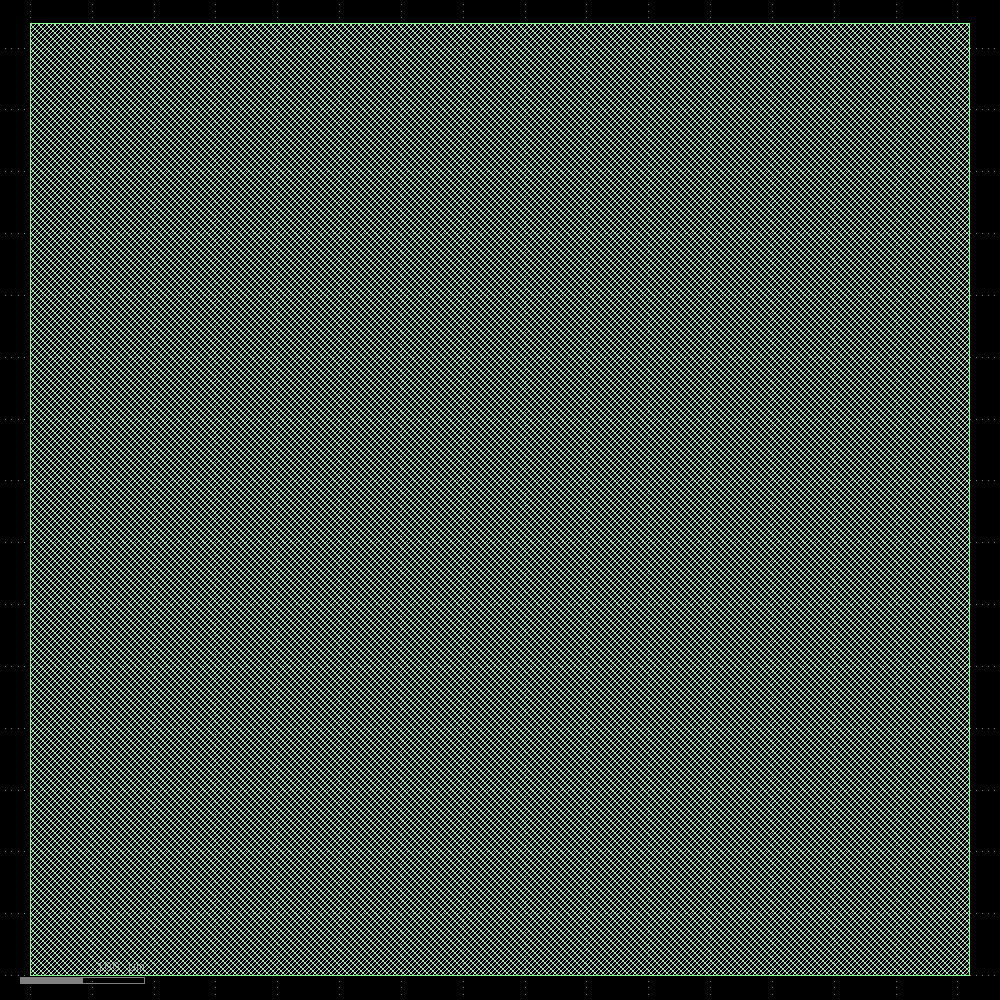

In [30]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [31]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[17:53:51] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=333636;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=841165;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:53:51] VERBOSE  Logging subprocess to                                                              ]8;id=31631;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=694944;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=733544;file:///content/openlane_run/5-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=648619;file:///content/openlane_run/5-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\5]8;;\]8;id=733544;file:///content/openlane_run/5-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                    

Reading OpenROAD database at '/content/openlane_run/4-openroad-floorplan/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 550 endcaps.

[INFO TAP-0005] Inserted 7894 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/5-openroad-tapendcapinsertion/neuron.odb'…

Writing netlist to '/content/openlane_run/5-openroad-tapendcapinsertion/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/5-openroad-tapendcapinsertion/neuron.pnl.v'…

Writing layout to '/content/openlane_run/5-openroad-tapendcapinsertion/neuron.def'…

Writing timing constraints to '/content/openlane_run/5-openroad-tapendcapinsertion/neuron.sdc'…

{'nl': Path('/content/openlane_run/5-openroad-tapendcapinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/5-openroad-tapendcapinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/5-openroad-tapendcapinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/5-openroad-tapendcapinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/5-openroad-tapendcapinsertion/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36222, 'design__instance__area': 289993, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 323, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36222, 'design__instance__area__stdcell': 289993, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.518013'), 'design__instance__utilization__stdcell': Decimal('0.518013')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:53:55] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=219016;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=894784;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:53:55] VERBOSE  Logging subprocess to ]8;id=714675;file:///tmp/openlane_klayout_tmp_l_gddbn1/klayout-render.log\..]8;;\]8;id=222525;file:///tmp/openlane_klayout_tmp_l_gddbn1/klayout-render.log\/tmp/openlane_klayout_tmp_l_gddbn1/]8;;\]8;id=582073;file:///tmp/openlane_klayout_tmp_l_gddbn1/klayout-render.log\klayout-render.log]8;;\…     ]8;id=314412;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=832993;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.64s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
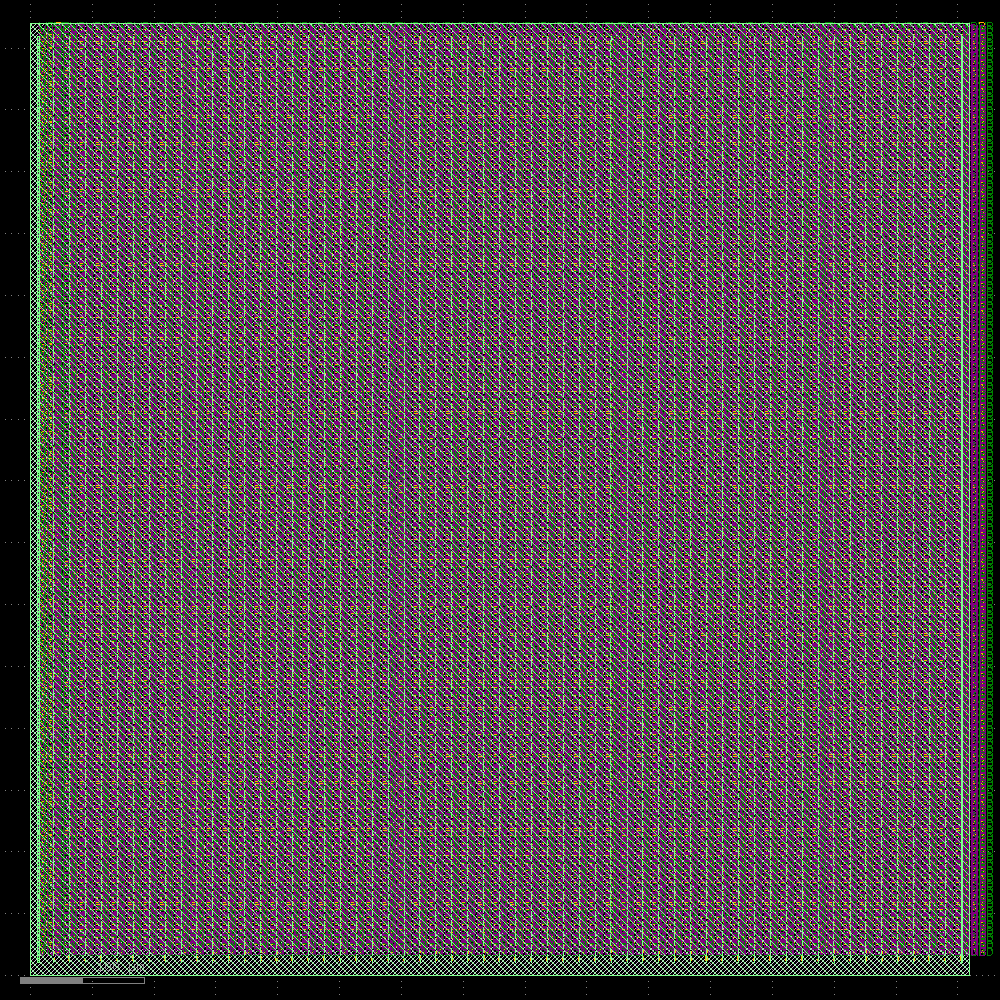

In [32]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [33]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[17:53:57] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=59420;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=748108;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:53:57] VERBOSE  Logging subprocess to                                                              ]8;id=565042;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=32568;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=891615;file:///content/openlane_run/6-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=35557;file:///content/openlane_run/6-openroad-ioplacement/openroad-ioplacement.log\6]8;;\]8;id=891615;file:///content/openlane_run/6-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                  

Reading OpenROAD database at '/content/openlane_run/5-openroad-tapendcapinsertion/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           926

[INFO PPL-0002] Number of I/O             323

[INFO PPL-0003] Number of I/O w/sink      323

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 170126.30 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/6-openroad-ioplacement/neuron.odb'…

Writing netlist to '/content/openlane_run/6-openroad-ioplacement/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/6-openroad-ioplacement/neuron.pnl.v'…

Writing layout to '/content/openlane_run/6-openroad-ioplacement/neuron.def'…

Writing timing constraints to '/content/openlane_run/6-openroad-ioplacement/neuron.sdc'…

{'nl': Path('/content/openlane_run/6-openroad-ioplacement/neuron.nl.v'), 'pnl': Path('/content/openlane_run/6-openroad-ioplacement/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/6-openroad-ioplacement/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/6-openroad-ioplacement/neuron.odb'), 'sdc': Path('/content/openlane_run/6-openroad-ioplacement/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36222, 'design__instance__area': 289993, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 323, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36222, 'design__instance__area__stdcell': 289993, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.518013'), 'design__instance__utilization__stdcell': Decimal('0.518013'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:54:01] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=988113;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=30314;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:54:01] VERBOSE  Logging subprocess to ]8;id=731128;file:///tmp/openlane_klayout_tmp_f_5h7dn8/klayout-render.log\..]8;;\]8;id=904682;file:///tmp/openlane_klayout_tmp_f_5h7dn8/klayout-render.log\/tmp/openlane_klayout_tmp_f_5h7dn8/]8;;\]8;id=997263;file:///tmp/openlane_klayout_tmp_f_5h7dn8/klayout-render.log\klayout-render.log]8;;\…     ]8;id=143297;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=422431;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.95s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
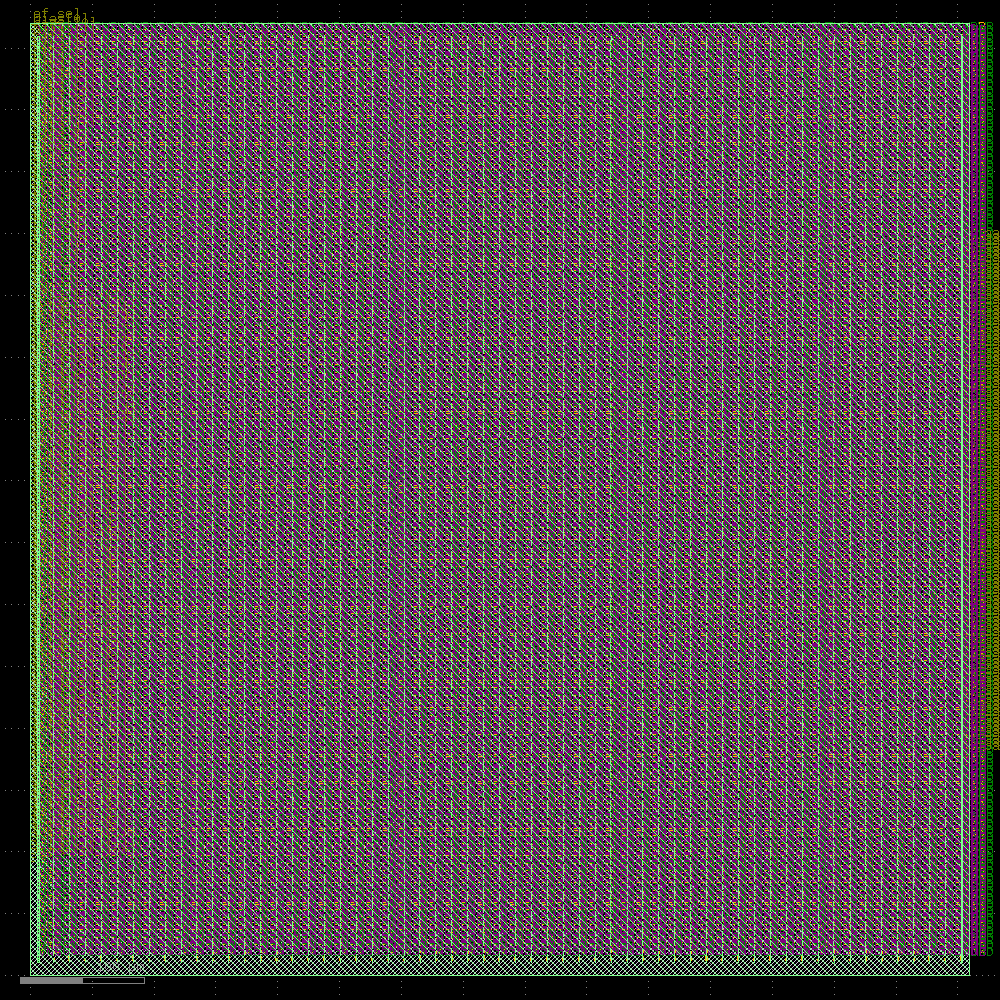

In [34]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [35]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=3,
    FP_PDN_HWIDTH=3,
    FP_PDN_VPITCH=40,
    FP_PDN_HPITCH=40,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[17:54:03] VERBOSE  Running 'OpenROAD.GeneratePDN'…                                                    ]8;id=500129;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=361956;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:54:03] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=931932;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=104399;file:///content/openlane_ipynb/openlane/steps/openroad.py#1174\1174]8;;\
                    /content/openlane_ipynb/openlane/scripts/openroad/common/pdn_cfg.tcl…                          

[17:54:03] VERBOSE  Logging subprocess to                                                              ]8;id=794855;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=303378;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=737358;file:///content/openlane_run/7-openroad-generatepdn/openroad-generatepdn.log\openlane_run/]8;;\]8;id=834957;file:///content/openlane_run/7-openroad-generatepdn/openroad-generatepdn.log\7]8;;\]8;id=737358;file:///content/openlane_run/7-openroad-generatepdn/openroad-generatepdn.log\-openroad-generatepdn/openroad-generatepdn.log]8;;\…                                  

Reading OpenROAD database at '/content/openlane_run/6-openroad-ioplacement/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/7-openroad-generatepdn/neuron.odb'…

Writing netlist to '/content/openlane_run/7-openroad-generatepdn/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/7-openroad-generatepdn/neuron.pnl.v'…

Writing layout to '/content/openlane_run/7-openroad-generatepdn/neuron.def'…

Writing timing constraints to '/content/openlane_run/7-openroad-generatepdn/neuron.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/openlane_run/7-openroad-generatepdn/neuron.nl.v'), 'pnl': Path('/content/openlane_run/7-openroad-generatepdn/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/7-openroad-generatepdn/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/7-openroad-generatepdn/neuron.odb'), 'sdc': Path('/content/openlane_run/7-openroad-generatepdn/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36222, 'design__instance__area': 289993, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36222, 'design__instance__area__stdcell': 289993, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.518013'), 'design__instance__utilization__stdcell': Decimal('0.518013'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:54:09] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=747996;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=574145;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:54:09] VERBOSE  Logging subprocess to ]8;id=690338;file:///tmp/openlane_klayout_tmp_ad2imncg/klayout-render.log\..]8;;\]8;id=816309;file:///tmp/openlane_klayout_tmp_ad2imncg/klayout-render.log\/tmp/openlane_klayout_tmp_ad2imncg/]8;;\]8;id=785500;file:///tmp/openlane_klayout_tmp_ad2imncg/klayout-render.log\klayout-render.log]8;;\…     ]8;id=574801;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=420224;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 5.36s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
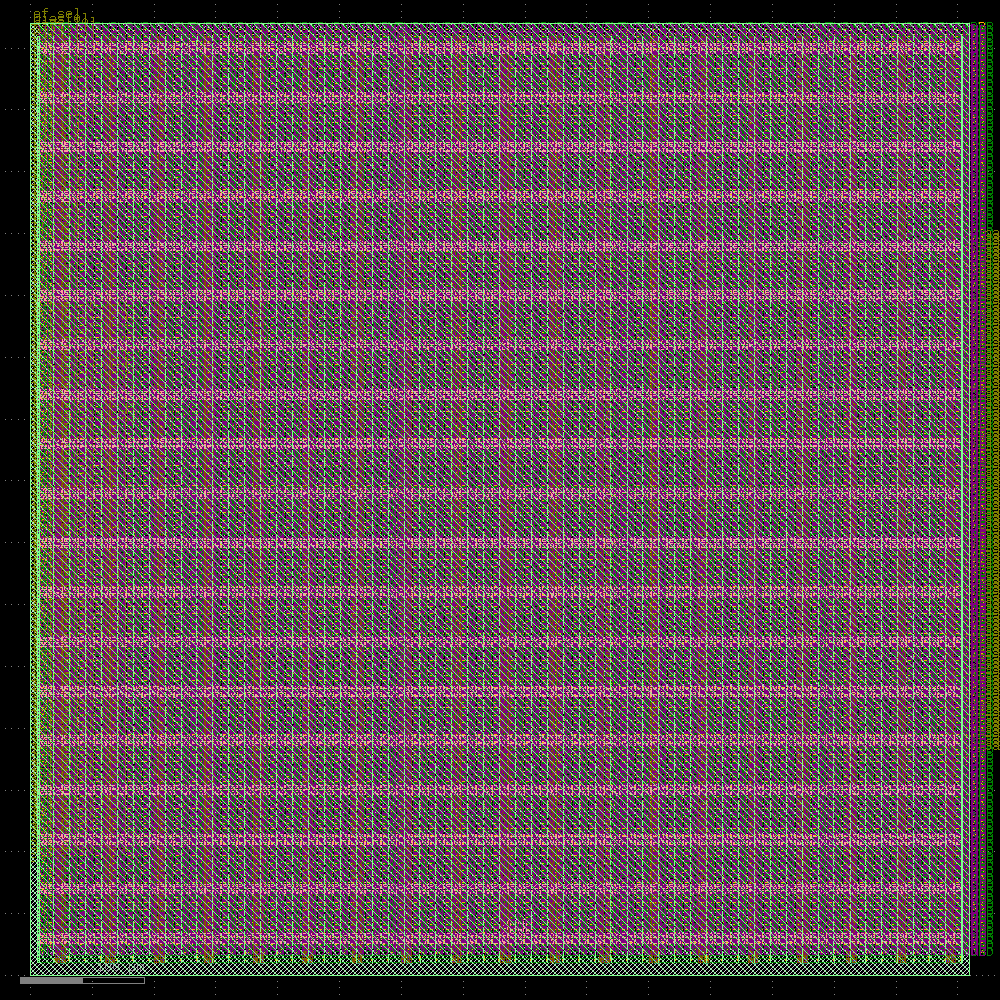

In [36]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [37]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[17:54:11] VERBOSE  Running 'OpenROAD.GlobalPlacement'…                                                ]8;id=461142;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=709058;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:54:11] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=90866;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=811624;file:///content/openlane_ipynb/openlane/steps/openroad.py#1260\1260]8;;\
                    target density: 61.801300…                                                                     

[17:54:11] VERBOSE  Logging subprocess to                                                              ]8;id=304625;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=439966;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=236577;file:///content/openlane_run/8-openroad-globalplacement/openroad-globalplacement.log\openlane_run/]8;;\]8;id=562612;file:///content/openlane_run/8-openroad-globalplacement/openroad-globalplacement.log\8]8;;\]8;id=236577;file:///content/openlane_run/8-openroad-globalplacement/openroad-globalplacement.log\-openroad-globalplacement/openroad-globalplacement.log]8;;\…                          

Reading OpenROAD database at '/content/openlane_run/7-openroad-generatepdn/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 753.940 758.880 ) um

[INFO GPL-0006] NumInstances:             36772

[INFO GPL-0007] NumPlaceInstances:        28328

[INFO GPL-0008] NumFixedInstances:         8444

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                  28619

[INFO GPL-0011] NumPins:                 104450

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 759.525 770.245 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 753.940 758.880 ) um

[INFO GPL-0016] CoreArea:            559818.160 um^2

[INFO GPL-0017] NonPlaceInstsArea:    11941.453 um^2

[INFO GPL-0018] PlaceInstsArea:      280116.154 um^2

[INFO GPL-0019] Util:                    51.128 %

[INFO GPL-0020] StdInstsArea:        280116.154 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00423061 HPWL: 438888295

[InitialPlace]  Iter: 2 CG residual: 0.00318735 HPWL: 400539837

[InitialPlace]  Iter: 3 CG residual: 0.00397625 HPWL: 400588857

[InitialPlace]  Iter: 4 CG residual: 0.00352986 HPWL: 399400303

[InitialPlace]  Iter: 5 CG residual: 0.00872972 HPWL: 398099913

[InitialPlace]  Iter: 6 CG residual: 0.00391811 HPWL: 401649082

[InitialPlace]  Iter: 7 CG residual: 0.00398062 HPWL: 400308711

[InitialPlace]  Iter: 8 CG residual: 0.00389751 HPWL: 399763414

[InitialPlace]  Iter: 9 CG residual: 0.00354016 HPWL: 398624334

[InitialPlace]  Iter: 10 CG residual: 0.00453186 HPWL: 397737812

[InitialPlace]  Iter: 11 CG residual: 0.00345269 HPWL: 396277226

[InitialPlace]  Iter: 12 CG residual: 0.00366466 HPWL: 395451885

[InitialPlace]  Iter: 13 CG residual: 0.00354789 HPWL: 393907759

[InitialPlace]  Iter: 14 CG residual: 0.00410015 HPWL: 392966279

[InitialPlace]  Iter: 15 CG residual: 0.00341692 HPWL: 391670268

[InitialPlace]  Iter: 16 CG residual: 0.00382349 HPWL: 391138456

[InitialPlace]  Iter: 17 CG residual: 0.00352075 HPWL: 389510551

[InitialPlace]  Iter: 18 CG residual: 0.00297905 HPWL: 388753319

[InitialPlace]  Iter: 19 CG residual: 0.00355391 HPWL: 387107747

[InitialPlace]  Iter: 20 CG residual: 0.00336363 HPWL: 386162671

[INFO GPL-0031] FillerInit:NumGCells:     34451

[INFO GPL-0032] FillerInit:NumGNets:      28619

[INFO GPL-0033] FillerInit:NumGPins:     104450

[INFO GPL-0023] TargetDensity:            0.618

[INFO GPL-0024] AvrgPlaceInstArea:        9.888 um^2

[INFO GPL-0025] IdealBinArea:            16.000 um^2

[INFO GPL-0026] IdealBinCnt:              34988

[INFO GPL-0027] TotalBinArea:        559818.160 um^2

[INFO GPL-0028] BinCnt:       128    128

[INFO GPL-0029] BinSize: (  5.848  5.844 )

[INFO GPL-0030] NumBins: 16384

[NesterovSolve] Iter:    1 overflow: 0.970 HPWL: 252446319

[NesterovSolve] Iter:   10 overflow: 0.960 HPWL: 224862332

[NesterovSolve] Iter:   20 overflow: 0.959 HPWL: 238311428

[NesterovSolve] Iter:   30 overflow: 0.957 HPWL: 249271692

[NesterovSolve] Iter:   40 overflow: 0.957 HPWL: 258258674

[NesterovSolve] Iter:   50 overflow: 0.956 HPWL: 266882388

[NesterovSolve] Iter:   60 overflow: 0.956 HPWL: 274304509

[NesterovSolve] Iter:   70 overflow: 0.956 HPWL: 278800858

[NesterovSolve] Iter:   80 overflow: 0.955 HPWL: 280348602

[NesterovSolve] Iter:   90 overflow: 0.955 HPWL: 279991689

[NesterovSolve] Iter:  100 overflow: 0.954 HPWL: 278466860

[NesterovSolve] Iter:  110 overflow: 0.954 HPWL: 276342801

[NesterovSolve] Iter:  120 overflow: 0.954 HPWL: 274347960

[NesterovSolve] Iter:  130 overflow: 0.954 HPWL: 273363292

[NesterovSolve] Iter:  140 overflow: 0.953 HPWL: 274062968

[NesterovSolve] Iter:  150 overflow: 0.951 HPWL: 276899488

[NesterovSolve] Iter:  160 overflow: 0.949 HPWL: 282227720

[NesterovSolve] Iter:  170 overflow: 0.945 HPWL: 290396304

[NesterovSolve] Iter:  180 overflow: 0.938 HPWL: 301579639

[NesterovSolve] Iter:  190 overflow: 0.927 HPWL: 315685685

[NesterovSolve] Iter:  200 overflow: 0.913 HPWL: 332837219

[NesterovSolve] Iter:  210 overflow: 0.895 HPWL: 353937757

[NesterovSolve] Iter:  220 overflow: 0.873 HPWL: 378479011

[NesterovSolve] Iter:  230 overflow: 0.848 HPWL: 404770117

[NesterovSolve] Iter:  240 overflow: 0.818 HPWL: 433807107

[NesterovSolve] Iter:  250 overflow: 0.783 HPWL: 464097845

[INFO GPL-0100] worst slack -4.66e-09

[INFO GPL-0103] Weighted 2859 nets.

[NesterovSolve] Iter:  260 overflow: 0.748 HPWL: 496508794

[NesterovSolve] Iter:  270 overflow: 0.704 HPWL: 523014005

[NesterovSolve] Iter:  280 overflow: 0.658 HPWL: 542745667

[INFO GPL-0100] worst slack -5.06e-09

[INFO GPL-0103] Weighted 2861 nets.

[NesterovSolve] Iter:  290 overflow: 0.607 HPWL: 555384331

[NesterovSolve] Snapshot saved at iter = 291

[NesterovSolve] Iter:  300 overflow: 0.551 HPWL: 561132205

[NesterovSolve] Iter:  310 overflow: 0.502 HPWL: 563254137

[INFO GPL-0100] worst slack -4.72e-09

[INFO GPL-0103] Weighted 2860 nets.

[NesterovSolve] Iter:  320 overflow: 0.459 HPWL: 565061120

[NesterovSolve] Iter:  330 overflow: 0.410 HPWL: 572467437

[NesterovSolve] Iter:  340 overflow: 0.370 HPWL: 574763915

[NesterovSolve] Iter:  350 overflow: 0.334 HPWL: 578346432

[NesterovSolve] Iter:  360 overflow: 0.309 HPWL: 578798144

[NesterovSolve] Iter:  370 overflow: 0.283 HPWL: 579541655

[INFO GPL-0100] worst slack -4.67e-09

[INFO GPL-0103] Weighted 2861 nets.

[NesterovSolve] Iter:  380 overflow: 0.258 HPWL: 580164373

[NesterovSolve] Iter:  390 overflow: 0.237 HPWL: 580294791

[NesterovSolve] Iter:  400 overflow: 0.214 HPWL: 580788421

[INFO GPL-0100] worst slack -4.34e-09

[INFO GPL-0103] Weighted 2860 nets.

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 5.200000762939453

[INFO GPL-0064] TotalRouteOverflowV2: 17.63333570957184

[INFO GPL-0065] OverflowTileCnt2: 148

[INFO GPL-0066] 0.5%RC: 1.1596

[INFO GPL-0067] 1.0%RC: 1.0820

[INFO GPL-0068] 2.0%RC: 1.0410

[INFO GPL-0069] 5.0%RC: 1.0031

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.1208

[INFO GPL-0078] FinalRC lower than minRC (1e+30), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:     4634.808 um^2

[INFO GPL-0046] TargetDensity:            0.618

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   280116.154 um^2

[INFO GPL-0051] TotalFillerArea:      58478.769 um^2

[INFO GPL-0052] TotalGCellsArea:     338594.922 um^2

[INFO GPL-0053] ExpectedGCellsArea:  343229.731 um^2

[INFO GPL-0054] NewTargetDensity:         0.626

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         343229.727 um^2

[INFO GPL-0057] NewNesterovInstArea: 284750.962 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.765 um^2

[INFO GPL-0059] NewTotalGCellsArea:  343229.727 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  410 overflow: 0.585 HPWL: 559283980

[NesterovSolve] Iter:  420 overflow: 0.537 HPWL: 557837392

[NesterovSolve] Iter:  430 overflow: 0.502 HPWL: 556139066

[NesterovSolve] Iter:  440 overflow: 0.473 HPWL: 558014963

[NesterovSolve] Iter:  450 overflow: 0.431 HPWL: 564142200

[NesterovSolve] Iter:  460 overflow: 0.394 HPWL: 565490738

[NesterovSolve] Iter:  470 overflow: 0.367 HPWL: 568584679

[NesterovSolve] Iter:  480 overflow: 0.342 HPWL: 571315038

[NesterovSolve] Iter:  490 overflow: 0.309 HPWL: 575619437

[NesterovSolve] Iter:  500 overflow: 0.284 HPWL: 576940007

[NesterovSolve] Iter:  510 overflow: 0.261 HPWL: 578496470

[NesterovSolve] Iter:  520 overflow: 0.237 HPWL: 580039994

[NesterovSolve] Iter:  530 overflow: 0.215 HPWL: 580614431

[INFO GPL-0075] Routability numCall: 2 inflationIterCnt: 2 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 2.6000003814697266

[INFO GPL-0064] TotalRouteOverflowV2: 9.13333547115326

[INFO GPL-0065] OverflowTileCnt2: 92

[INFO GPL-0066] 0.5%RC: 1.0846

[INFO GPL-0067] 1.0%RC: 1.0425

[INFO GPL-0068] 2.0%RC: 1.0212

[INFO GPL-0069] 5.0%RC: 1.0015

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0635

[INFO GPL-0078] FinalRC lower than minRC (1.1207917), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:     3354.117 um^2

[INFO GPL-0046] TargetDensity:            0.626

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   284750.962 um^2

[INFO GPL-0051] TotalFillerArea:      58478.765 um^2

[INFO GPL-0052] TotalGCellsArea:     343229.727 um^2

[INFO GPL-0053] ExpectedGCellsArea:  346583.844 um^2

[INFO GPL-0054] NewTargetDensity:         0.633

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         346583.859 um^2

[INFO GPL-0057] NewNesterovInstArea: 288105.079 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.780 um^2

[INFO GPL-0059] NewTotalGCellsArea:  346583.859 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  540 overflow: 0.587 HPWL: 559370916

[NesterovSolve] Iter:  550 overflow: 0.536 HPWL: 559109116

[NesterovSolve] Iter:  560 overflow: 0.501 HPWL: 557366462

[NesterovSolve] Iter:  570 overflow: 0.473 HPWL: 559175379

[NesterovSolve] Iter:  580 overflow: 0.431 HPWL: 565791026

[NesterovSolve] Iter:  590 overflow: 0.395 HPWL: 566817000

[NesterovSolve] Iter:  600 overflow: 0.367 HPWL: 569647401

[NesterovSolve] Iter:  610 overflow: 0.343 HPWL: 572593995

[NesterovSolve] Iter:  620 overflow: 0.310 HPWL: 577198533

[NesterovSolve] Iter:  630 overflow: 0.285 HPWL: 578012014

[NesterovSolve] Iter:  640 overflow: 0.261 HPWL: 579150524

[NesterovSolve] Iter:  650 overflow: 0.237 HPWL: 580600523

[NesterovSolve] Iter:  660 overflow: 0.215 HPWL: 581163415

[INFO GPL-0075] Routability numCall: 3 inflationIterCnt: 3 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 4.350000739097595

[INFO GPL-0064] TotalRouteOverflowV2: 9.966669201850891

[INFO GPL-0065] OverflowTileCnt2: 116

[INFO GPL-0066] 0.5%RC: 1.0923

[INFO GPL-0067] 1.0%RC: 1.0464

[INFO GPL-0068] 2.0%RC: 1.0232

[INFO GPL-0069] 5.0%RC: 1.0026

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0693

[INFO GPL-0079] MinRC (1.0635242) violation occurred, total count: 1.

[INFO GPL-0045] InflatedAreaDelta:     3600.398 um^2

[INFO GPL-0046] TargetDensity:            0.633

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   288105.079 um^2

[INFO GPL-0051] TotalFillerArea:      58478.780 um^2

[INFO GPL-0052] TotalGCellsArea:     346583.859 um^2

[INFO GPL-0053] ExpectedGCellsArea:  350184.257 um^2

[INFO GPL-0054] NewTargetDensity:         0.639

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         350184.243 um^2

[INFO GPL-0057] NewNesterovInstArea: 291705.477 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.766 um^2

[INFO GPL-0059] NewTotalGCellsArea:  350184.243 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  670 overflow: 0.582 HPWL: 561233717

[NesterovSolve] Iter:  680 overflow: 0.532 HPWL: 560149002

[NesterovSolve] Iter:  690 overflow: 0.497 HPWL: 558458598

[NesterovSolve] Iter:  700 overflow: 0.469 HPWL: 561469166

[NesterovSolve] Iter:  710 overflow: 0.426 HPWL: 567964078

[NesterovSolve] Iter:  720 overflow: 0.392 HPWL: 568206848

[NesterovSolve] Iter:  730 overflow: 0.363 HPWL: 571451094

[NesterovSolve] Iter:  740 overflow: 0.340 HPWL: 574697580

[NesterovSolve] Iter:  750 overflow: 0.307 HPWL: 578872245

[NesterovSolve] Iter:  760 overflow: 0.283 HPWL: 579909950

[NesterovSolve] Iter:  770 overflow: 0.258 HPWL: 580885350

[NesterovSolve] Iter:  780 overflow: 0.235 HPWL: 582373106

[NesterovSolve] Iter:  790 overflow: 0.213 HPWL: 582735808

[INFO GPL-0075] Routability numCall: 4 inflationIterCnt: 4 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 3.4500004053115845

[INFO GPL-0064] TotalRouteOverflowV2: 10.60000216960907

[INFO GPL-0065] OverflowTileCnt2: 102

[INFO GPL-0066] 0.5%RC: 1.0981

[INFO GPL-0067] 1.0%RC: 1.0493

[INFO GPL-0068] 2.0%RC: 1.0247

[INFO GPL-0069] 5.0%RC: 1.0020

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0737

[INFO GPL-0079] MinRC (1.0635242) violation occurred, total count: 2.

[INFO GPL-0045] InflatedAreaDelta:     3819.934 um^2

[INFO GPL-0046] TargetDensity:            0.639

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   291705.477 um^2

[INFO GPL-0051] TotalFillerArea:      58478.766 um^2

[INFO GPL-0052] TotalGCellsArea:     350184.243 um^2

[INFO GPL-0053] ExpectedGCellsArea:  354004.178 um^2

[INFO GPL-0054] NewTargetDensity:         0.646

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         354004.173 um^2

[INFO GPL-0057] NewNesterovInstArea: 295525.412 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.761 um^2

[INFO GPL-0059] NewTotalGCellsArea:  354004.173 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  800 overflow: 0.576 HPWL: 561876040

[NesterovSolve] Iter:  810 overflow: 0.527 HPWL: 561641356

[NesterovSolve] Iter:  820 overflow: 0.495 HPWL: 559753514

[NesterovSolve] Iter:  830 overflow: 0.465 HPWL: 563845675

[NesterovSolve] Iter:  840 overflow: 0.423 HPWL: 570280615

[NesterovSolve] Iter:  850 overflow: 0.388 HPWL: 570432538

[NesterovSolve] Iter:  860 overflow: 0.361 HPWL: 573451169

[NesterovSolve] Iter:  870 overflow: 0.338 HPWL: 577041405

[NesterovSolve] Iter:  880 overflow: 0.305 HPWL: 580663758

[NesterovSolve] Iter:  890 overflow: 0.280 HPWL: 581543727

[NesterovSolve] Iter:  900 overflow: 0.255 HPWL: 582378303

[NesterovSolve] Iter:  910 overflow: 0.231 HPWL: 584154311

[NesterovSolve] Iter:  920 overflow: 0.210 HPWL: 584659871

[INFO GPL-0075] Routability numCall: 5 inflationIterCnt: 0 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 2.2500003576278687

[INFO GPL-0064] TotalRouteOverflowV2: 7.833335280418396

[INFO GPL-0065] OverflowTileCnt2: 79

[INFO GPL-0066] 0.5%RC: 1.0725

[INFO GPL-0067] 1.0%RC: 1.0364

[INFO GPL-0068] 2.0%RC: 1.0182

[INFO GPL-0069] 5.0%RC: 1.0013

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0545

[INFO GPL-0078] FinalRC lower than minRC (1.0635242), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:     2639.305 um^2

[INFO GPL-0046] TargetDensity:            0.646

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   295525.412 um^2

[INFO GPL-0051] TotalFillerArea:      58478.761 um^2

[INFO GPL-0052] TotalGCellsArea:     354004.173 um^2

[INFO GPL-0053] ExpectedGCellsArea:  356643.478 um^2

[INFO GPL-0054] NewTargetDensity:         0.651

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         356643.471 um^2

[INFO GPL-0057] NewNesterovInstArea: 298164.717 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.754 um^2

[INFO GPL-0059] NewTotalGCellsArea:  356643.471 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  930 overflow: 0.569 HPWL: 563458750

[NesterovSolve] Iter:  940 overflow: 0.521 HPWL: 562556478

[NesterovSolve] Iter:  950 overflow: 0.492 HPWL: 560618591

[NesterovSolve] Iter:  960 overflow: 0.460 HPWL: 565705555

[NesterovSolve] Iter:  970 overflow: 0.418 HPWL: 571490214

[NesterovSolve] Iter:  980 overflow: 0.384 HPWL: 571768338

[NesterovSolve] Iter:  990 overflow: 0.358 HPWL: 574699048

[NesterovSolve] Iter: 1000 overflow: 0.333 HPWL: 578625066

[NesterovSolve] Iter: 1010 overflow: 0.303 HPWL: 581801626

[NesterovSolve] Iter: 1020 overflow: 0.277 HPWL: 582459532

[NesterovSolve] Iter: 1030 overflow: 0.254 HPWL: 583437820

[NesterovSolve] Iter: 1040 overflow: 0.229 HPWL: 585145653

[NesterovSolve] Iter: 1050 overflow: 0.208 HPWL: 585686369

[INFO GPL-0075] Routability numCall: 6 inflationIterCnt: 1 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 2.000000476837158

[INFO GPL-0064] TotalRouteOverflowV2: 7.066668391227722

[INFO GPL-0065] OverflowTileCnt2: 73

[INFO GPL-0066] 0.5%RC: 1.0654

[INFO GPL-0067] 1.0%RC: 1.0329

[INFO GPL-0068] 2.0%RC: 1.0164

[INFO GPL-0069] 5.0%RC: 1.0012

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0492

[INFO GPL-0078] FinalRC lower than minRC (1.0544825), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:     2562.018 um^2

[INFO GPL-0046] TargetDensity:            0.651

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   298164.717 um^2

[INFO GPL-0051] TotalFillerArea:      58478.754 um^2

[INFO GPL-0052] TotalGCellsArea:     356643.471 um^2

[INFO GPL-0053] ExpectedGCellsArea:  359205.489 um^2

[INFO GPL-0054] NewTargetDensity:         0.656

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         359205.503 um^2

[INFO GPL-0057] NewNesterovInstArea: 300726.735 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.768 um^2

[INFO GPL-0059] NewTotalGCellsArea:  359205.503 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1060 overflow: 0.569 HPWL: 564086883

[NesterovSolve] Iter: 1070 overflow: 0.520 HPWL: 563486353

[NesterovSolve] Iter: 1080 overflow: 0.491 HPWL: 561544099

[NesterovSolve] Iter: 1090 overflow: 0.459 HPWL: 566348569

[NesterovSolve] Iter: 1100 overflow: 0.418 HPWL: 572510888

[NesterovSolve] Iter: 1110 overflow: 0.383 HPWL: 573002718

[NesterovSolve] Iter: 1120 overflow: 0.358 HPWL: 576074499

[NesterovSolve] Iter: 1130 overflow: 0.335 HPWL: 579582885

[NesterovSolve] Iter: 1140 overflow: 0.302 HPWL: 582971470

[NesterovSolve] Iter: 1150 overflow: 0.277 HPWL: 583964364

[NesterovSolve] Iter: 1160 overflow: 0.253 HPWL: 585031097

[NesterovSolve] Iter: 1170 overflow: 0.229 HPWL: 586227930

[NesterovSolve] Iter: 1180 overflow: 0.208 HPWL: 586767403

[INFO GPL-0075] Routability numCall: 7 inflationIterCnt: 2 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 2.500000476837158

[INFO GPL-0064] TotalRouteOverflowV2: 7.2666685581207275

[INFO GPL-0065] OverflowTileCnt2: 82

[INFO GPL-0066] 0.5%RC: 1.0673

[INFO GPL-0067] 1.0%RC: 1.0338

[INFO GPL-0068] 2.0%RC: 1.0169

[INFO GPL-0069] 5.0%RC: 1.0015

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0505

[INFO GPL-0079] MinRC (1.0491502) violation occurred, total count: 1.

[INFO GPL-0045] InflatedAreaDelta:     2445.758 um^2

[INFO GPL-0046] TargetDensity:            0.656

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   300726.735 um^2

[INFO GPL-0051] TotalFillerArea:      58478.768 um^2

[INFO GPL-0052] TotalGCellsArea:     359205.503 um^2

[INFO GPL-0053] ExpectedGCellsArea:  361651.261 um^2

[INFO GPL-0054] NewTargetDensity:         0.660

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         361651.274 um^2

[INFO GPL-0057] NewNesterovInstArea: 303172.493 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.781 um^2

[INFO GPL-0059] NewTotalGCellsArea:  361651.274 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1190 overflow: 0.562 HPWL: 565470336

[NesterovSolve] Iter: 1200 overflow: 0.515 HPWL: 564848491

[NesterovSolve] Iter: 1210 overflow: 0.489 HPWL: 562790101

[NesterovSolve] Iter: 1220 overflow: 0.455 HPWL: 568388757

[NesterovSolve] Iter: 1230 overflow: 0.415 HPWL: 574065981

[NesterovSolve] Iter: 1240 overflow: 0.381 HPWL: 574325909

[NesterovSolve] Iter: 1250 overflow: 0.355 HPWL: 577202080

[NesterovSolve] Iter: 1260 overflow: 0.332 HPWL: 581149919

[NesterovSolve] Iter: 1270 overflow: 0.299 HPWL: 583883896

[NesterovSolve] Iter: 1280 overflow: 0.274 HPWL: 584661129

[NesterovSolve] Iter: 1290 overflow: 0.250 HPWL: 585991618

[NesterovSolve] Iter: 1300 overflow: 0.228 HPWL: 587274172

[NesterovSolve] Iter: 1310 overflow: 0.207 HPWL: 587746044

[INFO GPL-0075] Routability numCall: 8 inflationIterCnt: 3 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 4.4000004529953

[INFO GPL-0064] TotalRouteOverflowV2: 7.500001549720764

[INFO GPL-0065] OverflowTileCnt2: 84

[INFO GPL-0066] 0.5%RC: 1.0694

[INFO GPL-0067] 1.0%RC: 1.0349

[INFO GPL-0068] 2.0%RC: 1.0174

[INFO GPL-0069] 5.0%RC: 1.0026

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0522

[INFO GPL-0079] MinRC (1.0491502) violation occurred, total count: 2.

[INFO GPL-0045] InflatedAreaDelta:     3019.106 um^2

[INFO GPL-0046] TargetDensity:            0.660

[INFO GPL-0049] WhiteSpaceArea:      547876.707 um^2

[INFO GPL-0050] NesterovInstsArea:   303172.493 um^2

[INFO GPL-0051] TotalFillerArea:      58478.781 um^2

[INFO GPL-0052] TotalGCellsArea:     361651.274 um^2

[INFO GPL-0053] ExpectedGCellsArea:  364670.380 um^2

[INFO GPL-0054] NewTargetDensity:         0.666

[INFO GPL-0055] NewWhiteSpaceArea:   547876.707 um^2

[INFO GPL-0056] MovableArea:         364670.386 um^2

[INFO GPL-0057] NewNesterovInstArea: 306191.599 um^2

[INFO GPL-0058] NewTotalFillerArea:   58478.787 um^2

[INFO GPL-0059] NewTotalGCellsArea:  364670.386 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1320 overflow: 0.556 HPWL: 567125350

[NesterovSolve] Iter: 1330 overflow: 0.512 HPWL: 566034184

[NesterovSolve] Iter: 1340 overflow: 0.486 HPWL: 563945139

[NesterovSolve] Iter: 1350 overflow: 0.451 HPWL: 570225627

[NesterovSolve] Iter: 1360 overflow: 0.410 HPWL: 575205322

[NesterovSolve] Iter: 1370 overflow: 0.380 HPWL: 575495866

[NesterovSolve] Iter: 1380 overflow: 0.352 HPWL: 578602654

[NesterovSolve] Iter: 1390 overflow: 0.327 HPWL: 582959000

[NesterovSolve] Iter: 1400 overflow: 0.298 HPWL: 584910973

[NesterovSolve] Iter: 1410 overflow: 0.272 HPWL: 585562307

[NesterovSolve] Iter: 1420 overflow: 0.249 HPWL: 586740840

[NesterovSolve] Iter: 1430 overflow: 0.226 HPWL: 587842311

[NesterovSolve] Iter: 1440 overflow: 0.205 HPWL: 588400061

[INFO GPL-0075] Routability numCall: 9 inflationIterCnt: 4 bloatIterCnt: 1

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:     110  111

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 12210

[INFO GPL-0063] TotalRouteOverflowH2: 3.0500004291534424

[INFO GPL-0064] TotalRouteOverflowV2: 7.500001788139343

[INFO GPL-0065] OverflowTileCnt2: 88

[INFO GPL-0066] 0.5%RC: 1.0694

[INFO GPL-0067] 1.0%RC: 1.0349

[INFO GPL-0068] 2.0%RC: 1.0174

[INFO GPL-0069] 5.0%RC: 1.0018

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0522

[INFO GPL-0079] MinRC (1.0491502) violation occurred, total count: 3.

[INFO GPL-0045] InflatedAreaDelta:     2419.333 um^2

[INFO GPL-0046] TargetDensity:            0.666

Revert Routability Procedure. Target density higher than max, or minRC max violations.

[INFO GPL-0080] minRcViolatedCnt: 3

[INFO GPL-0047] SavedMinRC: 1.0492

[INFO GPL-0048] SavedTargetDensity: 0.6510

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1450 overflow: 0.547 HPWL: 560011239

[NesterovSolve] Iter: 1460 overflow: 0.507 HPWL: 557344900

[NesterovSolve] Iter: 1470 overflow: 0.481 HPWL: 557926089

[NesterovSolve] Iter: 1480 overflow: 0.443 HPWL: 565504189

[NesterovSolve] Iter: 1490 overflow: 0.404 HPWL: 569804001

[NesterovSolve] Iter: 1500 overflow: 0.372 HPWL: 570434265

[NesterovSolve] Iter: 1510 overflow: 0.347 HPWL: 573546014

[NesterovSolve] Iter: 1520 overflow: 0.321 HPWL: 578557294

[NesterovSolve] Iter: 1530 overflow: 0.291 HPWL: 580923804

[NesterovSolve] Iter: 1540 overflow: 0.268 HPWL: 581938653

[NesterovSolve] Iter: 1550 overflow: 0.244 HPWL: 583346026

[NesterovSolve] Iter: 1560 overflow: 0.221 HPWL: 584546349

[NesterovSolve] Iter: 1570 overflow: 0.200 HPWL: 585349443

[NesterovSolve] Iter: 1580 overflow: 0.180 HPWL: 585789845

[NesterovSolve] Iter: 1590 overflow: 0.159 HPWL: 586161039

[INFO GPL-0100] worst slack -4.73e-09

[INFO GPL-0103] Weighted 2861 nets.

[NesterovSolve] Iter: 1600 overflow: 0.140 HPWL: 586361835

[NesterovSolve] Iter: 1610 overflow: 0.122 HPWL: 587501987

[NesterovSolve] Iter: 1620 overflow: 0.107 HPWL: 588587357

[NesterovSolve] Finished with Overflow: 0.099306

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/8-openroad-globalplacement/neuron.odb'…

Writing netlist to '/content/openlane_run/8-openroad-globalplacement/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/8-openroad-globalplacement/neuron.pnl.v'…

Writing layout to '/content/openlane_run/8-openroad-globalplacement/neuron.def'…

Writing timing constraints to '/content/openlane_run/8-openroad-globalplacement/neuron.sdc'…

{'nl': Path('/content/openlane_run/8-openroad-globalplacement/neuron.nl.v'), 'pnl': Path('/content/openlane_run/8-openroad-globalplacement/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/8-openroad-globalplacement/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/8-openroad-globalplacement/neuron.odb'), 'sdc': Path('/content/openlane_run/8-openroad-globalplacement/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36222, 'design__instance__area': 289993, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36222, 'design__instance__area__stdcell': 289993, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.518013'), 'design__instance__utilization__stdcell': Decimal('0.518013'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

In [38]:
display(gpl)

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:57:21] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=905911;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=755598;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:57:21] VERBOSE  Logging subprocess to ]8;id=605150;file:///tmp/openlane_klayout_tmp_r6798aoi/klayout-render.log\..]8;;\]8;id=14056;file:///tmp/openlane_klayout_tmp_r6798aoi/klayout-render.log\/tmp/openlane_klayout_tmp_r6798aoi/]8;;\]8;id=154036;file:///tmp/openlane_klayout_tmp_r6798aoi/klayout-render.log\klayout-render.log]8;;\…     ]8;id=928108;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=375197;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 189.68s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:


### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [39]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[17:57:25] VERBOSE  Running 'OpenROAD.DetailedPlacement'…                                              ]8;id=876073;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=146976;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:57:25] VERBOSE  Logging subprocess to                                                              ]8;id=526317;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=295448;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=243930;file:///content/openlane_run/9-openroad-detailedplacement/openroad-detailedplacement.log\openlane_run/]8;;\]8;id=57529;file:///content/openlane_run/9-openroad-detailedplacement/openroad-detailedplacement.log\9]8;;\]8;id=243930;file:///content/openlane_run/9-openroad-detailedplacement/openroad-detailedplacement.log\-openroad-detailedplacement/openroad-detailedplacement.log]8;;\…                      

Reading OpenROAD database at '/content/openlane_run/8-openroad-globalplacement/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Placement Analysis

---------------------------------

total displacement      75520.7 u

average displacement        2.1 u

max displacement           12.4 u

original HPWL          589544.5 u

legalized HPWL         674764.5 u

delta HPWL                   14 %

[INFO DPL-0020] Mirrored 10914 instances

[INFO DPL-0021] HPWL before          674764.5 u

[INFO DPL-0022] HPWL after           653472.2 u

[INFO DPL-0023] HPWL delta               -3.2 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/9-openroad-detailedplacement/neuron.odb'…

Writing netlist to '/content/openlane_run/9-openroad-detailedplacement/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/9-openroad-detailedplacement/neuron.pnl.v'…

Writing layout to '/content/openlane_run/9-openroad-detailedplacement/neuron.def'…

Writing timing constraints to '/content/openlane_run/9-openroad-detailedplacement/neuron.sdc'…

{'nl': Path('/content/openlane_run/9-openroad-detailedplacement/neuron.nl.v'), 'pnl': Path('/content/openlane_run/9-openroad-detailedplacement/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/9-openroad-detailedplacement/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/9-openroad-detailedplacement/neuron.odb'), 'sdc': Path('/content/openlane_run/9-openroad-detailedplacement/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36222, 'design__instance__area': 289993, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36222, 'design__instance__area__stdcell': 289993, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.518013'), 'design__instance__utilization__stdcell': Decimal('0.518013'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('75520.7'), 'design__instance__displacement__mean': Decimal('2.053'), 'design__instance__displacement__max': Decimal('12.412'), 'route__wirelength__estimated': 674765, 'design__violations': 0}}

In [40]:
display(dpl)

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:57:28] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=651719;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=410768;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:57:28] VERBOSE  Logging subprocess to ]8;id=587328;file:///tmp/openlane_klayout_tmp_epd9dnlr/klayout-render.log\..]8;;\]8;id=170194;file:///tmp/openlane_klayout_tmp_epd9dnlr/klayout-render.log\/tmp/openlane_klayout_tmp_epd9dnlr/]8;;\]8;id=770344;file:///tmp/openlane_klayout_tmp_epd9dnlr/klayout-render.log\klayout-render.log]8;;\…     ]8;id=607212;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=121139;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.64s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:


### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [41]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[17:57:31] VERBOSE  Running 'OpenROAD.CTS'…                                                            ]8;id=993933;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=157601;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:57:31] VERBOSE  Logging subprocess to ]8;id=955305;file:///content/openlane_run/10-openroad-cts/openroad-cts.log\openlane_run/]8;;\]8;id=46610;file:///content/openlane_run/10-openroad-cts/openroad-cts.log\10]8;;\]8;id=955305;file:///content/openlane_run/10-openroad-cts/openroad-cts.log\-openroad-cts/openroad-cts.log]8;;\…               ]8;id=927394;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=271336;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/openlane_run/9-openroad-detailedplacement/neuron.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 636 sinks.

[INFO CTS-0008] TritonCTS found 1 clock nets.

[INFO CTS-0097] Characterization used 3 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 636.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0204] A clustering solution was found from clustering size of 25 and clustering diameter of 50.

[INFO CTS-0205] Better solution may be possible if either -sink_clustering_size, -sink_clustering_max_diameter, or 
both options are omitted to enable automatic clustering.

[INFO CTS-0019]  Total number of sinks after clustering: 119.

[INFO CTS-0024]  Normalized sink region: [(0.526838, 8.29853), (55.3158, 55.0447)].

[INFO CTS-0025]     Width:  54.7890.

[INFO CTS-0026]     Height: 46.7462.

Level 1

Direction: Horizontal

Sinks per sub-region: 60

Sub-region size: 27.3945 X 46.7462

[INFO CTS-0034]     Segment length (rounded): 14.

Level 2

Direction: Vertical

Sinks per sub-region: 30

Sub-region size: 27.3945 X 23.3731

[INFO CTS-0034]     Segment length (rounded): 12.

Level 3

Direction: Horizontal

Sinks per sub-region: 15

Sub-region size: 13.6972 X 23.3731

[INFO CTS-0034]     Segment length (rounded): 6.

Level 4

Direction: Vertical

Sinks per sub-region: 8

Sub-region size: 13.6972 X 11.6866

[INFO CTS-0034]     Segment length (rounded): 6.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 119.

[INFO CTS-0018]     Created 126 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 3.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 4.

[INFO CTS-0015]     Created 126 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 2:17, 3:21, 4:11, 5:11, 6:10, 7:15, 8:7, 9:10,     
10:3, 11:4, 12:3, 13:3, 14:5, 15:1..

[INFO CTS-0017]     Max level of the clock tree: 4.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 734

[INFO CTS-0100]  Leaf buffers 105

[INFO CTS-0101]  Average sink wire length 1112.33 um

[INFO CTS-0102]  Path depth 3 - 4

[INFO CTS-0207]  Leaf load cells 98

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/10-openroad-cts/neuron.odb'…

Writing netlist to '/content/openlane_run/10-openroad-cts/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/10-openroad-cts/neuron.pnl.v'…

Writing layout to '/content/openlane_run/10-openroad-cts/neuron.def'…

Writing timing constraints to '/content/openlane_run/10-openroad-cts/neuron.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement       1557.2 u

average displacement        0.0 u

max displacement           11.7 u

original HPWL          663246.0 u

legalized HPWL         685584.7 u

delta HPWL                    3 %

[INFO DPL-0020] Mirrored 10994 instances

[INFO DPL-0021] HPWL before          685584.7 u

[INFO DPL-0022] HPWL after           663908.9 u

[INFO DPL-0023] HPWL delta               -3.2 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/10-openroad-cts/neuron.odb'…

Writing netlist to '/content/openlane_run/10-openroad-cts/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/10-openroad-cts/neuron.pnl.v'…

Writing layout to '/content/openlane_run/10-openroad-cts/neuron.def'…

Writing timing constraints to '/content/openlane_run/10-openroad-cts/neuron.sdc'…

{'nl': Path('/content/openlane_run/10-openroad-cts/neuron.nl.v'), 'pnl': Path('/content/openlane_run/10-openroad-cts/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/10-openroad-cts/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/10-openroad-cts/neuron.odb'), 'sdc': Path('/content/openlane_run/10-openroad-cts/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 33696, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('1557.22'), 'design__instance__displacement__mean': Decimal('0.042'), 'design__instance__displacement__max': Decimal('11.745'), 'route__wirelength__estimated': 685585, 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[17:58:10] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=198547;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=323593;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:58:10] VERBOSE  Logging subprocess to ]8;id=786280;file:///tmp/openlane_klayout_tmp_ft9h3aws/klayout-render.log\..]8;;\]8;id=712239;file:///tmp/openlane_klayout_tmp_ft9h3aws/klayout-render.log\/tmp/openlane_klayout_tmp_ft9h3aws/]8;;\]8;id=139122;file:///tmp/openlane_klayout_tmp_ft9h3aws/klayout-render.log\klayout-render.log]8;;\…     ]8;id=205482;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=993642;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 38.57s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
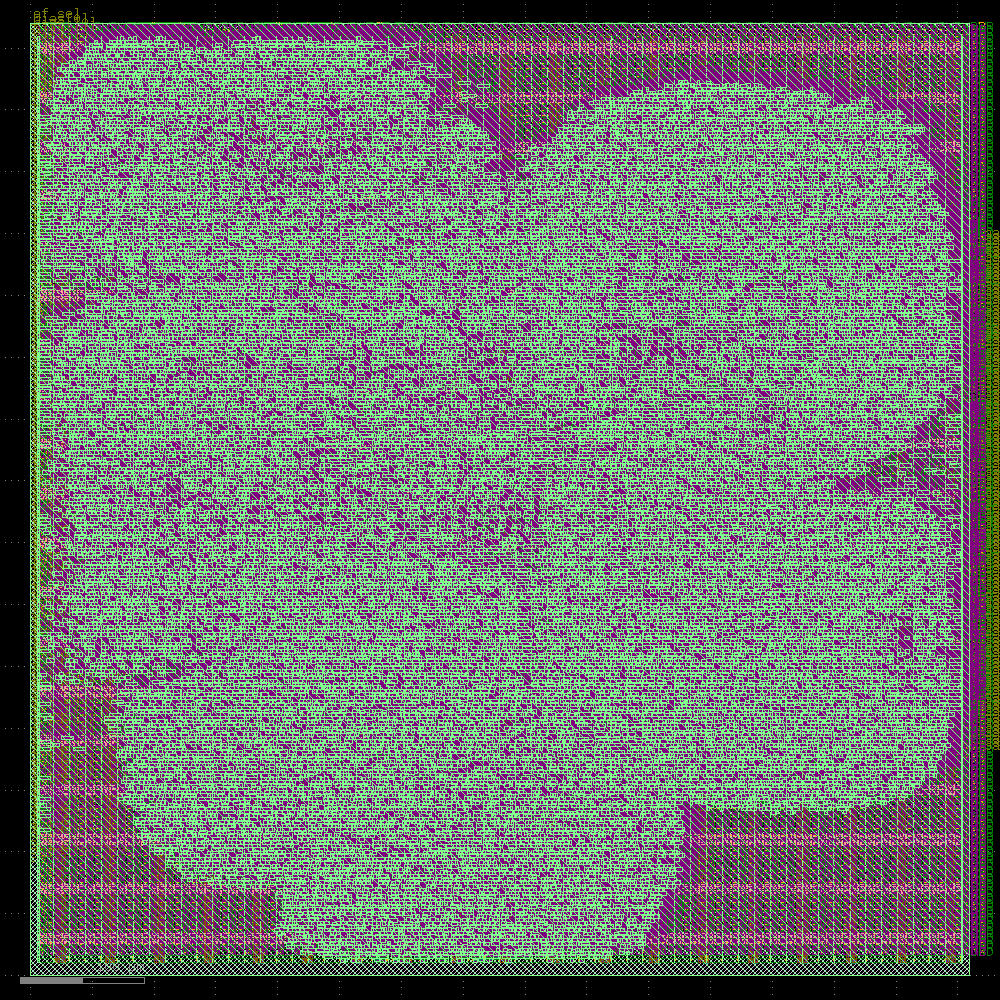

In [42]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [43]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[17:58:13] VERBOSE  Running 'OpenROAD.GlobalRouting'…                                                  ]8;id=109573;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=206435;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:58:13] VERBOSE  Logging subprocess to                                                              ]8;id=43278;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=938017;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=854343;file:///content/openlane_run/11-openroad-globalrouting/openroad-globalrouting.log\openlane_run/]8;;\]8;id=873435;file:///content/openlane_run/11-openroad-globalrouting/openroad-globalrouting.log\11]8;;\]8;id=854343;file:///content/openlane_run/11-openroad-globalrouting/openroad-globalrouting.log\-openroad-globalrouting/openroad-globalrouting.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/10-openroad-cts/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 127 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 637

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 28274

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal     245610        119715          51.26%

met2       Vertical       183276        119598          34.74%

met3       Horizontal     122750         82261          32.98%

met4       Vertical        73488         36084          50.90%

met5       Horizontal      24528         10900          55.56%

---------------------------------------------------------------

[INFO GRT-0101] Running extra iterations to remove overflow.

[INFO GRT-0197] Via related to pin nodes: 165120

[INFO GRT-0198] Via related Steiner nodes: 2196

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 204125

[INFO GRT-0112] Final usage 3D: 728967

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1            119715         50978           42.58%             0 /  0 /  0

met2            119598         51424           43.00%             0 /  0 /  0

met3             82261          9896           12.03%             0 /  0 /  0

met4             36084          4294           11.90%             0 /  0 /  0

met5             10900             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total           368558        116592           31.63%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 1256227 um

[INFO GRT-0014] Routed nets: 28745

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/11-openroad-globalrouting/neuron.odb'…

Writing layout to '/content/openlane_run/11-openroad-globalrouting/neuron.def'…

{'nl': Path('/content/openlane_run/10-openroad-cts/neuron.nl.v'), 'pnl': Path('/content/openlane_run/10-openroad-cts/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/11-openroad-globalrouting/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/11-openroad-globalrouting/neuron.odb'), 'sdc': Path('/content/openlane_run/10-openroad-cts/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('1557.22'), 'design__instance__displacement__mean': Decimal('0.042'), 'design__instance__displacement__max': Decimal('11.745'), 'route__wirelength__estimated': 685585, 'design__violations': 0, 'antenna__violating__nets': 260, 'antenna__violating__pins': 263}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [44]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[17:58:29] VERBOSE  Running 'OpenROAD.DetailedRouting'…                                                ]8;id=703020;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=463978;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[17:58:29] INFO     Running TritonRoute with 2 threads…                                            ]8;id=467477;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=915880;file:///content/openlane_ipynb/openlane/steps/openroad.py#1619\1619]8;;\

[17:58:29] VERBOSE  Logging subprocess to                                                              ]8;id=659134;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=563941;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=453420;file:///content/openlane_run/12-openroad-detailedrouting/openroad-detailedrouting.log\openlane_run/]8;;\]8;id=701497;file:///content/openlane_run/12-openroad-detailedrouting/openroad-detailedrouting.log\12]8;;\]8;id=453420;file:///content/openlane_run/12-openroad-detailedrouting/openroad-detailedrouting.log\-openroad-detailedrouting/openroad-detailedrouting.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/11-openroad-globalrouting/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=982045;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=700000;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=588870;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=713139;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=937976;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=947533;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=936728;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=92530;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=768399;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=712037;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=734396;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=786462;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=913159;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=884593;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=575668;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=102115;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=712825;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=626711;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

[17:58:30] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=110889;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=34721;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   neuron

Die area:                 ( 0 0 ) ( 759525 770245 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     36996

Number of terminals:      325

Number of snets:          2

Number of nets:           28745

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 302.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 842333.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 103408.

[INFO DRT-0033] via shape region query size = 47196.

[INFO DRT-0033] met2 shape region query size = 15732.

[INFO DRT-0033] via2 shape region query size = 36708.

[INFO DRT-0033] met3 shape region query size = 16055.

[INFO DRT-0033] via3 shape region query size = 36708.

[INFO DRT-0033] met4 shape region query size = 6042.

[INFO DRT-0033] via4 shape region query size = 722.

[INFO DRT-0033] met5 shape region query size = 798.

[INFO DRT-0165] Start pin access.

[INFO DRT-0076]   Complete 1000 pins.

[INFO DRT-0078]   Complete 1261 pins.

[INFO DRT-0079]   Complete 100 unique inst patterns.

[INFO DRT-0079]   Complete 200 unique inst patterns.

[INFO DRT-0081]   Complete 296 unique inst patterns.

[INFO DRT-0082]   Complete 10000 groups.

[INFO DRT-0084]   Complete 16876 groups.

#scanned instances     = 36996

#unique  instances     = 302

#stdCellGenAp          = 8609

#stdCellValidPlanarAp  = 44

#stdCellValidViaAp     = 6772

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 104477

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:07:49, elapsed time = 00:04:42, memory = 305.42 (MB), peak = 326.30 (MB)

[INFO DRT-0156] guideIn read 100000 guides.

[INFO DRT-0156] guideIn read 200000 guides.

Number of guides:     209092

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 110 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 111 STEP 6900 ;

[INFO DRT-0026]   Complete 100000 origin guides.

[INFO DRT-0026]   Complete 200000 origin guides.

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 75347.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 57983.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 29325.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 1464.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 385.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 105057 vertical wires in 3 frboxes and 59447 horizontal wires in 3 frboxes.

[INFO DRT-0186] Done with 12414 vertical wires in 3 frboxes and 17773 horizontal wires in 3 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:26, elapsed time = 00:00:17, memory = 642.53 (MB), peak = 642.53 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 642.53 (MB), peak = 642.53 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:52, memory = 702.89 (MB).

Completing 20% with 0 violations.

elapsed time = 00:02:07, memory = 971.82 (MB).

Completing 30% with 2953 violations.

elapsed time = 00:03:01, memory = 1105.63 (MB).

Completing 40% with 2953 violations.

elapsed time = 00:04:10, memory = 1112.59 (MB).

Completing 50% with 2953 violations.

elapsed time = 00:05:19, memory = 1116.46 (MB).

Completing 60% with 5880 violations.

elapsed time = 00:06:39, memory = 1135.79 (MB).

Completing 70% with 5880 violations.

elapsed time = 00:07:41, memory = 1135.79 (MB).

Completing 80% with 8866 violations.

elapsed time = 00:09:12, memory = 1185.60 (MB).

Completing 90% with 8866 violations.

elapsed time = 00:10:46, memory = 1191.46 (MB).

Completing 100% with 12022 violations.

elapsed time = 00:11:49, memory = 1197.23 (MB).

[INFO DRT-0199]   Number of violations = 17151.

Viol/Layer         li1   mcon   met1    via   met2   met3   met4

Cut Spacing          0     27      0      0      0      0      0

Metal Spacing      291      0   2480      0    861     38      0

Min Hole             0      0     28      0      0      0      0

NS Metal             2      0      7      0      0      0      0

Recheck              6      0   3315      0   1662    130     16

Short                0      1   7090      3   1186      8      0

[INFO DRT-0267] cpu time = 00:19:51, elapsed time = 00:11:52, memory = 1285.26 (MB), peak = 1285.26 (MB)

Total wire length = 845810 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 382786 um.

Total wire length on LAYER met2 = 358825 um.

Total wire length on LAYER met3 = 75068 um.

Total wire length on LAYER met4 = 29129 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 216078.

Up-via summary (total 216078):

-------------------------

FR_MASTERSLICE         0

li1    103332

met1    109217

met2      2770

met3       759

met4         0

-------------------------

216078

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 17151 violations.

elapsed time = 00:00:43, memory = 1285.26 (MB).

Completing 20% with 17151 violations.

elapsed time = 00:01:41, memory = 1285.26 (MB).

Completing 30% with 14675 violations.

elapsed time = 00:02:26, memory = 1285.26 (MB).

Completing 40% with 14675 violations.

elapsed time = 00:03:37, memory = 1285.26 (MB).

Completing 50% with 14675 violations.

elapsed time = 00:04:40, memory = 1285.26 (MB).

Completing 60% with 11877 violations.

elapsed time = 00:05:40, memory = 1285.26 (MB).

Completing 70% with 11877 violations.

elapsed time = 00:06:31, memory = 1285.26 (MB).

Completing 80% with 8702 violations.

elapsed time = 00:07:30, memory = 1285.26 (MB).

Completing 90% with 8702 violations.

elapsed time = 00:08:39, memory = 1303.32 (MB).

Completing 100% with 5790 violations.

elapsed time = 00:09:37, memory = 1304.61 (MB).

[INFO DRT-0199]   Number of violations = 5803.

Viol/Layer        mcon   met1   met2   met3   met4

Cut Spacing         12      0      0      0      0

Metal Spacing        0    985    437     13      1

Min Hole             0     23      0      0      0

Recheck              0      8      5      0      0

Short                0   3990    329      0      0

[INFO DRT-0267] cpu time = 00:16:10, elapsed time = 00:09:40, memory = 1304.61 (MB), peak = 1304.61 (MB)

Total wire length = 838391 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 379211 um.

Total wire length on LAYER met2 = 355701 um.

Total wire length on LAYER met3 = 74523 um.

Total wire length on LAYER met4 = 28954 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 214829.

Up-via summary (total 214829):

-------------------------

FR_MASTERSLICE         0

li1    103170

met1    108254

met2      2675

met3       730

met4         0

-------------------------

214829

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 5803 violations.

elapsed time = 00:00:37, memory = 1304.61 (MB).

Completing 20% with 5803 violations.

elapsed time = 00:01:39, memory = 1304.61 (MB).

Completing 30% with 5606 violations.

elapsed time = 00:02:10, memory = 1304.61 (MB).

Completing 40% with 5606 violations.

elapsed time = 00:03:22, memory = 1304.61 (MB).

Completing 50% with 5606 violations.

elapsed time = 00:04:25, memory = 1304.61 (MB).

Completing 60% with 5730 violations.

elapsed time = 00:05:15, memory = 1304.61 (MB).

Completing 70% with 5730 violations.

elapsed time = 00:06:05, memory = 1305.39 (MB).

Completing 80% with 5600 violations.

elapsed time = 00:07:01, memory = 1305.39 (MB).

Completing 90% with 5600 violations.

elapsed time = 00:08:10, memory = 1305.39 (MB).

Completing 100% with 5308 violations.

elapsed time = 00:09:22, memory = 1312.60 (MB).

[INFO DRT-0199]   Number of violations = 5315.

Viol/Layer        mcon   met1    via   met2   met3   met4

Cut Spacing         16      0      0      0      0      0

Metal Spacing        0    987      0    410      2      0

Min Hole             0     13      0      0      0      0

Recheck              0      6      0      1      0      0

Short                0   3607      1    271      0      1

[INFO DRT-0267] cpu time = 00:15:44, elapsed time = 00:09:24, memory = 1312.60 (MB), peak = 1312.60 (MB)

Total wire length = 836465 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 378757 um.

Total wire length on LAYER met2 = 354769 um.

Total wire length on LAYER met3 = 74073 um.

Total wire length on LAYER met4 = 28863 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 214483.

Up-via summary (total 214483):

-------------------------

FR_MASTERSLICE         0

li1    103167

met1    107971

met2      2611

met3       734

met4         0

-------------------------

214483

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 5315 violations.

elapsed time = 00:00:22, memory = 1312.60 (MB).

Completing 20% with 5315 violations.

elapsed time = 00:00:56, memory = 1312.60 (MB).

Completing 30% with 4081 violations.

elapsed time = 00:01:42, memory = 1327.30 (MB).

Completing 40% with 4081 violations.

elapsed time = 00:02:26, memory = 1330.13 (MB).

Completing 50% with 4081 violations.

elapsed time = 00:02:54, memory = 1330.13 (MB).

Completing 60% with 2957 violations.

elapsed time = 00:03:35, memory = 1330.13 (MB).

Completing 70% with 2957 violations.

elapsed time = 00:04:06, memory = 1330.13 (MB).

Completing 80% with 1596 violations.

elapsed time = 00:04:46, memory = 1348.44 (MB).

Completing 90% with 1596 violations.

elapsed time = 00:05:32, memory = 1349.47 (MB).

Completing 100% with 308 violations.

elapsed time = 00:06:00, memory = 1310.61 (MB).

[INFO DRT-0199]   Number of violations = 314.

Viol/Layer        met1    via   met2   met3

Cut Spacing          0      1      0      0

Metal Spacing       51      0     33      5

Recheck              4      0      2      0

Short              190      0     28      0

[INFO DRT-0267] cpu time = 00:10:04, elapsed time = 00:06:01, memory = 1310.61 (MB), peak = 1358.75 (MB)

Total wire length = 834973 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 361094 um.

Total wire length on LAYER met2 = 353103 um.

Total wire length on LAYER met3 = 90126 um.

Total wire length on LAYER met4 = 30648 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 217787.

Up-via summary (total 217787):

-------------------------

FR_MASTERSLICE         0

li1    103167

met1    108426

met2      5271

met3       923

met4         0

-------------------------

217787

[INFO DRT-0195] Start 4th optimization iteration.

Completing 10% with 314 violations.

elapsed time = 00:00:06, memory = 1310.61 (MB).

Completing 20% with 314 violations.

elapsed time = 00:00:13, memory = 1310.61 (MB).

Completing 30% with 221 violations.

elapsed time = 00:00:16, memory = 1310.61 (MB).

Completing 40% with 221 violations.

elapsed time = 00:00:19, memory = 1310.61 (MB).

Completing 50% with 221 violations.

elapsed time = 00:00:23, memory = 1310.61 (MB).

Completing 60% with 135 violations.

elapsed time = 00:00:26, memory = 1310.61 (MB).

Completing 70% with 135 violations.

elapsed time = 00:00:26, memory = 1310.61 (MB).

Completing 80% with 104 violations.

elapsed time = 00:00:31, memory = 1310.61 (MB).

Completing 90% with 104 violations.

elapsed time = 00:00:38, memory = 1310.61 (MB).

Completing 100% with 21 violations.

elapsed time = 00:00:43, memory = 1310.61 (MB).

[INFO DRT-0199]   Number of violations = 21.

Viol/Layer        mcon   met1   met2

Cut Spacing          1      0      0

Metal Spacing        0      7      0

Short                0     12      1

[INFO DRT-0267] cpu time = 00:01:09, elapsed time = 00:00:44, memory = 1305.91 (MB), peak = 1358.75 (MB)

Total wire length = 834915 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 360651 um.

Total wire length on LAYER met2 = 353032 um.

Total wire length on LAYER met3 = 90529 um.

Total wire length on LAYER met4 = 30701 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 217820.

Up-via summary (total 217820):

-------------------------

FR_MASTERSLICE         0

li1    103167

met1    108399

met2      5326

met3       928

met4         0

-------------------------

217820

[INFO DRT-0195] Start 5th optimization iteration.

Completing 10% with 21 violations.

elapsed time = 00:00:00, memory = 1305.91 (MB).

Completing 20% with 21 violations.

elapsed time = 00:00:00, memory = 1305.91 (MB).

Completing 30% with 12 violations.

elapsed time = 00:00:01, memory = 1305.91 (MB).

Completing 40% with 12 violations.

elapsed time = 00:00:01, memory = 1305.91 (MB).

Completing 50% with 12 violations.

elapsed time = 00:00:01, memory = 1305.91 (MB).

Completing 60% with 10 violations.

elapsed time = 00:00:01, memory = 1305.91 (MB).

Completing 70% with 10 violations.

elapsed time = 00:00:01, memory = 1305.91 (MB).

Completing 80% with 10 violations.

elapsed time = 00:00:01, memory = 1305.91 (MB).

Completing 90% with 10 violations.

elapsed time = 00:00:01, memory = 1305.91 (MB).

Completing 100% with 0 violations.

elapsed time = 00:00:02, memory = 1305.91 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:04, elapsed time = 00:00:03, memory = 1305.91 (MB), peak = 1358.75 (MB)

Total wire length = 834907 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 360629 um.

Total wire length on LAYER met2 = 353033 um.

Total wire length on LAYER met3 = 90544 um.

Total wire length on LAYER met4 = 30701 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 217821.

Up-via summary (total 217821):

-------------------------

FR_MASTERSLICE         0

li1    103167

met1    108399

met2      5327

met3       928

met4         0

-------------------------

217821

[INFO DRT-0198] Complete detail routing.

Total wire length = 834907 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 360629 um.

Total wire length on LAYER met2 = 353033 um.

Total wire length on LAYER met3 = 90544 um.

Total wire length on LAYER met4 = 30701 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 217821.

Up-via summary (total 217821):

-------------------------

FR_MASTERSLICE         0

li1    103167

met1    108399

met2      5327

met3       928

met4         0

-------------------------

217821

[INFO DRT-0267] cpu time = 01:03:06, elapsed time = 00:37:47, memory = 1305.91 (MB), peak = 1358.75 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/12-openroad-detailedrouting/neuron.odb'…

Writing netlist to '/content/openlane_run/12-openroad-detailedrouting/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/12-openroad-detailedrouting/neuron.pnl.v'…

Writing layout to '/content/openlane_run/12-openroad-detailedrouting/neuron.def'…

Writing timing constraints to '/content/openlane_run/12-openroad-detailedrouting/neuron.sdc'…

{'nl': Path('/content/openlane_run/12-openroad-detailedrouting/neuron.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-detailedrouting/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-detailedrouting/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-detailedrouting/neuron.odb'), 'sdc': Path('/content/openlane_run/12-openroad-detailedrouting/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 10, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('1557.22'), 'design__instance__displacement__mean': Decimal('0.042'), 'design__instance__displacement__max': Decimal('11.745'), 'route__wirelength__estimated': 685585, 'design__violations': 0, 'antenna__violating__nets': 260, 'antenna__violating__pins': 263, 'route__net': 28745, 'route__net__special': 2, 'route__drc_errors__iter:1': 17151, 'route__wirelength__iter:1': 845810, 'route__drc_errors__iter:2': 5803, 'route__wirelength__iter:2': 838391, 'route__drc_errors__iter:3': 5315, 'route__wirelength__iter:3': 836465, 'route__drc_errors__iter:4': 314, 'route__wirelength__iter:4': 834973, 'route__drc_errors__iter:5': 21, 'route__wirelength__iter:5': 834915, 'route__drc_errors__iter:6': 0, 'route__wirelength__iter:6': 834907, 'route__drc_errors': 0, 'route__wirelength': 834907, 'route__vias': 217821, 'route__vias__singlecut': 217821, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:41:24] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=575912;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=223075;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:41:24] VERBOSE  Logging subprocess to ]8;id=131250;file:///tmp/openlane_klayout_tmp_3li0paus/klayout-render.log\..]8;;\]8;id=259370;file:///tmp/openlane_klayout_tmp_3li0paus/klayout-render.log\/tmp/openlane_klayout_tmp_3li0paus/]8;;\]8;id=277952;file:///tmp/openlane_klayout_tmp_3li0paus/klayout-render.log\klayout-render.log]8;;\…     ]8;id=6353;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=503900;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2574.63s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
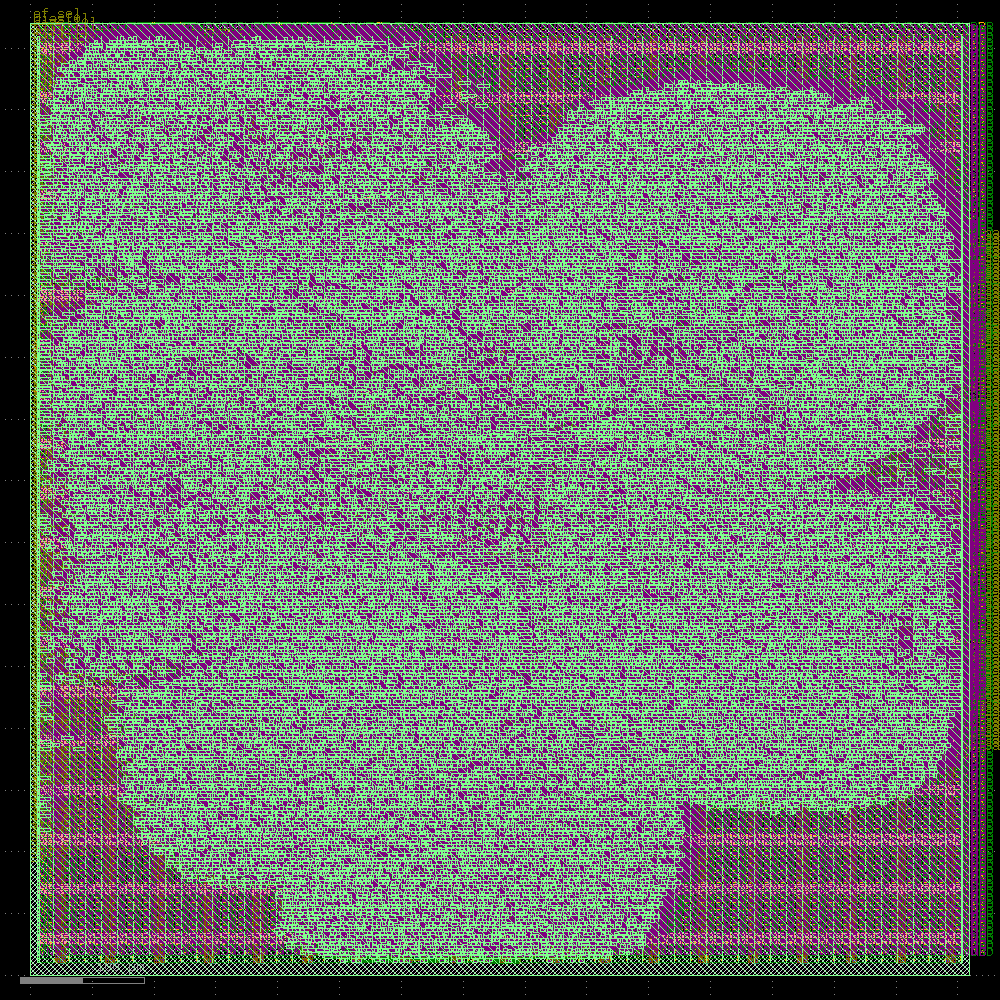

In [45]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [46]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

[18:41:32] VERBOSE  Running 'OpenROAD.FillInsertion'…                                                  ]8;id=245625;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=42702;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:41:32] VERBOSE  Logging subprocess to                                                              ]8;id=924623;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=653695;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=453300;file:///content/openlane_run/13-openroad-fillinsertion/openroad-fillinsertion.log\openlane_run/]8;;\]8;id=518144;file:///content/openlane_run/13-openroad-fillinsertion/openroad-fillinsertion.log\13]8;;\]8;id=453300;file:///content/openlane_run/13-openroad-fillinsertion/openroad-fillinsertion.log\-openroad-fillinsertion/openroad-fillinsertion.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/12-openroad-detailedrouting/neuron.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

sky130_ef_sc_hd__decap_12 sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4               
sky130_fd_sc_hd__decap_3 sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 35922 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/13-openroad-fillinsertion/neuron.odb'…

Writing netlist to '/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'…

Writing powered netlist to '/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'…

Writing layout to '/content/openlane_run/13-openroad-fillinsertion/neuron.def'…

Writing timing constraints to '/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'…

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('1557.22'), 'design__instance__displacement__mean': Decimal('0.042'), 'design__instance__displacement__max': Decimal('11.745'), 'route__wirelength__estimated': 685585, 'design__violations': 0, 'antenna__violating__nets': 260, 'antenna__violating__pins': 263, 'route__net': 28745, 'route__net__special': 2, 'route__drc_errors__iter:1': 17151, 'route__wirelength__iter:1': 845810, 'route__drc_errors__iter:2': 5803, 'route__wirelength__iter:2': 838391, 'route__drc_errors__iter:3': 5315, 'route__wirelength__iter:3': 836465, 'route__drc_errors__iter:4': 314, 'route__wirelength__iter:4': 834973, 'route__drc_errors__iter:5': 21, 'route__wirelength__iter:5': 834915, 'route__drc_errors__iter:6': 0, 'route__wirelength__iter:6': 834907, 'route__drc_errors': 0, 'route__wirelength': 834907, 'route__vias': 217821, 'route__vias__singlecut': 217821, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:41:35] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=445379;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=22556;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:41:35] VERBOSE  Logging subprocess to ]8;id=61241;file:///tmp/openlane_klayout_tmp_6h41cufv/klayout-render.log\..]8;;\]8;id=310146;file:///tmp/openlane_klayout_tmp_6h41cufv/klayout-render.log\/tmp/openlane_klayout_tmp_6h41cufv/]8;;\]8;id=222416;file:///tmp/openlane_klayout_tmp_6h41cufv/klayout-render.log\klayout-render.log]8;;\…     ]8;id=839013;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=984122;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.43s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
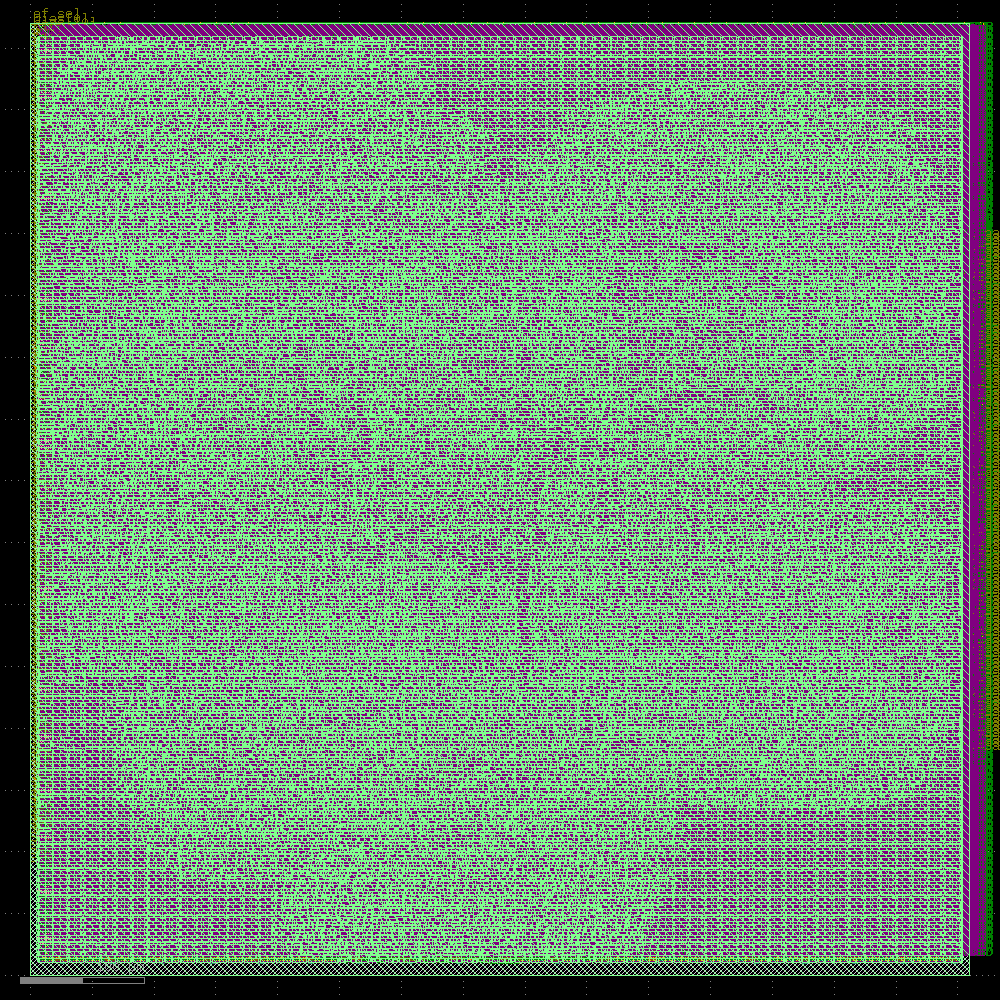

In [47]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [48]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

─────────────────────────────────── Parasitic Resistance/Capacitance Extraction ───────────────────────────────────

[18:41:45] VERBOSE  Running 'OpenROAD.RCX'…                                                            ]8;id=1357;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=535929;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:41:45] INFO     Running RCX for corners matching nom_*                                         ]8;id=641927;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=497589;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/14-openroad-rcx/nom/rcx.log)…                                           

[18:41:45] VERBOSE  Logging subprocess to ]8;id=202739;file:///content/openlane_run/14-openroad-rcx/nom/rcx.log\openlane_run/]8;;\]8;id=422966;file:///content/openlane_run/14-openroad-rcx/nom/rcx.log\14]8;;\]8;id=202739;file:///content/openlane_run/14-openroad-rcx/nom/rcx.log\-openroad-rcx/nom/rcx.log]8;;\…                    ]8;id=760583;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=123151;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[18:41:45] INFO     Running RCX for corners matching min_*                                         ]8;id=745958;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=938852;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/14-openroad-rcx/min/rcx.log)…                                           

[18:41:45] VERBOSE  Logging subprocess to ]8;id=792668;file:///content/openlane_run/14-openroad-rcx/min/rcx.log\openlane_run/]8;;\]8;id=506046;file:///content/openlane_run/14-openroad-rcx/min/rcx.log\14]8;;\]8;id=792668;file:///content/openlane_run/14-openroad-rcx/min/rcx.log\-openroad-rcx/min/rcx.log]8;;\…                    ]8;id=390858;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=791248;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[18:42:14] INFO     Finished RCX for corners matching min_*.                                       ]8;id=427109;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=46224;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[18:42:14] INFO     Running RCX for corners matching max_*                                         ]8;id=77078;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=608295;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/14-openroad-rcx/max/rcx.log)…                                           

[18:42:14] VERBOSE  Logging subprocess to ]8;id=54111;file:///content/openlane_run/14-openroad-rcx/max/rcx.log\openlane_run/]8;;\]8;id=680440;file:///content/openlane_run/14-openroad-rcx/max/rcx.log\14]8;;\]8;id=54111;file:///content/openlane_run/14-openroad-rcx/max/rcx.log\-openroad-rcx/max/rcx.log]8;;\…                    ]8;id=894327;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=540513;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[18:42:14] INFO     Finished RCX for corners matching nom_*.                                       ]8;id=335509;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=877253;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[18:42:30] INFO     Finished RCX for corners matching max_*.                                       ]8;id=754529;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=58701;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'), 'sdf': None, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/neuron.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/neuron.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/neuron.max.spef')}, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('1557.22'), 'design__instance__displacement__mean': Decimal('0.042'), 'design__instance__displacement__max': Decimal('11.745'), 'route__wirelength__estimated': 685585, 'design__violations': 0, 'antenna__violating__nets': 260, 'antenna__violating__pins': 263, 'route__net': 28745, 'route__net__special': 2, 'route__drc_errors__iter:1': 17151, 'route__wirelength__iter:1': 845810, 'route__drc_errors__iter:2': 5803, 'route__wirelength__iter:2': 838391, 'route__drc_errors__iter:3': 5315, 'route__wirelength__iter:3': 836465, 'route__drc_errors__iter:4': 314, 'route__wirelength__iter:4': 834973, 'route__drc_errors__iter:5': 21, 'route__wirelength__iter:5': 834915, 'route__drc_errors__iter:6': 0, 'route__wirelength__iter:6': 834907, 'route__drc_errors': 0, 'route__wirelength': 834907, 'route__vias': 217821, 'route__vias__singlecut': 217821, 'route__vias__multicut': 0}}

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [49]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out,STA_WRITE_LIB=True)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[18:42:30] VERBOSE  Running 'OpenROAD.STAPostPNR'…                                                     ]8;id=318493;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=880894;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:42:30] INFO     Starting STA for the nom_tt_025C_1v80 timing corner…                            ]8;id=875575;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=499058;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:42:30] INFO     Starting STA for the nom_ss_100C_1v60 timing corner…                            ]8;id=161048;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=399500;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:42:30] VERBOSE  Logging subprocess to                                                              ]8;id=704580;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=706373;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=432596;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=516149;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\15]8;;\]8;id=432596;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\-openroad-stapostpnr/nom_ss_100C_1v60/sta.log]8;;\…                                  

[18:42:30] VERBOSE  Logging subprocess to                                                              ]8;id=908180;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=621331;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=451919;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=735712;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\15]8;;\]8;id=451919;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\-openroad-stapostpnr/nom_tt_025C_1v80/sta.log]8;;\…                                  

[18:43:35] INFO     Finished STA for the nom_tt_025C_1v80 timing corner.                            ]8;id=909211;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=770115;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:43:35] VERBOSE  Logging subprocess to                                                              ]8;id=581047;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=204548;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=855392;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=563078;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\15]8;;\]8;id=855392;file:///content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[18:43:35] INFO     Finished STA for the nom_ss_100C_1v60 timing corner.                            ]8;id=376880;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=816793;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:43:35] VERBOSE  Logging subprocess to                                                              ]8;id=60459;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=675452;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=582393;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=722028;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\15]8;;\]8;id=582393;file:///content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[18:43:37] INFO     Starting STA for the nom_ff_n40C_1v95 timing corner…                            ]8;id=244353;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=575512;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:43:37] VERBOSE  Logging subprocess to                                                              ]8;id=748392;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=94285;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=783948;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=700912;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\15]8;;\]8;id=783948;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log]8;;\…                                  

[18:43:37] INFO     Starting STA for the min_tt_025C_1v80 timing corner…                            ]8;id=740593;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=355078;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:43:37] VERBOSE  Logging subprocess to                                                              ]8;id=742676;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=459678;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=528489;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=926776;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/sta.log\15]8;;\]8;id=528489;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/sta.log\-openroad-stapostpnr/min_tt_025C_1v80/sta.log]8;;\…                                  

[18:44:39] INFO     Finished STA for the min_tt_025C_1v80 timing corner.                            ]8;id=704369;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=166471;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:44:39] VERBOSE  Logging subprocess to                                                              ]8;id=134649;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=602877;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=735819;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=234518;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\15]8;;\]8;id=735819;file:///content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[18:44:41] INFO     Starting STA for the min_ss_100C_1v60 timing corner…                            ]8;id=768438;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=240297;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:44:41] VERBOSE  Logging subprocess to                                                              ]8;id=798310;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=33480;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=394468;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=651591;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/sta.log\15]8;;\]8;id=394468;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/sta.log\-openroad-stapostpnr/min_ss_100C_1v60/sta.log]8;;\…                                  

[18:44:42] INFO     Finished STA for the nom_ff_n40C_1v95 timing corner.                            ]8;id=73808;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=36457;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:44:42] VERBOSE  Logging subprocess to                                                              ]8;id=175415;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=22157;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=179243;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=863125;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\15]8;;\]8;id=179243;file:///content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[18:44:44] INFO     Starting STA for the min_ff_n40C_1v95 timing corner…                            ]8;id=285684;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=936572;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:44:44] VERBOSE  Logging subprocess to                                                              ]8;id=809861;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=217226;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=250141;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=561730;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\15]8;;\]8;id=250141;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\-openroad-stapostpnr/min_ff_n40C_1v95/sta.log]8;;\…                                  

[18:45:44] INFO     Finished STA for the min_ss_100C_1v60 timing corner.                            ]8;id=222538;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=963549;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:45:44] VERBOSE  Logging subprocess to                                                              ]8;id=602241;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=399911;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=473546;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=787062;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\15]8;;\]8;id=473546;file:///content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[18:45:46] INFO     Starting STA for the max_tt_025C_1v80 timing corner…                            ]8;id=255164;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=534604;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:45:46] VERBOSE  Logging subprocess to                                                              ]8;id=275534;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=52821;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=769224;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=933108;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/sta.log\15]8;;\]8;id=769224;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/sta.log\-openroad-stapostpnr/max_tt_025C_1v80/sta.log]8;;\…                                  

[18:45:47] INFO     Finished STA for the min_ff_n40C_1v95 timing corner.                            ]8;id=676845;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=974014;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:45:47] VERBOSE  Logging subprocess to                                                              ]8;id=669612;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=148076;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=199387;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=825232;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\15]8;;\]8;id=199387;file:///content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[18:45:49] INFO     Starting STA for the max_ss_100C_1v60 timing corner…                            ]8;id=218176;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=921832;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:45:49] VERBOSE  Logging subprocess to                                                              ]8;id=190030;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=460134;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=287354;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=205853;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/sta.log\15]8;;\]8;id=287354;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/sta.log\-openroad-stapostpnr/max_ss_100C_1v60/sta.log]8;;\…                                  

[18:46:53] INFO     Finished STA for the max_tt_025C_1v80 timing corner.                            ]8;id=853723;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=843017;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:46:53] VERBOSE  Logging subprocess to                                                              ]8;id=884059;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=852721;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=733039;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=591678;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\15]8;;\]8;id=733039;file:///content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[18:46:55] INFO     Starting STA for the max_ff_n40C_1v95 timing corner…                            ]8;id=536010;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=605543;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:46:55] VERBOSE  Logging subprocess to                                                              ]8;id=991427;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=225243;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=571822;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=868323;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\15]8;;\]8;id=571822;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\-openroad-stapostpnr/max_ff_n40C_1v95/sta.log]8;;\…                                  

[18:46:58] INFO     Finished STA for the max_ss_100C_1v60 timing corner.                            ]8;id=133956;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=685052;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:46:58] VERBOSE  Logging subprocess to                                                              ]8;id=98326;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=782330;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=467670;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=697637;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\15]8;;\]8;id=467670;file:///content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[18:47:38] INFO     Finished STA for the max_ff_n40C_1v95 timing corner.                            ]8;id=327578;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=871912;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:47:38] VERBOSE  Logging subprocess to                                                              ]8;id=993141;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=25368;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=611277;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=502426;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\15]8;;\]8;id=611277;file:///content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┓
┃                      ┃       ┃       ┃       ┃      ┃ of    ┃      ┃       ┃      ┃       ┃ of   ┃       ┃      ┃
┃                      ┃       ┃ Reg   ┃       ┃      ┃ which ┃      ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃      ┃
┃                      ┃ Hold  ┃ to    ┃       ┃ Hold ┃ reg   ┃ Set… ┃ to    ┃      ┃ Setup ┃ reg  ┃ Max   ┃ Max  ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold  ┃ Vio  ┃ to    ┃ Wor… ┃ Reg   ┃ Set… ┃ Vio   ┃ to   ┃ Cap   ┃ Slew ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS   ┃ Cou… ┃ reg   ┃ Sla… ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Viol… ┃ Vio… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━┩
│ Overall              │ -0.6… │ -0.1… │ -124… │ 910  │ 81    │ -31… │ -31.… │ -14… │ 7298  │ 1574 │ 300   │ 177… │
│ nom_tt_025C_1v80     │ -0.0… │ -0.0… │ -0.0… │ 1    │ 1     │ -11… │ -11.… │ -51… │ 825   │ 189  │ 281   │ 161… │
│ nom_ss_100C_1v60     │ -0.5… │ 0.28… │ -94.… │ 280  │ 0     │ -29… │ -29.… │ -14… │ 914   │ 278  │ 293   │ 175… │
│ nom_ff_n40C_1v95     │ -0.1… │ -0.1… │ -0.4… │ 26   │ 26    │ -4.… │ -2.9… │ -20… │ 693   │ 57   │ 278   │ 154… │
│ min_tt_025C_1v80     │ -0.0… │ -0.0… │ -0.0… │ 1    │ 1     │ -10… │ -10.… │ -47… │ 822   │ 186  │ 275   │ 160… │
│ min_ss_100C_1v60     │ -0.4… │ 0.27… │ -62.… │ 262  │ 0     │ -28… │ -28.… │ -13… │ 914   │ 278  │ 287   │ 174… │
│ min_ff_n40C_1v95     │ -0.1… │ -0.1… │ -0.4… │ 26   │ 26    │ -3.… │ -2.5… │ -17… │ 693   │ 57   │ 269   │ 153… │
│ max_tt_025C_1v80     │ -0.0… │ -0.0… │ -0.0… │ 1    │ 1     │ -12… │ -12.… │ -57… │ 829   │ 193  │ 285   │ 162… │
│ max_ss_100C_1v60     │ -0.6… │ 0.28… │ -124… │ 287  │ 0     │ -31… │ -31.… │ -14… │ 915   │ 279  │ 300   │ 177… │
│ max_ff_n40C_1v95     │ -0.1… │ -0.1… │ -0.4… │ 26   │ 26    │ -5.… │ -3.4… │ -24… │ 693   │ 57   │ 281   │ 156… │
└──────────────────────┴───────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ -0.6794  │ -0.1117  │ -124.00… │ 910      │ 81        │ -31.2648 │ -31.2648  │ -14860.… │ 7298      │ 1574     │ 300       │ 17732    │
│ nom_tt_025C_1v80     │ -0.0107  │ -0.0107  │ -0.0107  │ 1        │ 1         │ -11.2226 │ -11.2226  │ -5188.3… │ 825       │ 189      │ 281       │ 16143    │
│ nom_ss_100C_1v60     │ -0.5586  │ 0.2802   │ -94.2465 │ 280      │ 0         │ -29.9741 │ -29.9741  │ -14016.… │ 914       │ 278      │ 293       │ 17598    │
│ nom_ff_n40C_1v95     │ -0.1104  │ -0.1104  │ -0.4698  │ 26       │ 26        │ -4.0431  │ -2.9733   │ -2020.4… │ 693       │ 57       │ 278       │ 15464    │
│ min_tt_025C_1v80     │ -0.0133  │ -0.0133  │ -0.0133  │ 1        │ 1         │ -10.4604 │ -10.4604  │ -4747.2… │ 822       │ 186      │ 275       │ 16023    │
│ min_ss_100C_1v60     │ -0.4250  │ 0.2758   │ -62.5643 │ 262      │ 0         │ -28.7817 │ -28.7817  │ -13314.… │ 914       │ 278      │ 287       │ 17454    │
│ min_ff_n40C_1v95     │ -0.1117  │ -0.1117  │ -0.4932  │ 26       │ 26        │ -3.3433  │ -2.5136   │ -1731.1… │ 693       │ 57       │ 269       │ 15375    │
│ max_tt_025C_1v80     │ -0.0109  │ -0.0109  │ -0.0109  │ 1        │ 1         │ -12.0074 │ -12.0074  │ -5705.7… │ 829       │ 193      │ 285       │ 16214    │
│ max_ss_100C_1v60     │ -0.6794  │ 0.2804   │ -124.00… │ 287      │ 0         │ -31.2648 │ -31.2648  │ -14860.… │ 915       │ 279      │ 300       │ 17732    │
│ max_ff_n40C_1v95     │ -0.1109  │ -0.1109  │ -0.4506  │ 26       │ 26        │ -5.4898  │ -3.4497   │ -2434.3… │ 693       │ 57       │ 281       │ 15611    │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/neuron.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/neuron.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/neuron.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('1557.22'), 'design__instance__displacement__mean': Decimal('0.042'), 'design__instance__displacement_

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [50]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[18:47:40] VERBOSE  Running 'KLayout.StreamOut'…                                                       ]8;id=513129;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=292409;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:47:40] VERBOSE  Logging subprocess to ]8;id=447162;file:///content/openlane_run/16-klayout-streamout/klayout-streamout.log\openlane_run/]8;;\]8;id=180876;file:///content/openlane_run/16-klayout-streamout/klayout-streamout.log\16]8;;\]8;id=447162;file:///content/openlane_run/16-klayout-streamout/klayout-streamout.log\-klayout-streamout/klayout-streamout.log]8;;\…     ]8;id=758922;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=700463;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Error processing line 1 of /usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.pth:

Traceback (most recent call last):

File "<frozen site>", line 201, in addpackage

File "<string>", line 1, in <module>

File "/usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.py", line 2, in <module>

import importlib.abc

File "/usr/lib/python3.11/importlib/abc.py", line 19, in <module>

from .resources.abc import ResourceReader, Traversable, TraversableResources

File "/usr/lib/python3.11/importlib/resources/__init__.py", line 3, in <module>

from ._common import (

File "/usr/lib/python3.11/importlib/resources/_common.py", line 2, in <module>

import pathlib

File "/usr/local/lib/python3.11/dist-packages/pathlib.py", line 10, in <module>

from collections import Sequence

ImportError: cannot import name 'Sequence' from 'collections' (/usr/lib/python3.11/collections/__init__.py)

Remainder of file ignored

Error processing line 1 of /usr/local/lib/python3.11/dist-packages/_rapids_dask_dependency.pth:

Traceback (most recent call last):

File "<frozen site>", line 201, in addpackage

File "<string>", line 1, in <module>

File "/usr/local/lib/python3.11/dist-packages/rapids_dask_dependency/__init__.py", line 3, in <module>

from .dask_loader import DaskFinder

File "/usr/local/lib/python3.11/dist-packages/rapids_dask_dependency/dask_loader.py", line 4, in <module>

import importlib.abc

File "/usr/lib/python3.11/importlib/abc.py", line 19, in <module>

from .resources.abc import ResourceReader, Traversable, TraversableResources

File "/usr/lib/python3.11/importlib/resources/__init__.py", line 3, in <module>

from ._common import (

File "/usr/lib/python3.11/importlib/resources/_common.py", line 2, in <module>

import pathlib

File "/usr/local/lib/python3.11/dist-packages/pathlib.py", line 10, in <module>

from collections import Sequence

ImportError: cannot import name 'Sequence' from 'collections' (/usr/lib/python3.11/collections/__init__.py)

Remainder of file ignored

[INFO] Clearing cells…

[INFO] Merging GDS files…

[INFO] Copying top level cell 'neuron'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/openlane_run/16-klayout-streamout/neuron.klayout.gds'…

[INFO] Done.

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/neuron.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/neuron.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/neuron.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/neuron.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/neuron.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displaceme

In [51]:
display(gds)

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:47:45] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=821011;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=864053;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:47:45] VERBOSE  Logging subprocess to ]8;id=707724;file:///tmp/openlane_klayout_tmp_vscy5rrv/klayout-render.log\..]8;;\]8;id=531281;file:///tmp/openlane_klayout_tmp_vscy5rrv/klayout-render.log\/tmp/openlane_klayout_tmp_vscy5rrv/]8;;\]8;id=135411;file:///tmp/openlane_klayout_tmp_vscy5rrv/klayout-render.log\klayout-render.log]8;;\…     ]8;id=581627;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=28486;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 5.48s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:


### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [52]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[18:47:55] VERBOSE  Running 'Magic.DRC'…                                                               ]8;id=487075;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=800005;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:47:55] VERBOSE  Logging subprocess to ]8;id=639578;file:///content/openlane_run/17-magic-drc/magic-drc.log\openlane_run/]8;;\]8;id=273117;file:///content/openlane_run/17-magic-drc/magic-drc.log\17]8;;\]8;id=639578;file:///content/openlane_run/17-magic-drc/magic-drc.log\-magic-drc/magic-drc.log]8;;\…                     ]8;id=638876;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=302010;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_M3M4_PR".

Reading "VIA_M2M3_PR".

Reading "VIA_M1M2_PR_MR".

Reading "VIA_M1M2_PR".

Reading "VIA_L1M1_PR_MR".

Reading "VIA_via2_3_3000_480_1_9_320_320".

Reading "VIA_via3_4_3000_480_1_7_400_400".

Reading "VIA_via4_5_3000_480_1_7_400_400".

Reading "VIA_via5_6_3000_3000_1_1_1600_1600".

Reading "sky130_fd_sc_hd__clkinvlp_4".

Reading "sky130_fd_sc_hd__inv_12".

Reading "sky130_fd_sc_hd__inv_4".

Reading "sky130_fd_sc_hd__inv_6".

Reading "sky130_fd_sc_hd__bufinv_16".

Reading "sky130_fd_sc_hd__clkinv_2".

Reading "sky130_fd_sc_hd__clkinv_8".

Reading "sky130_fd_sc_hd__clkinv_4".

Reading "sky130_fd_sc_hd__inv_8".

Reading "sky130_fd_sc_hd__clkbuf_4".

Reading "sky130_fd_sc_hd__clkbuf_8".

Reading "sky130_fd_sc_hd__clkbuf_16".

Reading "sky130_fd_sc_hd__dfrtp_2".

Reading "sky130_fd_sc_hd__a2bb2oi_2".

Reading "sky130_fd_sc_hd__o32ai_2".

Reading "sky130_fd_sc_hd__a41oi_2".

Reading "sky130_fd_sc_hd__o221ai_2".

Reading "sky130_fd_sc_hd__nor4b_2".

Reading "sky130_fd_sc_hd__o2111ai_2".

Reading "sky130_fd_sc_hd__o311ai_2".

Reading "sky130_fd_sc_hd__a41o_2".

Reading "sky130_fd_sc_hd__o41a_2".

Reading "sky130_fd_sc_hd__mux2_1".

Reading "sky130_fd_sc_hd__o2bb2ai_2".

Reading "sky130_fd_sc_hd__o2111a_2".

Reading "sky130_fd_sc_hd__or4b_2".

Reading "sky130_fd_sc_hd__a221oi_2".

Reading "sky130_fd_sc_hd__a2111o_2".

Reading "sky130_fd_sc_hd__a311oi_2".

Reading "sky130_fd_sc_hd__o32a_2".

Reading "sky130_fd_sc_hd__o311a_2".

Reading "sky130_fd_sc_hd__a32oi_2".

Reading "sky130_fd_sc_hd__a221o_2".

Reading "sky130_fd_sc_hd__nor3b_2".

Reading "sky130_fd_sc_hd__o221a_2".

Reading "sky130_fd_sc_hd__nand4b_2".

Reading "sky130_fd_sc_hd__or3b_2".

Reading "sky130_fd_sc_hd__a311o_2".

Reading "sky130_fd_sc_hd__a2bb2o_2".

Reading "sky130_fd_sc_hd__or4bb_2".

Reading "sky130_fd_sc_hd__nand3b_2".

Reading "sky130_fd_sc_hd__a32o_2".

Reading "sky130_fd_sc_hd__o21bai_2".

Reading "sky130_fd_sc_hd__and3b_2".

Reading "sky130_fd_sc_hd__a21boi_2".

Reading "sky130_fd_sc_hd__o31ai_2".

Reading "sky130_fd_sc_hd__o22ai_2".

Reading "sky130_fd_sc_hd__or4_2".

Reading "sky130_fd_sc_hd__a21bo_2".

Reading "sky130_fd_sc_hd__a211o_2".

Reading "sky130_fd_sc_hd__o211ai_2".

Reading "sky130_fd_sc_hd__o21ba_2".

Reading "sky130_fd_sc_hd__a211oi_2".

Reading "sky130_fd_sc_hd__nor3_2".

Reading "sky130_fd_sc_hd__nand2b_2".

Reading "sky130_fd_sc_hd__a31oi_2".

Reading "sky130_fd_sc_hd__o31a_2".

Reading "sky130_fd_sc_hd__nand3_2".

Reading "sky130_fd_sc_hd__a21o_2".

Reading "sky130_fd_sc_hd__o22a_2".

Reading "sky130_fd_sc_hd__nor4_2".

Reading "sky130_fd_sc_hd__a21oi_2".

Reading "sky130_fd_sc_hd__a31o_2".

Reading "sky130_fd_sc_hd__o21ai_2".

Reading "sky130_fd_sc_hd__and4b_2".

Reading "sky130_fd_sc_hd__nand4_2".

Reading "sky130_fd_sc_hd__o211a_2".

Reading "sky130_fd_sc_hd__or3_2".

Reading "sky130_fd_sc_hd__and2_2".

Reading "sky130_fd_sc_hd__a22o_2".

Reading "sky130_fd_sc_hd__o21a_2".

Reading "sky130_fd_sc_hd__xor2_2".

Reading "sky130_fd_sc_hd__and3_2".

Reading "sky130_fd_sc_hd__or2_2".

Reading "sky130_fd_sc_hd__o2bb2a_2".

Reading "sky130_fd_sc_hd__and2b_2".

Reading "sky130_fd_sc_hd__xnor2_2".

Reading "sky130_fd_sc_hd__nand2_2".

Reading "sky130_fd_sc_hd__nor2_2".

Reading "sky130_fd_sc_hd__and4bb_2".

Reading "sky130_fd_sc_hd__a22oi_2".

Reading "sky130_fd_sc_hd__and4_2".

Reading "sky130_fd_sc_hd__inv_2".

Reading "sky130_fd_sc_hd__tapvpwrvgnd_1".

Reading "sky130_fd_sc_hd__fill_2".

Reading "sky130_fd_sc_hd__decap_8".

Reading "sky130_fd_sc_hd__decap_4".

Reading "sky130_fd_sc_hd__decap_6".

Reading "sky130_fd_sc_hd__fill_1".

Reading "sky130_ef_sc_hd__decap_12".

Reading "sky130_fd_sc_hd__decap_3".

Reading "neuron".

5000 uses

10000 uses

15000 uses

20000 uses

25000 uses

30000 uses

35000 uses

40000 uses

45000 uses

50000 uses

55000 uses

60000 uses

65000 uses

70000 uses

75000 uses

80000 uses

85000 uses

90000 uses

95000 uses

100000 uses

105000 uses

110000 uses

115000 uses

120000 uses

125000 uses

130000 uses

135000 uses

140000 uses

145000 uses

150000 uses

155000 uses

160000 uses

165000 uses

170000 uses

175000 uses

180000 uses

185000 uses

190000 uses

195000 uses

200000 uses

205000 uses

210000 uses

215000 uses

220000 uses

225000 uses

230000 uses

235000 uses

240000 uses

245000 uses

250000 uses

255000 uses

260000 uses

265000 uses

270000 uses

275000 uses

280000 uses

285000 uses

290000 uses

295000 uses

300000 uses

305000 uses

[INFO] Loading neuron

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/openlane_run/17-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors (/content/openlane_run/17-magic-drc/views/neuron.drc.mag)

[INFO] Saved

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/neuron.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/neuron.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/neuron.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/neuron.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/neuron.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displaceme

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [53]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

───────────────────────────────────────────── SPICE Model Extraction ──────────────────────────────────────────────

[18:55:25] VERBOSE  Running 'Magic.SpiceExtraction'…                                                   ]8;id=571248;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=964727;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:55:25] VERBOSE  Logging subprocess to                                                              ]8;id=982643;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=609540;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=756708;file:///content/openlane_run/18-magic-spiceextraction/magic-spiceextraction.log\openlane_run/]8;;\]8;id=415561;file:///content/openlane_run/18-magic-spiceextraction/magic-spiceextraction.log\18]8;;\]8;id=756708;file:///content/openlane_run/18-magic-spiceextraction/magic-spiceextraction.log\-magic-spiceextraction/magic-spiceextraction.log]8;;\…                               

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef.

This action cannot be undone.

LEF read, Line 78 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 79 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 112 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 114 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 115 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 121 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 122 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 123 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 156 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 164 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 165 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 167 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 168 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 169 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 206 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 207 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 209 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 210 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 211 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 248 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 249 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 251 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 252 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 253 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 290 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 291 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read: Processed 797 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 56535 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 278 lines.

> def read /content/openlane_run/13-openroad-fillinsertion/neuron.def -noblockage -labels

Reading DEF data from file /content/openlane_run/13-openroad-fillinsertion/neuron.def.

This action cannot be undone.

Processed 4 vias total.

Processed 72918 subcell instances total.

Processed 325 pins total.

Processed 2 special nets total.

Processed 28745 nets total.

DEF read: Processed 559597 lines.

Moving label "ADD_STAGE1\[0\].adder.a\[57\]" from metal1 to via1 in cell neuron.

Moving label "ADD_STAGE1\[1\].adder.a\[59\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[0\].mult.i_multiplicand\[28\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[0\].mult.i_multiplier\[8\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[1\].mult.i_multiplicand\[3\]" from metal1 to viali in cell neuron.

Moving label "MULT\[1\].mult.magnitude_product\[27\]" from metal3 to via3 in cell neuron.

Moving label "MULT\[1\].mult.magnitude_product\[39\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[1\].mult.magnitude_product\[48\]" from metal3 to via3 in cell neuron.

Moving label "MULT\[1\].mult.magnitude_product\[50\]" from metal3 to via3 in cell neuron.

Moving label "MULT\[1\].mult.magnitude_product\[51\]" from metal3 to via3 in cell neuron.

Moving label "MULT\[2\].mult.i_multiplicand\[29\]" from metal1 to via1 in cell neuron.

Moving label "MULT\[2\].mult.i_multiplier\[16\]" from metal1 to via1 in cell neuron.

Moving label "MULT\[2\].mult.i_multiplier\[28\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[2\].mult.magnitude_product\[18\]" from metal3 to via3 in cell neuron.

Moving label "MULT\[2\].mult.magnitude_product\[3\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[2\].mult.magnitude_product\[41\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[2\].mult.magnitude_product\[42\]" from metal3 to via3 in cell neuron.

Moving label "MULT\[2\].mult.magnitude_product\[44\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[2\].mult.magnitude_product\[45\]" from metal3 to via3 in cell neuron.

Moving label "MULT\[2\].mult.magnitude_product\[57\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.i_multiplicand\[12\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.i_multiplicand\[13\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.i_multiplicand\[18\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.i_multiplier\[16\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.i_multiplier\[31\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.magnitude_product\[15\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.magnitude_product\[21\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.magnitude_product\[24\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.magnitude_product\[27\]" from metal2 to via2 in cell neuron.

Moving label "MULT\[3\].mult.magnitude_product\[44\]" from metal2 to via2 in cell neuron.

Moving label "_00049_" from metal3 to via3 in cell neuron.

Moving label "_00156_" from metal1 to via1 in cell neuron.

Moving label "_00171_" from metal1 to via1 in cell neuron.

Moving label "_00259_" from metal1 to via1 in cell neuron.

Moving label "_00292_" from metal3 to via3 in cell neuron.

Moving label "_00342_" from metal2 to via2 in cell neuron.

Moving label "_00459_" from metal2 to via2 in cell neuron.

Moving label "_00689_" from metal2 to via1 in cell neuron.

Moving label "_00820_" from metal1 to via1 in cell neuron.

Moving label "_00898_" from metal2 to via1 in cell neuron.

Moving label "_01022_" from metal1 to via1 in cell neuron.

Moving label "_01111_" from metal2 to via2 in cell neuron.

Moving label "_01230_" from metal2 to via1 in cell neuron.

Moving label "_01478_" from metal2 to via2 in cell neuron.

Moving label "_01480_" from metal3 to via3 in cell neuron.

Moving label "_01506_" from metal1 to via1 in cell neuron.

Moving label "_01511_" from metal2 to via2 in cell neuron.

Moving label "_01624_" from metal1 to viali in cell neuron.

Moving label "_01689_" from metal1 to via1 in cell neuron.

Moving label "_01701_" from metal2 to via2 in cell neuron.

Moving label "_01743_" from metal2 to via2 in cell neuron.

Moving label "_01760_" from metal1 to via1 in cell neuron.

Moving label "_01897_" from metal2 to via2 in cell neuron.

Moving label "_01951_" from metal1 to via1 in cell neuron.

Moving label "_02059_" from metal2 to via2 in cell neuron.

Moving label "_02077_" from metal2 to via1 in cell neuron.

Moving label "_02245_" from metal1 to via1 in cell neuron.

Moving label "_02252_" from metal2 to via1 in cell neuron.

Moving label "_02266_" from metal1 to via1 in cell neuron.

Moving label "_02279_" from metal1 to via1 in cell neuron.

Moving label "_02281_" from metal2 to via2 in cell neuron.

Moving label "_02329_" from metal3 to via3 in cell neuron.

Moving label "_02519_" from metal1 to via1 in cell neuron.

Moving label "_02548_" from metal1 to via1 in cell neuron.

Moving label "_02698_" from metal1 to viali in cell neuron.

Moving label "_02869_" from metal1 to via1 in cell neuron.

Moving label "_02908_" from metal1 to via1 in cell neuron.

Moving label "_02918_" from metal1 to viali in cell neuron.

Moving label "_02929_" from metal3 to via3 in cell neuron.

Moving label "_02937_" from metal2 to via1 in cell neuron.

Moving label "_03034_" from metal2 to via2 in cell neuron.

Moving label "_03043_" from metal2 to via1 in cell neuron.

Moving label "_03060_" from metal2 to via1 in cell neuron.

Moving label "_03073_" from metal2 to via2 in cell neuron.

Moving label "_03106_" from metal1 to via1 in cell neuron.

Moving label "_03212_" from metal1 to viali in cell neuron.

Moving label "_03488_" from metal1 to via1 in cell neuron.

Moving label "_03526_" from metal1 to via1 in cell neuron.

Moving label "_03769_" from metal3 to via3 in cell neuron.

Moving label "_03797_" from metal2 to via2 in cell neuron.

Moving label "_03881_" from metal2 to via1 in cell neuron.

Moving label "_03902_" from metal1 to viali in cell neuron.

Moving label "_04005_" from metal2 to via2 in cell neuron.

Moving label "_04078_" from metal1 to via1 in cell neuron.

Moving label "_04287_" from metal2 to via1 in cell neuron.

Moving label "_04363_" from metal1 to via1 in cell neuron.

Moving label "_04437_" from metal1 to via1 in cell neuron.

Moving label "_04492_" from metal2 to via2 in cell neuron.

Moving label "_04503_" from metal2 to via2 in cell neuron.

Moving label "_04538_" from metal2 to via1 in cell neuron.

Moving label "_04666_" from metal1 to viali in cell neuron.

Moving label "_04684_" from metal1 to via1 in cell neuron.

Moving label "_04716_" from metal1 to via1 in cell neuron.

Moving label "_04762_" from metal2 to via1 in cell neuron.

Moving label "_04776_" from metal1 to via1 in cell neuron.

Moving label "_04812_" from metal1 to viali in cell neuron.

Moving label "_04819_" from metal1 to via1 in cell neuron.

Moving label "_04892_" from metal2 to via2 in cell neuron.

Moving label "_04935_" from metal1 to via1 in cell neuron.

Moving label "_04999_" from metal1 to via1 in cell neuron.

Moving label "_05000_" from metal1 to via1 in cell neuron.

Moving label "_05112_" from metal2 to via2 in cell neuron.

Moving label "_05131_" from metal1 to viali in cell neuron.

Moving label "_05146_" from metal2 to via1 in cell neuron.

Moving label "_05168_" from metal2 to via2 in cell neuron.

Moving label "_05178_" from metal2 to via1 in cell neuron.

Moving label "_05450_" from metal1 to via1 in cell neuron.

Moving label "_05492_" from metal1 to via1 in cell neuron.

Moving label "_05517_" from metal1 to via1 in cell neuron.

Moving label "_05561_" from metal1 to via1 in cell neuron.

Moving label "_05575_" from metal1 to via1 in cell neuron.

Moving label "_05641_" from metal1 to viali in cell neuron.

Moving label "_05728_" from metal1 to via1 in cell neuron.

Moving label "_05799_" from metal1 to via1 in cell neuron.

Moving label "_05832_" from metal2 to via2 in cell neuron.

Moving label "_05835_" from metal1 to via1 in cell neuron.

Moving label "_05836_" from metal2 to via2 in cell neuron.

Moving label "_05848_" from metal2 to via2 in cell neuron.

Moving label "_05928_" from metal2 to via1 in cell neuron.

Moving label "_05942_" from metal1 to via1 in cell neuron.

Moving label "_06020_" from metal2 to via2 in cell neuron.

Moving label "_06076_" from metal3 to via3 in cell neuron.

Moving label "_06136_" from metal2 to via1 in cell neuron.

Moving label "_06302_" from metal1 to via1 in cell neuron.

Moving label "_06325_" from metal3 to via3 in cell neuron.

Moving label "_06346_" from metal2 to via2 in cell neuron.

Moving label "_06351_" from metal2 to via2 in cell neuron.

Moving label "_06370_" from metal2 to via2 in cell neuron.

Moving label "_06405_" from metal2 to via2 in cell neuron.

Moving label "_06516_" from metal2 to via2 in cell neuron.

Moving label "_06544_" from metal3 to via3 in cell neuron.

Moving label "_06584_" from metal2 to via1 in cell neuron.

Moving label "_06605_" from metal2 to via1 in cell neuron.

Moving label "_06612_" from metal2 to via1 in cell neuron.

Moving label "_06620_" from metal2 to via2 in cell neuron.

Moving label "_06721_" from metal1 to via1 in cell neuron.

Moving label "_06734_" from metal1 to via1 in cell neuron.

Moving label "_06755_" from metal1 to via1 in cell neuron.

Moving label "_06861_" from metal1 to via1 in cell neuron.

Moving label "_07045_" from metal1 to viali in cell neuron.

Moving label "_07082_" from metal1 to viali in cell neuron.

Moving label "_07165_" from metal1 to viali in cell neuron.

Moving label "_07166_" from metal2 to via1 in cell neuron.

Moving label "_07173_" from metal1 to via1 in cell neuron.

Moving label "_07177_" from metal2 to via2 in cell neuron.

Moving label "_07197_" from metal2 to via2 in cell neuron.

Moving label "_07237_" from metal2 to via2 in cell neuron.

Moving label "_07242_" from metal1 to via1 in cell neuron.

Moving label "_07268_" from metal1 to via1 in cell neuron.

Moving label "_07320_" from metal2 to via1 in cell neuron.

Moving label "_07329_" from metal2 to via1 in cell neuron.

Moving label "_07347_" from metal2 to via2 in cell neuron.

Moving label "_07378_" from metal2 to via1 in cell neuron.

Moving label "_07398_" from metal1 to viali in cell neuron.

Moving label "_07445_" from metal2 to via2 in cell neuron.

Moving label "_07528_" from metal1 to via1 in cell neuron.

Moving label "_07573_" from metal2 to via2 in cell neuron.

Moving label "_07575_" from metal2 to via2 in cell neuron.

Moving label "_07661_" from metal2 to via2 in cell neuron.

Moving label "_07751_" from metal1 to via1 in cell neuron.

Moving label "_07769_" from metal1 to viali in cell neuron.

Moving label "_07780_" from metal1 to via1 in cell neuron.

Moving label "_07800_" from metal2 to via2 in cell neuron.

Moving label "_07868_" from metal1 to via1 in cell neuron.

Moving label "_07872_" from metal1 to viali in cell neuron.

Moving label "_07894_" from metal1 to via1 in cell neuron.

Moving label "_07926_" from metal2 to via1 in cell neuron.

Moving label "_07959_" from metal2 to via2 in cell neuron.

Moving label "_08014_" from metal1 to via1 in cell neuron.

Moving label "_08053_" from metal1 to via1 in cell neuron.

Moving label "_08068_" from metal1 to via1 in cell neuron.

Moving label "_08069_" from metal1 to via1 in cell neuron.

Moving label "_08115_" from metal2 to via2 in cell neuron.

Moving label "_08121_" from metal1 to via1 in cell neuron.

Moving label "_08130_" from metal2 to via2 in cell neuron.

Moving label "_08271_" from metal2 to via1 in cell neuron.

Moving label "_08413_" from metal2 to via1 in cell neuron.

Moving label "_08580_" from metal2 to via2 in cell neuron.

Moving label "_08612_" from metal1 to via1 in cell neuron.

Moving label "_08720_" from metal2 to via1 in cell neuron.

Moving label "_08824_" from metal1 to viali in cell neuron.

Moving label "_08892_" from metal1 to via1 in cell neuron.

Moving label "_09022_" from metal1 to via1 in cell neuron.

Moving label "_09050_" from metal1 to via1 in cell neuron.

Moving label "_09142_" from metal1 to via1 in cell neuron.

Moving label "_09262_" from metal1 to via1 in cell neuron.

Moving label "_09327_" from metal1 to via1 in cell neuron.

Moving label "_09408_" from metal1 to via1 in cell neuron.

Moving label "_09480_" from metal2 to via1 in cell neuron.

Moving label "_09571_" from metal1 to via1 in cell neuron.

Moving label "_09756_" from metal1 to via1 in cell neuron.

Moving label "_09786_" from metal1 to via1 in cell neuron.

Moving label "_09918_" from metal2 to via2 in cell neuron.

Moving label "_10237_" from metal1 to via1 in cell neuron.

Moving label "_10291_" from metal1 to via1 in cell neuron.

Moving label "_10352_" from metal2 to via1 in cell neuron.

Moving label "_10437_" from metal1 to viali in cell neuron.

Moving label "_10442_" from metal1 to viali in cell neuron.

Moving label "_10497_" from metal1 to via1 in cell neuron.

Moving label "_10533_" from metal1 to via1 in cell neuron.

Moving label "_10549_" from metal1 to viali in cell neuron.

Moving label "_10603_" from metal2 to via1 in cell neuron.

Moving label "_10735_" from metal1 to viali in cell neuron.

Moving label "_10795_" from metal1 to via1 in cell neuron.

Moving label "_10808_" from metal2 to via1 in cell neuron.

Moving label "_10828_" from metal2 to via1 in cell neuron.

Moving label "_10952_" from metal1 to viali in cell neuron.

Moving label "_10995_" from metal2 to via1 in cell neuron.

Moving label "_11051_" from metal1 to via1 in cell neuron.

Moving label "_11101_" from metal1 to via1 in cell neuron.

Moving label "_11159_" from metal1 to via1 in cell neuron.

Moving label "_11248_" from metal2 to via2 in cell neuron.

Moving label "_11296_" from metal1 to viali in cell neuron.

Moving label "_11389_" from metal2 to via2 in cell neuron.

Moving label "_11401_" from metal1 to viali in cell neuron.

Moving label "_11413_" from metal1 to viali in cell neuron.

Moving label "_11473_" from metal2 to via2 in cell neuron.

Moving label "_11510_" from metal1 to via1 in cell neuron.

Moving label "_11595_" from metal2 to via2 in cell neuron.

Moving label "_11620_" from metal1 to via1 in cell neuron.

Moving label "_11736_" from metal2 to via2 in cell neuron.

Moving label "_11754_" from metal1 to via1 in cell neuron.

Moving label "_11757_" from metal2 to via2 in cell neuron.

Moving label "_11857_" from metal2 to via2 in cell neuron.

Moving label "_11866_" from metal1 to via1 in cell neuron.

Moving label "_11906_" from metal1 to via1 in cell neuron.

Moving label "_11964_" from metal2 to via1 in cell neuron.

Moving label "_11977_" from metal1 to via1 in cell neuron.

Moving label "_12095_" from metal2 to via1 in cell neuron.

Moving label "_12231_" from metal2 to via2 in cell neuron.

Moving label "_12385_" from metal2 to via1 in cell neuron.

Moving label "_12453_" from metal1 to via1 in cell neuron.

Moving label "_12477_" from metal1 to viali in cell neuron.

Moving label "_12539_" from metal1 to via1 in cell neuron.

Moving label "_12666_" from metal2 to via2 in cell neuron.

Moving label "_12747_" from metal2 to via1 in cell neuron.

Moving label "_12978_" from metal1 to viali in cell neuron.

Moving label "_13005_" from metal2 to via2 in cell neuron.

Moving label "_13099_" from metal1 to via1 in cell neuron.

Moving label "_13296_" from metal2 to via1 in cell neuron.

Moving label "_13315_" from metal1 to viali in cell neuron.

Moving label "_13340_" from metal2 to via1 in cell neuron.

Moving label "_13346_" from metal1 to via1 in cell neuron.

Moving label "_13535_" from metal1 to viali in cell neuron.

Moving label "_13644_" from metal1 to viali in cell neuron.

Moving label "_13721_" from metal1 to via1 in cell neuron.

Moving label "_13877_" from metal2 to via1 in cell neuron.

Moving label "_13927_" from metal2 to via1 in cell neuron.

Moving label "_13989_" from metal1 to via1 in cell neuron.

Moving label "_14001_" from metal2 to via2 in cell neuron.

Moving label "_14160_" from metal1 to via1 in cell neuron.

Moving label "_14273_" from metal1 to via1 in cell neuron.

Moving label "_14437_" from metal2 to via1 in cell neuron.

Moving label "_14493_" from metal1 to via1 in cell neuron.

Moving label "_14553_" from metal1 to via1 in cell neuron.

Moving label "_14657_" from metal1 to via1 in cell neuron.

Moving label "_14765_" from metal1 to via1 in cell neuron.

Moving label "_14785_" from metal1 to viali in cell neuron.

Moving label "_14933_" from metal2 to via1 in cell neuron.

Moving label "_14937_" from metal1 to via1 in cell neuron.

Moving label "_15060_" from metal2 to via1 in cell neuron.

Moving label "_15483_" from metal2 to via1 in cell neuron.

Moving label "_15486_" from metal1 to viali in cell neuron.

Moving label "_15495_" from metal2 to via2 in cell neuron.

Moving label "_15562_" from metal2 to via1 in cell neuron.

Moving label "_15637_" from metal2 to via2 in cell neuron.

Moving label "_15656_" from metal1 to via1 in cell neuron.

Moving label "_15666_" from metal3 to via3 in cell neuron.

Moving label "_15722_" from metal1 to via1 in cell neuron.

Moving label "_15790_" from metal2 to via1 in cell neuron.

Moving label "_15799_" from metal1 to via1 in cell neuron.

Moving label "_15801_" from metal2 to via1 in cell neuron.

Moving label "_15858_" from metal1 to via1 in cell neuron.

Moving label "_15918_" from metal1 to via1 in cell neuron.

Moving label "_15960_" from metal1 to via1 in cell neuron.

Moving label "_16052_" from metal1 to via1 in cell neuron.

Moving label "_16059_" from metal1 to via1 in cell neuron.

Moving label "_16069_" from metal1 to via1 in cell neuron.

Moving label "_16103_" from metal1 to viali in cell neuron.

Moving label "_16299_" from metal1 to via1 in cell neuron.

Moving label "_16351_" from metal1 to viali in cell neuron.

Moving label "_16554_" from metal2 to via1 in cell neuron.

Moving label "_16620_" from metal2 to via1 in cell neuron.

Moving label "_16713_" from metal1 to via1 in cell neuron.

Moving label "_16832_" from metal2 to via1 in cell neuron.

Moving label "_16990_" from metal2 to via2 in cell neuron.

Moving label "_17193_" from metal1 to via1 in cell neuron.

Moving label "_17261_" from metal1 to via1 in cell neuron.

Moving label "_17386_" from metal1 to via1 in cell neuron.

Moving label "_17388_" from metal1 to via1 in cell neuron.

Moving label "_17412_" from metal1 to via1 in cell neuron.

Moving label "_17433_" from metal1 to via1 in cell neuron.

Moving label "_17502_" from metal1 to via1 in cell neuron.

Moving label "_17553_" from metal2 to via2 in cell neuron.

Moving label "_17559_" from metal2 to via1 in cell neuron.

Moving label "_17693_" from metal1 to via1 in cell neuron.

Moving label "_17697_" from metal2 to via2 in cell neuron.

Moving label "_17818_" from metal2 to via1 in cell neuron.

Moving label "_17836_" from metal1 to via1 in cell neuron.

Moving label "_17875_" from metal1 to via1 in cell neuron.

Moving label "_17885_" from metal1 to via1 in cell neuron.

Moving label "_18085_" from metal1 to via1 in cell neuron.

Moving label "_18121_" from metal1 to via1 in cell neuron.

Moving label "_18184_" from metal1 to via1 in cell neuron.

Moving label "_18244_" from metal1 to viali in cell neuron.

Moving label "_18387_" from metal1 to via1 in cell neuron.

Moving label "_18436_" from metal2 to via2 in cell neuron.

Moving label "_18519_" from metal1 to via1 in cell neuron.

Moving label "_18520_" from metal2 to via2 in cell neuron.

Moving label "_18604_" from metal1 to via1 in cell neuron.

Moving label "_18664_" from metal1 to via1 in cell neuron.

Moving label "_18692_" from metal1 to via1 in cell neuron.

Moving label "_18751_" from metal1 to viali in cell neuron.

Moving label "_18988_" from metal1 to via1 in cell neuron.

Moving label "_19215_" from metal1 to via1 in cell neuron.

Moving label "_19364_" from metal1 to viali in cell neuron.

Moving label "_19427_" from metal1 to via1 in cell neuron.

Moving label "_19462_" from metal1 to via1 in cell neuron.

Moving label "_19631_" from metal1 to via1 in cell neuron.

Moving label "_19637_" from metal1 to viali in cell neuron.

Moving label "_19663_" from metal1 to viali in cell neuron.

Moving label "_19831_" from metal1 to via1 in cell neuron.

Moving label "_19886_" from metal1 to via1 in cell neuron.

Moving label "_20029_" from metal2 to via2 in cell neuron.

Moving label "_20034_" from metal1 to via1 in cell neuron.

Moving label "_20243_" from metal1 to via1 in cell neuron.

Moving label "_20302_" from metal2 to via2 in cell neuron.

Moving label "_20330_" from metal2 to via2 in cell neuron.

Moving label "_20445_" from metal2 to via2 in cell neuron.

Moving label "_20460_" from metal1 to via1 in cell neuron.

Moving label "_20474_" from metal1 to via1 in cell neuron.

Moving label "_20530_" from metal1 to via1 in cell neuron.

Moving label "_20543_" from metal1 to viali in cell neuron.

Moving label "_20594_" from metal1 to via1 in cell neuron.

Moving label "_20664_" from metal1 to via1 in cell neuron.

Moving label "_20923_" from metal1 to via1 in cell neuron.

Moving label "_20959_" from metal1 to via1 in cell neuron.

Moving label "_21097_" from metal1 to via1 in cell neuron.

Moving label "_21102_" from metal1 to viali in cell neuron.

Moving label "_21185_" from metal2 to via2 in cell neuron.

Moving label "_21342_" from metal1 to via1 in cell neuron.

Moving label "_21343_" from metal2 to via1 in cell neuron.

Moving label "_21506_" from metal1 to via1 in cell neuron.

Moving label "_21631_" from metal1 to via1 in cell neuron.

Moving label "_21844_" from metal1 to via1 in cell neuron.

Moving label "_21922_" from metal1 to viali in cell neuron.

Moving label "_22007_" from metal1 to via1 in cell neuron.

Moving label "_22036_" from metal1 to via1 in cell neuron.

Moving label "_22120_" from metal1 to via1 in cell neuron.

Moving label "_22130_" from metal2 to via2 in cell neuron.

Moving label "_22195_" from metal2 to via2 in cell neuron.

Moving label "_22307_" from metal2 to via2 in cell neuron.

Moving label "_22391_" from metal2 to via1 in cell neuron.

Moving label "_22504_" from metal1 to via1 in cell neuron.

Moving label "_22522_" from metal1 to via1 in cell neuron.

Moving label "_22557_" from metal1 to via1 in cell neuron.

Moving label "_22687_" from metal1 to viali in cell neuron.

Moving label "_22773_" from metal1 to via1 in cell neuron.

Moving label "_22929_" from metal1 to via1 in cell neuron.

Moving label "_23199_" from metal1 to via1 in cell neuron.

Moving label "_23219_" from metal2 to via2 in cell neuron.

Moving label "_23241_" from metal1 to via1 in cell neuron.

Moving label "_23361_" from metal1 to via1 in cell neuron.

Moving label "_23422_" from metal1 to via1 in cell neuron.

Moving label "_23511_" from metal1 to via1 in cell neuron.

Moving label "_23543_" from metal1 to via1 in cell neuron.

Moving label "_23684_" from metal2 to via2 in cell neuron.

Moving label "_23849_" from metal1 to via1 in cell neuron.

Moving label "_23900_" from metal2 to via1 in cell neuron.

Moving label "_24021_" from metal1 to via1 in cell neuron.

Moving label "_24516_" from metal2 to via1 in cell neuron.

Moving label "_24557_" from metal2 to via1 in cell neuron.

Moving label "_24639_" from metal1 to viali in cell neuron.

Moving label "_24647_" from metal2 to via1 in cell neuron.

Moving label "_24720_" from metal1 to via1 in cell neuron.

Moving label "_24889_" from metal1 to via1 in cell neuron.

Moving label "_24999_" from metal2 to via2 in cell neuron.

Moving label "_25095_" from metal2 to via1 in cell neuron.

Moving label "_25098_" from metal1 to viali in cell neuron.

Moving label "_25108_" from metal1 to viali in cell neuron.

Moving label "_25269_" from metal1 to viali in cell neuron.

Moving label "_25274_" from metal2 to via2 in cell neuron.

Moving label "_25298_" from metal1 to via1 in cell neuron.

Moving label "_25311_" from metal2 to via2 in cell neuron.

Moving label "_25735_" from metal1 to via1 in cell neuron.

Moving label "_25749_" from metal1 to via1 in cell neuron.

Moving label "_26077_" from metal2 to via1 in cell neuron.

Moving label "_26155_" from metal2 to via1 in cell neuron.

Moving label "_26200_" from metal1 to via1 in cell neuron.

Moving label "_26297_" from metal1 to viali in cell neuron.

Moving label "_26332_" from metal1 to via1 in cell neuron.

Moving label "_26435_" from metal2 to via1 in cell neuron.

Moving label "_26508_" from metal1 to via1 in cell neuron.

Moving label "_26675_" from metal1 to via1 in cell neuron.

Moving label "_26711_" from metal2 to via1 in cell neuron.

Moving label "_26808_" from metal1 to via1 in cell neuron.

Moving label "_26816_" from metal2 to via1 in cell neuron.

Moving label "_26971_" from metal1 to via1 in cell neuron.

Moving label "_27235_" from metal1 to via1 in cell neuron.

Moving label "_27288_" from metal1 to via1 in cell neuron.

Moving label "_27290_" from metal1 to via1 in cell neuron.

Moving label "bias[14]" from metal2 to via2 in cell neuron.

Moving label "bias[15]" from metal2 to via2 in cell neuron.

Moving label "bias[1]" from metal2 to via2 in cell neuron.

Moving label "bias_adder.c\[42\]" from metal1 to via1 in cell neuron.

Moving label "clknet_4_3__leaf_clk" from metal2 to via1 in cell neuron.

Moving label "clknet_4_4__leaf_clk" from metal2 to via2 in cell neuron.

Moving label "out[10]" from metal2 to via2 in cell neuron.

Moving label "out[30]" from metal2 to via2 in cell neuron.

Moving label "out[8]" from metal2 to via2 in cell neuron.

Moving label "out[9]" from metal2 to via2 in cell neuron.

Moving label "sigmoid_inst.mult.i_multiplicand\[27\]" from metal2 to via2 in cell neuron.

Moving label "sigmoid_inst.mult.i_multiplicand\[5\]" from metal2 to via2 in cell neuron.

Moving label "w_packed[105]" from metal2 to via2 in cell neuron.

Moving label "w_packed[11]" from metal2 to via2 in cell neuron.

Moving label "w_packed[17]" from metal2 to via2 in cell neuron.

Moving label "w_packed[25]" from metal2 to via2 in cell neuron.

Moving label "w_packed[33]" from metal2 to via2 in cell neuron.

Moving label "w_packed[37]" from metal2 to via2 in cell neuron.

Moving label "w_packed[38]" from metal2 to via2 in cell neuron.

Moving label "w_packed[39]" from metal2 to via2 in cell neuron.

Moving label "w_packed[40]" from metal2 to via2 in cell neuron.

Moving label "w_packed[43]" from metal2 to via2 in cell neuron.

Moving label "w_packed[45]" from metal2 to via2 in cell neuron.

Moving label "w_packed[46]" from metal2 to via2 in cell neuron.

Moving label "w_packed[48]" from metal2 to via2 in cell neuron.

Moving label "w_packed[49]" from metal2 to via2 in cell neuron.

Moving label "w_packed[52]" from metal2 to via2 in cell neuron.

Moving label "w_packed[53]" from metal2 to via2 in cell neuron.

Moving label "w_packed[56]" from metal2 to via2 in cell neuron.

Moving label "w_packed[58]" from metal2 to via2 in cell neuron.

Moving label "w_packed[65]" from metal2 to via2 in cell neuron.

Moving label "w_packed[66]" from metal2 to via2 in cell neuron.

Moving label "w_packed[70]" from metal2 to via2 in cell neuron.

Moving label "w_packed[80]" from metal2 to via2 in cell neuron.

Moving label "w_packed[87]" from metal2 to via2 in cell neuron.

Moving label "x_packed[106]" from metal2 to via2 in cell neuron.

Moving label "x_packed[109]" from metal2 to via2 in cell neuron.

Moving label "x_packed[10]" from metal2 to via2 in cell neuron.

Moving label "x_packed[113]" from metal2 to via2 in cell neuron.

Moving label "x_packed[115]" from metal2 to via2 in cell neuron.

Moving label "x_packed[118]" from metal2 to via2 in cell neuron.

Moving label "x_packed[11]" from metal2 to via2 in cell neuron.

Moving label "x_packed[121]" from metal2 to via2 in cell neuron.

Moving label "x_packed[13]" from metal2 to via2 in cell neuron.

Moving label "x_packed[30]" from metal2 to via2 in cell neuron.

Moving label "x_packed[34]" from metal2 to via2 in cell neuron.

Moving label "x_packed[41]" from metal2 to via2 in cell neuron.

Moving label "x_packed[43]" from metal2 to via2 in cell neuron.

Moving label "x_packed[4]" from metal2 to via2 in cell neuron.

Moving label "x_packed[58]" from metal2 to via2 in cell neuron.

Moving label "x_packed[73]" from metal3 to via3 in cell neuron.

Moving label "x_packed[78]" from metal3 to via3 in cell neuron.

Moving label "x_packed[79]" from metal3 to via3 in cell neuron.

Moving label "x_packed[82]" from metal3 to via3 in cell neuron.

Moving label "x_packed[8]" from metal2 to via2 in cell neuron.

Moving label "x_packed[90]" from metal2 to via2 in cell neuron.

Moving label "x_packed[95]" from metal2 to via2 in cell neuron.

Processing neuron

Extracting sky130_ef_sc_hd__decap_12 into sky130_ef_sc_hd__decap_12.ext:

Extracting sky130_fd_sc_hd__decap_3 into sky130_fd_sc_hd__decap_3.ext:

Extracting sky130_fd_sc_hd__fill_1 into sky130_fd_sc_hd__fill_1.ext:

Extracting sky130_fd_sc_hd__tapvpwrvgnd_1 into sky130_fd_sc_hd__tapvpwrvgnd_1.ext:

Extracting sky130_fd_sc_hd__decap_4 into sky130_fd_sc_hd__decap_4.ext:

Extracting sky130_fd_sc_hd__decap_6 into sky130_fd_sc_hd__decap_6.ext:

Extracting sky130_fd_sc_hd__xnor2_2 into sky130_fd_sc_hd__xnor2_2.ext:

Extracting sky130_fd_sc_hd__a22oi_2 into sky130_fd_sc_hd__a22oi_2.ext:

Extracting sky130_fd_sc_hd__nor2_2 into sky130_fd_sc_hd__nor2_2.ext:

Extracting sky130_fd_sc_hd__o21ba_2 into sky130_fd_sc_hd__o21ba_2.ext:

Extracting sky130_fd_sc_hd__and4_2 into sky130_fd_sc_hd__and4_2.ext:

Extracting sky130_fd_sc_hd__nand2_2 into sky130_fd_sc_hd__nand2_2.ext:

Extracting sky130_fd_sc_hd__decap_8 into sky130_fd_sc_hd__decap_8.ext:

Extracting sky130_fd_sc_hd__nand2b_2 into sky130_fd_sc_hd__nand2b_2.ext:

Extracting sky130_fd_sc_hd__fill_2 into sky130_fd_sc_hd__fill_2.ext:

Extracting sky130_fd_sc_hd__or2_2 into sky130_fd_sc_hd__or2_2.ext:

Extracting sky130_fd_sc_hd__a21o_2 into sky130_fd_sc_hd__a21o_2.ext:

Extracting sky130_fd_sc_hd__nand3_2 into sky130_fd_sc_hd__nand3_2.ext:

Extracting sky130_fd_sc_hd__a21oi_2 into sky130_fd_sc_hd__a21oi_2.ext:

Extracting sky130_fd_sc_hd__and3_2 into sky130_fd_sc_hd__and3_2.ext:

Extracting sky130_fd_sc_hd__inv_2 into sky130_fd_sc_hd__inv_2.ext:

Extracting sky130_fd_sc_hd__a211o_2 into sky130_fd_sc_hd__a211o_2.ext:

Extracting sky130_fd_sc_hd__o2bb2a_2 into sky130_fd_sc_hd__o2bb2a_2.ext:

Extracting sky130_fd_sc_hd__and2b_2 into sky130_fd_sc_hd__and2b_2.ext:

Extracting sky130_fd_sc_hd__a21bo_2 into sky130_fd_sc_hd__a21bo_2.ext:

Extracting sky130_fd_sc_hd__o211a_2 into sky130_fd_sc_hd__o211a_2.ext:

Extracting sky130_fd_sc_hd__a211oi_2 into sky130_fd_sc_hd__a211oi_2.ext:

Extracting sky130_fd_sc_hd__or3_2 into sky130_fd_sc_hd__or3_2.ext:

Extracting sky130_fd_sc_hd__o211ai_2 into sky130_fd_sc_hd__o211ai_2.ext:

Extracting sky130_fd_sc_hd__and2_2 into sky130_fd_sc_hd__and2_2.ext:

Extracting sky130_fd_sc_hd__a22o_2 into sky130_fd_sc_hd__a22o_2.ext:

Extracting sky130_fd_sc_hd__and4b_2 into sky130_fd_sc_hd__and4b_2.ext:

Extracting sky130_fd_sc_hd__o21ai_2 into sky130_fd_sc_hd__o21ai_2.ext:

Extracting sky130_fd_sc_hd__o21a_2 into sky130_fd_sc_hd__o21a_2.ext:

Extracting sky130_fd_sc_hd__nor3_2 into sky130_fd_sc_hd__nor3_2.ext:

Extracting sky130_fd_sc_hd__o22ai_2 into sky130_fd_sc_hd__o22ai_2.ext:

Extracting sky130_fd_sc_hd__or4_2 into sky130_fd_sc_hd__or4_2.ext:

Extracting sky130_fd_sc_hd__a31o_2 into sky130_fd_sc_hd__a31o_2.ext:

Extracting sky130_fd_sc_hd__and4bb_2 into sky130_fd_sc_hd__and4bb_2.ext:

Extracting sky130_fd_sc_hd__nand4_2 into sky130_fd_sc_hd__nand4_2.ext:

Extracting sky130_fd_sc_hd__xor2_2 into sky130_fd_sc_hd__xor2_2.ext:

Extracting sky130_fd_sc_hd__o31ai_2 into sky130_fd_sc_hd__o31ai_2.ext:

Extracting sky130_fd_sc_hd__a31oi_2 into sky130_fd_sc_hd__a31oi_2.ext:

Extracting sky130_fd_sc_hd__o22a_2 into sky130_fd_sc_hd__o22a_2.ext:

Extracting sky130_fd_sc_hd__nor4_2 into sky130_fd_sc_hd__nor4_2.ext:

Extracting sky130_fd_sc_hd__or3b_2 into sky130_fd_sc_hd__or3b_2.ext:

Extracting sky130_fd_sc_hd__o21bai_2 into sky130_fd_sc_hd__o21bai_2.ext:

Extracting sky130_fd_sc_hd__a21boi_2 into sky130_fd_sc_hd__a21boi_2.ext:

Extracting sky130_fd_sc_hd__nand3b_2 into sky130_fd_sc_hd__nand3b_2.ext:

Extracting sky130_fd_sc_hd__a221o_2 into sky130_fd_sc_hd__a221o_2.ext:

Extracting sky130_fd_sc_hd__o31a_2 into sky130_fd_sc_hd__o31a_2.ext:

Extracting sky130_fd_sc_hd__o221a_2 into sky130_fd_sc_hd__o221a_2.ext:

Extracting sky130_fd_sc_hd__mux2_1 into sky130_fd_sc_hd__mux2_1.ext:

Extracting sky130_fd_sc_hd__clkinv_4 into sky130_fd_sc_hd__clkinv_4.ext:

Extracting sky130_fd_sc_hd__dfrtp_2 into sky130_fd_sc_hd__dfrtp_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_8 into sky130_fd_sc_hd__clkbuf_8.ext:

Extracting sky130_fd_sc_hd__and3b_2 into sky130_fd_sc_hd__and3b_2.ext:

Extracting sky130_fd_sc_hd__o41a_2 into sky130_fd_sc_hd__o41a_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_4 into sky130_fd_sc_hd__clkbuf_4.ext:

Extracting sky130_fd_sc_hd__clkinv_2 into sky130_fd_sc_hd__clkinv_2.ext:

Extracting sky130_fd_sc_hd__a2bb2o_2 into sky130_fd_sc_hd__a2bb2o_2.ext:

Extracting sky130_fd_sc_hd__a2bb2oi_2 into sky130_fd_sc_hd__a2bb2oi_2.ext:

Extracting sky130_fd_sc_hd__a32o_2 into sky130_fd_sc_hd__a32o_2.ext:

Extracting sky130_fd_sc_hd__inv_6 into sky130_fd_sc_hd__inv_6.ext:

Extracting sky130_fd_sc_hd__or4bb_2 into sky130_fd_sc_hd__or4bb_2.ext:

Extracting sky130_fd_sc_hd__clkinv_8 into sky130_fd_sc_hd__clkinv_8.ext:

Extracting sky130_fd_sc_hd__or4b_2 into sky130_fd_sc_hd__or4b_2.ext:

Extracting sky130_fd_sc_hd__o32ai_2 into sky130_fd_sc_hd__o32ai_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_16 into sky130_fd_sc_hd__clkbuf_16.ext:

Extracting sky130_fd_sc_hd__a32oi_2 into sky130_fd_sc_hd__a32oi_2.ext:

Extracting sky130_fd_sc_hd__a311oi_2 into sky130_fd_sc_hd__a311oi_2.ext:

Extracting sky130_fd_sc_hd__a311o_2 into sky130_fd_sc_hd__a311o_2.ext:

Extracting sky130_fd_sc_hd__a2111o_2 into sky130_fd_sc_hd__a2111o_2.ext:

Extracting sky130_fd_sc_hd__bufinv_16 into sky130_fd_sc_hd__bufinv_16.ext:

Extracting sky130_fd_sc_hd__clkinvlp_4 into sky130_fd_sc_hd__clkinvlp_4.ext:

Extracting sky130_fd_sc_hd__inv_8 into sky130_fd_sc_hd__inv_8.ext:

Extracting sky130_fd_sc_hd__o32a_2 into sky130_fd_sc_hd__o32a_2.ext:

Extracting sky130_fd_sc_hd__o311a_2 into sky130_fd_sc_hd__o311a_2.ext:

Extracting sky130_fd_sc_hd__nor3b_2 into sky130_fd_sc_hd__nor3b_2.ext:

Extracting sky130_fd_sc_hd__inv_12 into sky130_fd_sc_hd__inv_12.ext:

Extracting sky130_fd_sc_hd__inv_4 into sky130_fd_sc_hd__inv_4.ext:

Extracting sky130_fd_sc_hd__o2111a_2 into sky130_fd_sc_hd__o2111a_2.ext:

Extracting sky130_fd_sc_hd__nand4b_2 into sky130_fd_sc_hd__nand4b_2.ext:

Extracting sky130_fd_sc_hd__a41o_2 into sky130_fd_sc_hd__a41o_2.ext:

Extracting sky130_fd_sc_hd__o311ai_2 into sky130_fd_sc_hd__o311ai_2.ext:

Extracting sky130_fd_sc_hd__o2111ai_2 into sky130_fd_sc_hd__o2111ai_2.ext:

Extracting sky130_fd_sc_hd__a221oi_2 into sky130_fd_sc_hd__a221oi_2.ext:

Extracting sky130_fd_sc_hd__a41oi_2 into sky130_fd_sc_hd__a41oi_2.ext:

Extracting sky130_fd_sc_hd__nor4b_2 into sky130_fd_sc_hd__nor4b_2.ext:

Extracting sky130_fd_sc_hd__o221ai_2 into sky130_fd_sc_hd__o221ai_2.ext:

Extracting sky130_fd_sc_hd__o2bb2ai_2 into sky130_fd_sc_hd__o2bb2ai_2.ext:

Extracting neuron into neuron.ext:

exttospice finished.

Using technology "sky130A", version 1.0.466-0-gbdc9412

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/neuron.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/neuron.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/neuron.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/18-magic-spiceextraction/neuron.spice'), 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/neuron.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/neuron.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design_

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [54]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[18:56:41] VERBOSE  Running 'Netgen.LVS'…                                                              ]8;id=639694;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=880023;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:56:41] VERBOSE  Logging subprocess to ]8;id=151284;file:///content/openlane_run/19-netgen-lvs/netgen-lvs.log\openlane_run/]8;;\]8;id=434960;file:///content/openlane_run/19-netgen-lvs/netgen-lvs.log\19]8;;\]8;id=151284;file:///content/openlane_run/19-netgen-lvs/netgen-lvs.log\-netgen-lvs/netgen-lvs.log]8;;\…                   ]8;id=990077;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=428122;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Netgen 1.5.270 compiled on Sun Jun  2 19:00:27 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file                                                                                         
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice'...

Call to undefined subcircuit sky130_fd_pr__pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__nfet_01v8

Creating placeholder cell definition.

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice'...

Call to undefined subcircuit sky130_fd_sc_hd__nand2_2

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nor2_2

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin X in instance clkload0 of sky130_fd_sc_hd__clkbuf_4 in cell neuron

Note:  Implicit pin Y in instance clkload1 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload2 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload3 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload4 of sky130_fd_sc_hd__inv_12 in cell neuron

Note:  Implicit pin Y in instance clkload5 of sky130_fd_sc_hd__clkinvlp_4 in cell neuron

Note:  Implicit pin Y in instance clkload6 of sky130_fd_sc_hd__clkinvlp_4 in cell neuron

Note:  Implicit pin Y in instance clkload7 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload8 of sky130_fd_sc_hd__inv_12 in cell neuron

Note:  Implicit pin Y in instance clkload9 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload10 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload11 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload12 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin X in instance clkload13 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Note:  Implicit pin Y in instance clkload14 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin X in instance clkload15 of sky130_fd_sc_hd__clkbuf_4 in cell neuron

Note:  Implicit pin Y in instance clkload16 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin X in instance clkload17 of sky130_fd_sc_hd__clkbuf_4 in cell neuron

Note:  Implicit pin Y in instance clkload18 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin Y in instance clkload19 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload20 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload21 of sky130_fd_sc_hd__bufinv_16 in cell neuron

Note:  Implicit pin Y in instance clkload22 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload23 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload24 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin X in instance clkload25 of sky130_fd_sc_hd__clkbuf_4 in cell neuron

Note:  Implicit pin Y in instance clkload26 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload27 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload28 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload29 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin X in instance clkload30 of sky130_fd_sc_hd__clkbuf_4 in cell neuron

Note:  Implicit pin Y in instance clkload31 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin Y in instance clkload32 of sky130_fd_sc_hd__bufinv_16 in cell neuron

Note:  Implicit pin Y in instance clkload33 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload34 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload35 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload36 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload37 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin Y in instance clkload38 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload39 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload40 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload41 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin X in instance clkload42 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Note:  Implicit pin Y in instance clkload43 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload44 of sky130_fd_sc_hd__bufinv_16 in cell neuron

Note:  Implicit pin Y in instance clkload45 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload46 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload47 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin X in instance clkload48 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Note:  Implicit pin Y in instance clkload49 of sky130_fd_sc_hd__bufinv_16 in cell neuron

Note:  Implicit pin Y in instance clkload50 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin X in instance clkload51 of sky130_fd_sc_hd__clkbuf_4 in cell neuron

Note:  Implicit pin Y in instance clkload52 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin X in instance clkload53 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Note:  Implicit pin Y in instance clkload54 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload55 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload56 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload57 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload58 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload59 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload60 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload61 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload62 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload63 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload64 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload65 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload66 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload67 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload68 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload69 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload70 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload71 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload72 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload73 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload74 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin Y in instance clkload75 of sky130_fd_sc_hd__inv_6 in cell neuron

Note:  Implicit pin Y in instance clkload76 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload77 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload78 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin X in instance clkload79 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Note:  Implicit pin Y in instance clkload80 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload81 of sky130_fd_sc_hd__bufinv_16 in cell neuron

Note:  Implicit pin Y in instance clkload82 of sky130_fd_sc_hd__clkinv_8 in cell neuron

Note:  Implicit pin Y in instance clkload83 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload84 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin Y in instance clkload85 of sky130_fd_sc_hd__inv_8 in cell neuron

Note:  Implicit pin X in instance clkload86 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Note:  Implicit pin Y in instance clkload87 of sky130_fd_sc_hd__bufinv_16 in cell neuron

Note:  Implicit pin Y in instance clkload88 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin Y in instance clkload89 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload90 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload91 of sky130_fd_sc_hd__bufinv_16 in cell neuron

Note:  Implicit pin Y in instance clkload92 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload93 of sky130_fd_sc_hd__inv_4 in cell neuron

Note:  Implicit pin Y in instance clkload94 of sky130_fd_sc_hd__clkinv_4 in cell neuron

Note:  Implicit pin Y in instance clkload95 of sky130_fd_sc_hd__clkinv_2 in cell neuron

Note:  Implicit pin X in instance clkload96 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Note:  Implicit pin X in instance clkload97 of sky130_fd_sc_hd__clkbuf_8 in cell neuron

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/openlane_ipynb/openlane/scripts/netgen/setup.tcl

Model sky130_fd_pr__res_generic_po pin end_a == end_b

No property mult found for device sky130_fd_pr__res_generic_po

Model sky130_fd_pr__nfet_01v8 pin 1 == 3

No property mult found for device sky130_fd_pr__nfet_01v8

No property sa found for device sky130_fd_pr__nfet_01v8

No property sb found for device sky130_fd_pr__nfet_01v8

No property sd found for device sky130_fd_pr__nfet_01v8

No property nf found for device sky130_fd_pr__nfet_01v8

No property nrd found for device sky130_fd_pr__nfet_01v8

No property nrs found for device sky130_fd_pr__nfet_01v8

No property area found for device sky130_fd_pr__nfet_01v8

No property perim found for device sky130_fd_pr__nfet_01v8

No property topography found for device sky130_fd_pr__nfet_01v8

Model sky130_fd_pr__pfet_01v8_hvt pin 1 == 3

No property mult found for device sky130_fd_pr__pfet_01v8_hvt

No property sa found for device sky130_fd_pr__pfet_01v8_hvt

No property sb found for device sky130_fd_pr__pfet_01v8_hvt

No property sd found for device sky130_fd_pr__pfet_01v8_hvt

No property nf found for device sky130_fd_pr__pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__pfet_01v8_hvt

No property area found for device sky130_fd_pr__pfet_01v8_hvt

No property perim found for device sky130_fd_pr__pfet_01v8_hvt

No property topography found for device sky130_fd_pr__pfet_01v8_hvt

No property value found for device sky130_fd_pr__diode_pw2nd_05v5

No property mult found for device sky130_fd_pr__diode_pw2nd_05v5

No property perim found for device sky130_fd_pr__diode_pw2nd_05v5

Comparison output logged to file /content/openlane_run/19-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/openlane_run/19-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a22oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_3 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__and4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_ef_sc_hd__decap_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__and2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nand3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__or2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__or3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o211a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2bb2a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nor3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nand2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211ai_2'

Circuit sky130_fd_sc_hd__o211ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211ai_2'

Circuit sky130_fd_sc_hd__o211ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o211ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ba_2'

Circuit sky130_fd_sc_hd__o21ba_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o21ba_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__mux2_1'

Circuit sky130_fd_sc_hd__mux2_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__mux2_1'

Circuit sky130_fd_sc_hd__mux2_1 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__mux2_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 30 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  15

Class: sky130_fd_pr__pfet_01v8_hvt instances:  15

Circuit contains 21 nets.

Circuit sky130_fd_sc_hd__dfrtp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a22o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a211o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor4_2'

Circuit sky130_fd_sc_hd__nor4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor4_2'

Circuit sky130_fd_sc_hd__nor4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nor4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__and4bb_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__and3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__and4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a31o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a311o_2'

Circuit sky130_fd_sc_hd__a311o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a311o_2'

Circuit sky130_fd_sc_hd__a311o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a311o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__or3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211oi_2'

Circuit sky130_fd_sc_hd__a211oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a211oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__and3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31ai_2'

Circuit sky130_fd_sc_hd__o31ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31ai_2'

Circuit sky130_fd_sc_hd__o31ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o31ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a221o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__or4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a31oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22ai_2'

Circuit sky130_fd_sc_hd__o22ai_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__o22ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_4'

Circuit sky130_fd_sc_hd__clkinv_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21bo_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o32a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21boi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a2111o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21bai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4bb_2'

Circuit sky130_fd_sc_hd__or4bb_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4bb_2'

Circuit sky130_fd_sc_hd__or4bb_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__or4bb_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311ai_2'

Circuit sky130_fd_sc_hd__o311ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311ai_2'

Circuit sky130_fd_sc_hd__o311ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o311ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o31a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3b_2'

Circuit sky130_fd_sc_hd__nand3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3b_2'

Circuit sky130_fd_sc_hd__nand3b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__nand3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__or4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2bb2o_2'

Circuit sky130_fd_sc_hd__a2bb2o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2bb2o_2'

Circuit sky130_fd_sc_hd__a2bb2o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a2bb2o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__bufinv_16'

Circuit sky130_fd_sc_hd__bufinv_16 contains 50 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  25

Class: sky130_fd_pr__pfet_01v8_hvt instances:  25

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__bufinv_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nand4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o41a_2'

Circuit sky130_fd_sc_hd__o41a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o41a_2'

Circuit sky130_fd_sc_hd__o41a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o41a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a32o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o22a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a221oi_2'

Circuit sky130_fd_sc_hd__a221oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a221oi_2'

Circuit sky130_fd_sc_hd__a221oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a221oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o221a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_8'

Circuit sky130_fd_sc_hd__clkinv_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_8'

Circuit sky130_fd_sc_hd__clkinv_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:  12

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_4'

Circuit sky130_fd_sc_hd__inv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_4'

Circuit sky130_fd_sc_hd__inv_4 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o311a_2'

Circuit sky130_fd_sc_hd__o311a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o311a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a311oi_2'

Circuit sky130_fd_sc_hd__a311oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a311oi_2'

Circuit sky130_fd_sc_hd__a311oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a311oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4b_2'

Circuit sky130_fd_sc_hd__nand4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4b_2'

Circuit sky130_fd_sc_hd__nand4b_2 contains 18 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   9

Class: sky130_fd_pr__pfet_01v8_hvt instances:   9

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__nand4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111ai_2'

Circuit sky130_fd_sc_hd__o2111ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111ai_2'

Circuit sky130_fd_sc_hd__o2111ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2111ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3b_2'

Circuit sky130_fd_sc_hd__nor3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3b_2'

Circuit sky130_fd_sc_hd__nor3b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__nor3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a41o_2'

Circuit sky130_fd_sc_hd__a41o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a41o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o2111a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_6'

Circuit sky130_fd_sc_hd__inv_6 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_6'

Circuit sky130_fd_sc_hd__inv_6 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32oi_2'

Circuit sky130_fd_sc_hd__a32oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32oi_2'

Circuit sky130_fd_sc_hd__a32oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a32oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_8'

Circuit sky130_fd_sc_hd__inv_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_8'

Circuit sky130_fd_sc_hd__inv_8 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinv_2'

Circuit sky130_fd_sc_hd__clkinv_2 contains 5 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__clkinv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32ai_2'

Circuit sky130_fd_sc_hd__o32ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32ai_2'

Circuit sky130_fd_sc_hd__o32ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o32ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_12'

Circuit sky130_fd_sc_hd__inv_12 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_12'

Circuit sky130_fd_sc_hd__inv_12 contains 24 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  12

Class: sky130_fd_pr__pfet_01v8_hvt instances:  12

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkinvlp_4'

Circuit sky130_fd_sc_hd__clkinvlp_4 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__clkinvlp_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor4b_2'

Circuit sky130_fd_sc_hd__nor4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor4b_2'

Circuit sky130_fd_sc_hd__nor4b_2 contains 18 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   9

Class: sky130_fd_pr__pfet_01v8_hvt instances:   9

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__nor4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2ai_2'

Circuit sky130_fd_sc_hd__o2bb2ai_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2ai_2'

Circuit sky130_fd_sc_hd__o2bb2ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o2bb2ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o221ai_2'

Circuit sky130_fd_sc_hd__o221ai_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o221ai_2'

Circuit sky130_fd_sc_hd__o221ai_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o221ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a41oi_2'

Circuit sky130_fd_sc_hd__a41oi_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a41oi_2'

Circuit sky130_fd_sc_hd__a41oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__a41oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2bb2oi_2'

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2bb2oi_2'

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a2bb2oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'neuron'

Circuit neuron contains 72918 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   7

Class: sky130_fd_sc_hd__o2111ai_2 instances:   3

Class: sky130_fd_sc_hd__a41o_2 instances:  11

Class: sky130_fd_sc_hd__a31o_2 instances: 351

Class: sky130_fd_sc_hd__a21o_2 instances: 959

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__a32oi_2 instances:   5

Class: sky130_fd_sc_hd__o31ai_2 instances:  32

Class: sky130_fd_sc_hd__or4_2 instances:  66

Class: sky130_fd_sc_hd__a31oi_2 instances:  68

Class: sky130_fd_sc_hd__nand4_2 instances:  62

Class: sky130_fd_sc_hd__a2bb2o_2 instances:  57

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances: 674

Class: sky130_fd_sc_hd__o221ai_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances: 10131

Class: sky130_fd_sc_hd__dfrtp_2 instances: 636

Class: sky130_fd_sc_hd__and4_2 instances: 1174

Class: sky130_fd_sc_hd__inv_2 instances: 674

Class: sky130_fd_sc_hd__inv_4 instances:  14

Class: sky130_fd_sc_hd__inv_6 instances:  10

Class: sky130_fd_sc_hd__inv_8 instances:  10

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances: 117

Class: sky130_fd_sc_hd__or3_2 instances: 833

Class: sky130_fd_sc_hd__nand3_2 instances: 504

Class: sky130_fd_sc_hd__o21ba_2 instances: 921

Class: sky130_fd_sc_hd__and2b_2 instances: 881

Class: sky130_fd_sc_hd__a21boi_2 instances:  68

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances: 145

Class: sky130_fd_sc_hd__a221oi_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_4 instances:  17

Class: sky130_fd_sc_hd__clkinv_8 instances:  13

Class: sky130_fd_sc_hd__and3_2 instances: 897

Class: sky130_fd_sc_hd__a2111o_2 instances:  10

Class: sky130_fd_sc_hd__decap_3 instances: 3865

Class: sky130_fd_sc_hd__decap_4 instances: 3961

Class: sky130_fd_sc_hd__decap_6 instances: 3596

Class: sky130_fd_sc_hd__decap_8 instances: 3446

Class: sky130_fd_sc_hd__or2_2 instances: 1196

Class: sky130_fd_sc_hd__nand2_2 instances: 3006

Class: sky130_fd_sc_hd__nor4b_2 instances:   2

Class: sky130_fd_sc_hd__o311ai_2 instances:   4

Class: sky130_fd_sc_hd__nand3b_2 instances:  18

Class: sky130_fd_sc_hd__mux2_1 instances:  75

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   2

Class: sky130_fd_sc_hd__a211oi_2 instances: 420

Class: sky130_fd_sc_hd__and2_2 instances: 1099

Class: sky130_fd_sc_hd__or4b_2 instances:  17

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   2

Class: sky130_fd_sc_hd__nor4_2 instances:  39

Class: sky130_fd_sc_hd__inv_12 instances:   2

Class: sky130_fd_sc_hd__o32a_2 instances:  20

Class: sky130_fd_sc_hd__o22a_2 instances: 109

Class: sky130_fd_sc_hd__xnor2_2 instances: 3200

Class: sky130_fd_sc_hd__nor3b_2 instances:   9

Class: sky130_fd_sc_hd__o221a_2 instances:  25

Class: sky130_fd_sc_hd__o21bai_2 instances:  98

Class: sky130_fd_sc_hd__o211a_2 instances: 519

Class: sky130_fd_sc_hd__nand2b_2 instances: 861

Class: sky130_fd_sc_hd__a311oi_2 instances:  11

Class: sky130_fd_sc_hd__a221o_2 instances:  32

Class: sky130_fd_sc_hd__a211o_2 instances: 364

Class: sky130_fd_sc_hd__o2111a_2 instances:  10

Class: sky130_fd_sc_hd__or3b_2 instances:  93

Class: sky130_fd_sc_hd__or4bb_2 instances:  11

Class: sky130_fd_sc_hd__nor3_2 instances: 499

Class: sky130_fd_sc_hd__a32o_2 instances:  34

Class: sky130_fd_sc_hd__o41a_2 instances:   7

Class: sky130_fd_sc_hd__a22o_2 instances: 192

Class: sky130_fd_sc_hd__o31a_2 instances:  75

Class: sky130_fd_sc_hd__o2bb2a_2 instances: 222

Class: sky130_fd_sc_hd__o21a_2 instances: 748

Class: sky130_fd_sc_hd__a41oi_2 instances:   1

Class: sky130_fd_sc_hd__o311a_2 instances:  21

Class: sky130_fd_sc_hd__o22ai_2 instances:  29

Class: sky130_fd_sc_hd__a22oi_2 instances: 1112

Class: sky130_fd_sc_hd__and4b_2 instances:  50

Class: sky130_fd_sc_hd__o21ai_2 instances: 738

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 7894

Class: sky130_fd_sc_hd__a21oi_2 instances: 1076

Class: sky130_fd_sc_hd__a311o_2 instances:  39

Class: sky130_fd_sc_hd__fill_1 instances: 7871

Class: sky130_fd_sc_hd__fill_2 instances: 3602

Class: sky130_fd_sc_hd__o211ai_2 instances: 244

Class: sky130_fd_sc_hd__and4bb_2 instances: 144

Class: sky130_fd_sc_hd__nor2_2 instances: 2781

Circuit contains 28845 nets.

Contents of circuit 2:  Circuit: 'neuron'

Circuit neuron contains 72918 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   7

Class: sky130_fd_sc_hd__o2111ai_2 instances:   3

Class: sky130_fd_sc_hd__a41o_2 instances:  11

Class: sky130_fd_sc_hd__a31o_2 instances: 351

Class: sky130_fd_sc_hd__a21o_2 instances: 959

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__a32oi_2 instances:   5

Class: sky130_fd_sc_hd__o31ai_2 instances:  32

Class: sky130_fd_sc_hd__or4_2 instances:  66

Class: sky130_fd_sc_hd__a31oi_2 instances:  68

Class: sky130_fd_sc_hd__nand4_2 instances:  62

Class: sky130_fd_sc_hd__a2bb2o_2 instances:  57

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances: 674

Class: sky130_fd_sc_hd__o221ai_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances: 10131

Class: sky130_fd_sc_hd__dfrtp_2 instances: 636

Class: sky130_fd_sc_hd__and4_2 instances: 1174

Class: sky130_fd_sc_hd__inv_2 instances: 674

Class: sky130_fd_sc_hd__inv_4 instances:  14

Class: sky130_fd_sc_hd__inv_6 instances:  10

Class: sky130_fd_sc_hd__inv_8 instances:  10

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances: 117

Class: sky130_fd_sc_hd__or3_2 instances: 833

Class: sky130_fd_sc_hd__nand3_2 instances: 504

Class: sky130_fd_sc_hd__o21ba_2 instances: 921

Class: sky130_fd_sc_hd__and2b_2 instances: 881

Class: sky130_fd_sc_hd__a21boi_2 instances:  68

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances: 145

Class: sky130_fd_sc_hd__a221oi_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_4 instances:  17

Class: sky130_fd_sc_hd__clkinv_8 instances:  13

Class: sky130_fd_sc_hd__and3_2 instances: 897

Class: sky130_fd_sc_hd__a2111o_2 instances:  10

Class: sky130_fd_sc_hd__decap_3 instances: 3865

Class: sky130_fd_sc_hd__decap_4 instances: 3961

Class: sky130_fd_sc_hd__decap_6 instances: 3596

Class: sky130_fd_sc_hd__decap_8 instances: 3446

Class: sky130_fd_sc_hd__or2_2 instances: 1196

Class: sky130_fd_sc_hd__nand2_2 instances: 3006

Class: sky130_fd_sc_hd__nor4b_2 instances:   2

Class: sky130_fd_sc_hd__o311ai_2 instances:   4

Class: sky130_fd_sc_hd__nand3b_2 instances:  18

Class: sky130_fd_sc_hd__mux2_1 instances:  75

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   2

Class: sky130_fd_sc_hd__and2_2 instances: 1099

Class: sky130_fd_sc_hd__a211oi_2 instances: 420

Class: sky130_fd_sc_hd__or4b_2 instances:  17

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   2

Class: sky130_fd_sc_hd__nor4_2 instances:  39

Class: sky130_fd_sc_hd__inv_12 instances:   2

Class: sky130_fd_sc_hd__o32a_2 instances:  20

Class: sky130_fd_sc_hd__o22a_2 instances: 109

Class: sky130_fd_sc_hd__xnor2_2 instances: 3200

Class: sky130_fd_sc_hd__nor3b_2 instances:   9

Class: sky130_fd_sc_hd__o221a_2 instances:  25

Class: sky130_fd_sc_hd__o21bai_2 instances:  98

Class: sky130_fd_sc_hd__o211a_2 instances: 519

Class: sky130_fd_sc_hd__nand2b_2 instances: 861

Class: sky130_fd_sc_hd__a311oi_2 instances:  11

Class: sky130_fd_sc_hd__a221o_2 instances:  32

Class: sky130_fd_sc_hd__a211o_2 instances: 364

Class: sky130_fd_sc_hd__o2111a_2 instances:  10

Class: sky130_fd_sc_hd__or3b_2 instances:  93

Class: sky130_fd_sc_hd__or4bb_2 instances:  11

Class: sky130_fd_sc_hd__nor3_2 instances: 499

Class: sky130_fd_sc_hd__a32o_2 instances:  34

Class: sky130_fd_sc_hd__o41a_2 instances:   7

Class: sky130_fd_sc_hd__a22o_2 instances: 192

Class: sky130_fd_sc_hd__o31a_2 instances:  75

Class: sky130_fd_sc_hd__o2bb2a_2 instances: 222

Class: sky130_fd_sc_hd__o21a_2 instances: 748

Class: sky130_fd_sc_hd__a41oi_2 instances:   1

Class: sky130_fd_sc_hd__o311a_2 instances:  21

Class: sky130_fd_sc_hd__o22ai_2 instances:  29

Class: sky130_fd_sc_hd__a22oi_2 instances: 1112

Class: sky130_fd_sc_hd__and4b_2 instances:  50

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances: 7894

Class: sky130_fd_sc_hd__o21ai_2 instances: 738

Class: sky130_fd_sc_hd__a21oi_2 instances: 1076

Class: sky130_fd_sc_hd__a311o_2 instances:  39

Class: sky130_fd_sc_hd__fill_1 instances: 7871

Class: sky130_fd_sc_hd__fill_2 instances: 3602

Class: sky130_fd_sc_hd__o211ai_2 instances: 244

Class: sky130_fd_sc_hd__and4bb_2 instances: 144

Class: sky130_fd_sc_hd__nor2_2 instances: 2781

Circuit contains 28845 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'neuron'

Circuit neuron contains 28560 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   7

Class: sky130_fd_sc_hd__o2111ai_2 instances:   3

Class: sky130_fd_sc_hd__a41o_2 instances:  11

Class: sky130_fd_sc_hd__a31o_2 instances: 351

Class: sky130_fd_sc_hd__a21o_2 instances: 959

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__a32oi_2 instances:   5

Class: sky130_fd_sc_hd__o31ai_2 instances:  32

Class: sky130_fd_sc_hd__or4_2 instances:  66

Class: sky130_fd_sc_hd__a31oi_2 instances:  68

Class: sky130_fd_sc_hd__nand4_2 instances:  62

Class: sky130_fd_sc_hd__a2bb2o_2 instances:  57

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances: 674

Class: sky130_fd_sc_hd__o221ai_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances: 636

Class: sky130_fd_sc_hd__and4_2 instances: 1174

Class: sky130_fd_sc_hd__inv_2 instances: 674

Class: sky130_fd_sc_hd__inv_4 instances:  14

Class: sky130_fd_sc_hd__inv_6 instances:  10

Class: sky130_fd_sc_hd__inv_8 instances:  10

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances: 117

Class: sky130_fd_sc_hd__or3_2 instances: 833

Class: sky130_fd_sc_hd__nand3_2 instances: 504

Class: sky130_fd_sc_hd__o21ba_2 instances: 921

Class: sky130_fd_sc_hd__and2b_2 instances: 881

Class: sky130_fd_sc_hd__a21boi_2 instances:  68

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances: 145

Class: sky130_fd_sc_hd__a221oi_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_4 instances:  17

Class: sky130_fd_sc_hd__clkinv_8 instances:  13

Class: sky130_fd_sc_hd__and3_2 instances: 897

Class: sky130_fd_sc_hd__a2111o_2 instances:  10

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances: 1196

Class: sky130_fd_sc_hd__nand2_2 instances: 3006

Class: sky130_fd_sc_hd__nor4b_2 instances:   2

Class: sky130_fd_sc_hd__o311ai_2 instances:   4

Class: sky130_fd_sc_hd__nand3b_2 instances:  18

Class: sky130_fd_sc_hd__mux2_1 instances:  75

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   2

Class: sky130_fd_sc_hd__a211oi_2 instances: 420

Class: sky130_fd_sc_hd__and2_2 instances: 1099

Class: sky130_fd_sc_hd__or4b_2 instances:  17

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   2

Class: sky130_fd_sc_hd__nor4_2 instances:  39

Class: sky130_fd_sc_hd__inv_12 instances:   2

Class: sky130_fd_sc_hd__o32a_2 instances:  20

Class: sky130_fd_sc_hd__o22a_2 instances: 109

Class: sky130_fd_sc_hd__xnor2_2 instances: 3200

Class: sky130_fd_sc_hd__nor3b_2 instances:   9

Class: sky130_fd_sc_hd__o221a_2 instances:  25

Class: sky130_fd_sc_hd__o21bai_2 instances:  98

Class: sky130_fd_sc_hd__o211a_2 instances: 519

Class: sky130_fd_sc_hd__nand2b_2 instances: 861

Class: sky130_fd_sc_hd__a311oi_2 instances:  11

Class: sky130_fd_sc_hd__a221o_2 instances:  32

Class: sky130_fd_sc_hd__a211o_2 instances: 364

Class: sky130_fd_sc_hd__o2111a_2 instances:  10

Class: sky130_fd_sc_hd__or3b_2 instances:  93

Class: sky130_fd_sc_hd__or4bb_2 instances:  11

Class: sky130_fd_sc_hd__nor3_2 instances: 499

Class: sky130_fd_sc_hd__a32o_2 instances:  34

Class: sky130_fd_sc_hd__o41a_2 instances:   7

Class: sky130_fd_sc_hd__a22o_2 instances: 192

Class: sky130_fd_sc_hd__o31a_2 instances:  75

Class: sky130_fd_sc_hd__o2bb2a_2 instances: 222

Class: sky130_fd_sc_hd__o21a_2 instances: 748

Class: sky130_fd_sc_hd__a41oi_2 instances:   1

Class: sky130_fd_sc_hd__o311a_2 instances:  21

Class: sky130_fd_sc_hd__o22ai_2 instances:  29

Class: sky130_fd_sc_hd__a22oi_2 instances: 1112

Class: sky130_fd_sc_hd__and4b_2 instances:  50

Class: sky130_fd_sc_hd__o21ai_2 instances: 738

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__a21oi_2 instances: 1076

Class: sky130_fd_sc_hd__a311o_2 instances:  39

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_2 instances: 244

Class: sky130_fd_sc_hd__and4bb_2 instances: 144

Class: sky130_fd_sc_hd__nor2_2 instances: 2781

Circuit contains 28845 nets.

Contents of circuit 2:  Circuit: 'neuron'

Circuit neuron contains 28560 device instances.

Class: sky130_fd_sc_hd__bufinv_16 instances:   7

Class: sky130_fd_sc_hd__o2111ai_2 instances:   3

Class: sky130_fd_sc_hd__a41o_2 instances:  11

Class: sky130_fd_sc_hd__a31o_2 instances: 351

Class: sky130_fd_sc_hd__a21o_2 instances: 959

Class: sky130_fd_sc_hd__a2bb2oi_2 instances:   1

Class: sky130_fd_sc_hd__o32ai_2 instances:   4

Class: sky130_fd_sc_hd__clkbuf_16 instances:  17

Class: sky130_fd_sc_hd__a32oi_2 instances:   5

Class: sky130_fd_sc_hd__o31ai_2 instances:  32

Class: sky130_fd_sc_hd__or4_2 instances:  66

Class: sky130_fd_sc_hd__a31oi_2 instances:  68

Class: sky130_fd_sc_hd__nand4_2 instances:  62

Class: sky130_fd_sc_hd__a2bb2o_2 instances:  57

Class: sky130_fd_sc_hd__and3b_2 instances:  26

Class: sky130_fd_sc_hd__xor2_2 instances: 674

Class: sky130_fd_sc_hd__o221ai_2 instances:   2

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances: 636

Class: sky130_fd_sc_hd__and4_2 instances: 1174

Class: sky130_fd_sc_hd__inv_2 instances: 674

Class: sky130_fd_sc_hd__inv_4 instances:  14

Class: sky130_fd_sc_hd__inv_6 instances:  10

Class: sky130_fd_sc_hd__inv_8 instances:  10

Class: sky130_fd_sc_hd__clkbuf_4 instances:   6

Class: sky130_fd_sc_hd__clkbuf_8 instances: 117

Class: sky130_fd_sc_hd__or3_2 instances: 833

Class: sky130_fd_sc_hd__nand3_2 instances: 504

Class: sky130_fd_sc_hd__o21ba_2 instances: 921

Class: sky130_fd_sc_hd__and2b_2 instances: 881

Class: sky130_fd_sc_hd__a21boi_2 instances:  68

Class: sky130_fd_sc_hd__nand4b_2 instances:   3

Class: sky130_fd_sc_hd__a21bo_2 instances: 145

Class: sky130_fd_sc_hd__a221oi_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_2 instances:   9

Class: sky130_fd_sc_hd__clkinv_4 instances:  17

Class: sky130_fd_sc_hd__clkinv_8 instances:  13

Class: sky130_fd_sc_hd__and3_2 instances: 897

Class: sky130_fd_sc_hd__a2111o_2 instances:  10

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances: 1196

Class: sky130_fd_sc_hd__nand2_2 instances: 3006

Class: sky130_fd_sc_hd__nor4b_2 instances:   2

Class: sky130_fd_sc_hd__o311ai_2 instances:   4

Class: sky130_fd_sc_hd__nand3b_2 instances:  18

Class: sky130_fd_sc_hd__mux2_1 instances:  75

Class: sky130_fd_sc_hd__o2bb2ai_2 instances:   2

Class: sky130_fd_sc_hd__and2_2 instances: 1099

Class: sky130_fd_sc_hd__a211oi_2 instances: 420

Class: sky130_fd_sc_hd__or4b_2 instances:  17

Class: sky130_fd_sc_hd__clkinvlp_4 instances:   2

Class: sky130_fd_sc_hd__nor4_2 instances:  39

Class: sky130_fd_sc_hd__inv_12 instances:   2

Class: sky130_fd_sc_hd__o32a_2 instances:  20

Class: sky130_fd_sc_hd__o22a_2 instances: 109

Class: sky130_fd_sc_hd__xnor2_2 instances: 3200

Class: sky130_fd_sc_hd__nor3b_2 instances:   9

Class: sky130_fd_sc_hd__o221a_2 instances:  25

Class: sky130_fd_sc_hd__o21bai_2 instances:  98

Class: sky130_fd_sc_hd__o211a_2 instances: 519

Class: sky130_fd_sc_hd__nand2b_2 instances: 861

Class: sky130_fd_sc_hd__a311oi_2 instances:  11

Class: sky130_fd_sc_hd__a221o_2 instances:  32

Class: sky130_fd_sc_hd__a211o_2 instances: 364

Class: sky130_fd_sc_hd__o2111a_2 instances:  10

Class: sky130_fd_sc_hd__or3b_2 instances:  93

Class: sky130_fd_sc_hd__or4bb_2 instances:  11

Class: sky130_fd_sc_hd__nor3_2 instances: 499

Class: sky130_fd_sc_hd__a32o_2 instances:  34

Class: sky130_fd_sc_hd__o41a_2 instances:   7

Class: sky130_fd_sc_hd__a22o_2 instances: 192

Class: sky130_fd_sc_hd__o31a_2 instances:  75

Class: sky130_fd_sc_hd__o2bb2a_2 instances: 222

Class: sky130_fd_sc_hd__o21a_2 instances: 748

Class: sky130_fd_sc_hd__a41oi_2 instances:   1

Class: sky130_fd_sc_hd__o311a_2 instances:  21

Class: sky130_fd_sc_hd__o22ai_2 instances:  29

Class: sky130_fd_sc_hd__a22oi_2 instances: 1112

Class: sky130_fd_sc_hd__and4b_2 instances:  50

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances: 738

Class: sky130_fd_sc_hd__a21oi_2 instances: 1076

Class: sky130_fd_sc_hd__a311o_2 instances:  39

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__o211ai_2 instances: 244

Class: sky130_fd_sc_hd__and4bb_2 instances: 144

Class: sky130_fd_sc_hd__nor2_2 instances: 2781

Circuit contains 28845 nets.

Circuit 1 contains 28560 devices, Circuit 2 contains 28560 devices.

Circuit 1 contains 28845 nets,    Circuit 2 contains 28845 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/openlane_run/19-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.odb'), 'sdc': Path('/content/openlane_run/13-openroad-fillinsertion/neuron.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/14-openroad-rcx/nom/neuron.nom.spef'), 'min_*': Path('/content/openlane_run/14-openroad-rcx/min/neuron.min.spef'), 'max_*': Path('/content/openlane_run/14-openroad-rcx/max/neuron.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/nom_tt_025C_1v80/neuron__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ss_100C_1v60/neuron__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/nom_ff_n40C_1v95/neuron__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/min_tt_025C_1v80/neuron__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/min_ss_100C_1v60/neuron__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/min_ff_n40C_1v95/neuron__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/15-openroad-stapostpnr/max_tt_025C_1v80/neuron__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/15-openroad-stapostpnr/max_ss_100C_1v60/neuron__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/15-openroad-stapostpnr/max_ff_n40C_1v95/neuron__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/18-magic-spiceextraction/neuron.spice'), 'mag': None, 'gds': Path('/content/openlane_run/16-klayout-streamout/neuron.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/16-klayout-streamout/neuron.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 36446, 'design__instance__area': 293025, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 759.525 770.245', 'design__core__bbox': '5.52 10.88 753.94 758.88', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 325, 'design__die__area': 585020, 'design__core__area': 559818, 'design__instance__count__stdcell': 36446, 'design__instance__area__stdcell': 293025, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.523429'), 'design__instance__utilization__stdcell': Decimal('0.523429'), 'floorplan__design__io': 323, 'design__io__hpwl': 170126299, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design_